## Evidence Retrieval Model

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
import string
import torch.nn.functional as F


In [ ]:
## Use these code to load the finetuned model
## Remember to upload the model to colab space if you are working on Colab

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.load_state_dict(torch.load('minilm-finetune-50000.ckpt', map_location=device))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    sentence = sentence.replace('\n', '').replace('\t', '')
    return sentence

We just need to include the function below in the system workflow.

In [ ]:
def rank_sentences_based_on_relevance(claim, sentences, model, tokenizer, device, batch_size=128):
  '''
  Input
  claim: a string
  sentences: a list of strings
  model: the embedding model used for the ranking
  tokenizer: the tokenizer used for the ranking
  Returns
  sorted_sentences: the list of sentences, sorted by relevance
  '''

  preprocessed_claim = preprocess_sentence(claim)
  preprocessed_sentences = [preprocess_sentence(sentence) for sentence in sentences]

  similarities = []

  with torch.no_grad():
    tokneized_claim = tokenizer(claim, padding=True, truncation=True, return_tensors="pt").to(device)
    claim_tensor = model(**tokneized_claim).pooler_output

  for i in range(0, len(preprocessed_sentences), batch_size):
    batch_sentences = preprocessed_sentences[i:i + batch_size]
    tokenized_sentences = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt").to(device)

    with torch.no_grad():
      model.eval()
      sentences_tensors = model(**tokenized_sentences).pooler_output
      # Computing similarity for each sentence in the batch
      for sentence_tensor in sentences_tensors:
        similarity = F.cosine_similarity(claim_tensor, sentence_tensor.unsqueeze(0))
        similarities.extend(similarity.tolist())

  similarity_with_index = list(enumerate(similarities))
  similarity_with_index.sort(key=lambda x: x[1], reverse=True)

  sorted_sentences = [sentences[i] for i, _ in similarity_with_index]
  sorted_similarities = [similarity for _, similarity in similarity_with_index]

  return sorted_sentences, sorted_similarities

DEMOs of using the function above:

In [ ]:
claim = "Universities have high expenses."
evidences = ["Basketball involves competition and tactics", "Football is very popular", "Jupiter has a lot of moons", "Universities are very expensive in the UK"]

ranked_sentences, _ = rank_sentences_based_on_relevance(claim, evidences, model, tokenizer, device)
print(ranked_sentences)

['Universities are very expensive in the UK', 'Football is very popular', 'Jupiter has a lot of moons', 'Basketball involves competition and tactics']


In [ ]:
claim = "Basketball can make you exercise."
evidences = ["Basketball is a sport, and it gets very competitive", "Football is very popular", "Jupiter has a lot of moons", "Universities are very expensive in the UK"]

ranked_sentences, _ = rank_sentences_based_on_relevance(claim, evidences, model, tokenizer, device)
print(ranked_sentences)

['Basketball is a sport, and it gets very competitive', 'Football is very popular', 'Jupiter has a lot of moons', 'Universities are very expensive in the UK']


In [ ]:
claim = "In the solar system, Jupyter is the largest planet, it looks like a ball."
evidences = ["Basketball is a sport, and it gets very competitive", "Football is very popular", "Jupiter has a lot of moons", "Universities are very expensive in the UK"]

ranked_sentences, _ = rank_sentences_based_on_relevance(claim, evidences, model, tokenizer, device)
print(ranked_sentences)

['Jupiter has a lot of moons', 'Basketball is a sport, and it gets very competitive', 'Football is very popular', 'Universities are very expensive in the UK']


In [ ]:
!pip install anthropic
import anthropic

client = anthropic.Anthropic(
    #api_key="xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx",
)

def get_completion(prompt, model=None, max_tokens=50):
    model = "claude-3-haiku-20240307"
    message = client.messages.create(
      model=model,
      max_tokens=max_tokens,
      temperature=0.0,
      system="You are a professional fact checker.",
      messages=[
        {"role": "user", "content": prompt}
      ]
    )
    return message.content[0].text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.1/869.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 244.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00


# Step 0: Load dataset


In [ ]:
!pip install datasets
from datasets import load_dataset

# dataset = load_dataset("fever", "v1.0)

# Only load part of the data to save RAM
X_train = load_dataset("fever", "v1.0", split='train[:10000]')
X_valid = load_dataset("fever", "v1.0", split='labelled_dev[:10000]')
X_test = load_dataset("fever", "v1.0", split='paper_test[:2000]')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for fever contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fever
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/311431 [00:00<?, ? examples/s]

Generating labelled_dev split:   0%|          | 0/37566 [00:00<?, ? examples/s]

Generating unlabelled_dev split:   0%|          | 0/19998 [00:00<?, ? examples/s]

Generating unlabelled_test split:   0%|          | 0/19998 [00:00<?, ? examples/s]

Generating paper_dev split:   0%|          | 0/18999 [00:00<?, ? examples/s]

Generating paper_test split:   0%|          | 0/18567 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for fever contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fever
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


# Step 1: Retrieve documents based on query

In [ ]:
# name entity recognition and LLM
import spacy

nlp = spacy.load("en_core_web_sm")

def claim_extract(claim):
    prompt_key = f"""
    Given the following claim, extract a list of wikipedia titles that will be used to search on wikipedia for most relevant information about the claim:

    CLAIM: {claim}

    Return a list in the following form (in most occassions only one element):
    [Keyword_1, Keyword_2, Keyword_3]
    And do not return anything else.
    """

    keywords = get_completion(prompt_key, max_tokens=512)
    keywords = keywords.strip('][').split(', ')
    return keywords

# Test
claim="Grease had bad reviews."
print(claim)
print(claim_extract(claim))

Grease had bad reviews.
['Grease (1978 film)']


# Step 2: Retrieve text based on query from document

In [ ]:
!pip install tqdm pandas wikipedia openai
!pip install tqdm pandas wikipedia openai
!pip install datasets chromadb
!pip install python-dotenv

import os
import dotenv
import chromadb
import json
from tqdm.auto import tqdm
import pandas as pd
import random
from tqdm import tqdm
import wikipedia
import spacy
nlp = spacy.load("en_core_web_sm")
#True labels
from matplotlib import pyplot as plt
import seaborn as sns
import wikipedia, requests

def retrival_return_pages(claim):
    '''
    return a list of all the pages
    '''
    keywords=claim_extract(claim)

    content=[]
    for query_word in keywords:
        page_titles = wikipedia.search(query_word)
        if page_titles==[]:
            continue
        try:
            top_title = page_titles[0]
            top_page = wikipedia.page(top_title, auto_suggest=False)
        except wikipedia.exceptions.DisambiguationError as e:
            top_title = e.options[0]
            try:
              top_page = wikipedia.page(top_title)
            except wikipedia.exceptions.PageError as e:
              print(e)
              continue
        except wikipedia.exceptions.PageError as e:
            print(e)
            continue
        content.append(top_page.content)
    return content

def search_wikipedia_and_get_content(search_query):
    # URL for the Wikipedia API
    base_url = "https://en.wikipedia.org/w/api.php"

    keywords=claim_extract(search_query)

    content=[]
    for search_query in keywords:
        # Parameters for searching Wikipedia
        search_params = {
            'action': 'query',
            'format': 'json',
            'list': 'search',
            'srsearch': search_query,
            'srlimit': 1,  # Limiting the search results to the most relevant one
        }

        # Sending the GET request to search Wikipedia
        search_response = requests.get(base_url, params=search_params)
        search_data = search_response.json()

        # Extracting the title of the most relevant page
        if search_data['query']['search']:
            title = search_data['query']['search'][0]['title']
        else:
            continue

        # Parameters for getting the content of the page
        content_params = {
            'action': 'query',
            'format': 'json',
            'titles': title,
            'prop': 'extracts',
            'explaintext': True,
            'exsectionformat': 'wiki'
        }

        # Sending the GET request to get the full content of the page
        content_response = requests.get(base_url, params=content_params)
        content_data = content_response.json()

        # Extracting page ID to access the content
        page_id = next(iter(content_data['query']['pages']))

        # Accessing the content
        content.append(content_data['query']['pages'][page_id].get('extract', 'Content not available.'))

    if content==[]:
        content.append('No content found')

    return content

# Test
claim="Jason Bourne removed Riz Ahmed from the movie's cast."
r=search_wikipedia_and_get_content(claim)
print(r)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 7.0 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=0457571e43e86d73ea49019f877f1602eb42fc66534d0f259d47a7466a056d0c
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def retrival_relevant_sentences(claim, content, num):
    '''
    content : wiki pages
    claim: The claim
    num: number of sentences you want to retrieve
    '''
    content_sent = sent_tokenize(content)
    evidences = [preprocess_sentence(s) for s in content_sent]

    ranked_sentences, _ = rank_sentences_based_on_relevance(claim, evidences, model, tokenizer, device)
    return ranked_sentences[:num]

print(claim)
all_content=search_wikipedia_and_get_content(claim)
for content in all_content:
  print(retrival_relevant_sentences(claim, content, 5))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Jason Bourne removed Riz Ahmed from the movie's cast.
['when delta found bourne after killing his way through the north vietnamese he simply killed bourne in the jungles of tam quan', 'the killing of an art dealer dredges up snatches of jason bournes impaired memory in particular the murder of a young woman who entrusted him with a strangely engraved ring', 'he is officially accepted when he murders an unidentified man implied to be the real jason bourne without question', ' the bourne deception 2009 bournes nemesis arkadin is still hot on his trail and the two continue their struggle reversing roles of hunter and hunted', 'jason begins to question who he really is how much of him is tied up in the bourne identity and what he would become if that was suddenly taken away from him']
['he also has upcoming roles in the films fingernails and relay', 'the film costars olivia cooke as his girlfriend and paul raci as the leader of a deaf retreat', 'he found that most of the people dealt with 

# Step 3: RAG

In [ ]:
# Given relevant sentences, ask LLM whether to refute or accept

def prompt_rag(claim,retrived_sentences):

    prompt =f'''<s>[INST] Use the INFORMATION provided, analyze the CLAIM.
    Reason through the verification process step by step, write your reasoning out load.
    [/INST]
    </s>
    [INST]
    {{
        CLAIM: {claim}
    }}

    {{
        INFORMATION: {retrived_sentences}
    }}

    [/INST]'''

    reasons = get_completion(prompt, max_tokens=4096)

    prompt_c = f"""
    Based on the given INFORMATION ONLY, decide whether the CLAIM is supported, refuted or not enough information to verify.
    Summarize the conclusion in one word: "SUPPORTS", "REFUTES" or "NOT ENOUGH INFO".

    If the INFORMATION directly supports the claim, return: "SUPPORTS"
    If the INFORMATION directly refutes the claim, return: "REFUTES"
    If the INFORMATION does not refute nor support the claim or else, return: "NOT ENOUGH INFO"

    INFORMATION: {retrived_sentences}

    REASONING: {reasons}

    CLAIM: {claim}
    """
    return reasons, prompt_c


def RAG_1(claim, verbose=False):
  all_content=search_wikipedia_and_get_content(claim)
  retrived_sentences=[]
  for content in all_content:
    r_sentences = retrival_relevant_sentences(claim,content,5)
    retrived_sentences.extend(r_sentences)
  #retrived_sentences = [f"{i+1}. {sentence}" for i, sentence in enumerate(retrived_sentences)]
  retrived_sentences = [f"{i+1}. {sentence[:1000]}" for i, sentence in enumerate(retrived_sentences)]
  reasons, prompt_c=prompt_rag(claim, retrived_sentences)
  result = get_completion(prompt_c, max_tokens=4096)
  result = result.strip().replace('.', '')

  if verbose:
    print("Claim:", claim)
    print("Evidence retrieved:")
    for s in retrived_sentences:
      print('\t', s)
    print("Reasons:", reasons)
    print("Result:", result)

  return reasons, result

# Testing retrieval
claim=X_test[0]['claim']
reasons,result=RAG_1(claim, verbose=True)
claim=X_train[0]['claim']
reasons,result=RAG_1(claim, verbose=True)

Claim: Grease had bad reviews.
Evidence retrieved:
	 1. on rotten tomatoes the film holds a 66 approval rating based on 156 reviews with an average rating of 71010
	 2. on metacritic it holds a score of 70 out of 100 based on 15 reviews indicating generally favorable reviewsthe film was ranked number 21 on entertainment weeklys list of the 50 best high school movies
	 3. retrospective reviews have generally been positive
	 4. in a 1998 review roger ebert gave the film 3 out of 4 stars calling it an average musical pleasant and upbeat and plastic
	 5. according to kleiser we just had to hope that pepsi wouldnt complain
Reasons: Okay, let's analyze the claim "Grease had bad reviews" step-by-step using the information provided.

1. The first piece of information states that on Rotten Tomatoes, the film holds a 66% approval rating based on 156 reviews, with an average rating of 7/10. This suggests that the reviews were generally positive, not bad.

2. The second piece of information indica

#Step 4: Baseline approach using LLM without RAG

In [ ]:
#ask LLM whether to refute or accept a claim based on their own knowledge


def prompt_self(claim):

    prompt = f"""[INST]
    Support or refute the following claim:

    {{
        CLAIM: {claim},
    }}

    Reason through the verification process step by step using your knowledge and write your reasoning out load.
    State clearly at the end if the claim is 'suported', 'refuted' or 'there is not enough information to verify the claim'.
    Only state one of them.


    [/INST]"""

    reasons = get_completion(prompt, max_tokens=2048)

    prompt_c = f"""[INST]
    Given the following reasoning:

    {{
        CLAIM: {claim},
    }}

    {{
        REASONING: {reasons},
    }}

    Only use the information provided above to make your conclusion.
    Summarize the conclusion in one word: "SUPPORTS", "REFUTES" or "NOT ENOUGH INFO".
    If the INFORMATION supports the claim return: "SUPPORTS"
    If the INFORMATION refutes the claim return: "REFUTES"
    If the INFORMATION does not provide enough information to support or refute the claim, return "NOT ENOUGH INFO".
    [/INST]"""

    return prompt_c

result = get_completion(prompt_self(claim), max_tokens=512)

print()
claim=X_test[0]['claim']
print(f'claim: {claim}')
print("RESULT")
print(result)


claim: Grease had bad reviews.
RESULT
REFUTES


#Step 5: Evaluating performance

The code below evaluates performance by calling RAG_1 function on the first 546 instances from the test set.

In [ ]:
# Plotting performance of RAG system with LLM

fever_test = pd.DataFrame(X_test)
fever_test=fever_test[:500]
fever_test=fever_test.loc[:,['claim', 'label']]
fever_test=fever_test.drop_duplicates()
# fever_test=fever_test[:1000]

results = []
total = 0
correct = 0

progress_bar = tqdm(fever_test.iterrows(), total=len(fever_test.index))
for index, entry in progress_bar:
  claim = entry['claim']
  label = entry['label']
  result = RAG_1(claim, verbose=True)[1]
  print("Label:", label)
  results.append(result)
  if label == result:
    correct += 1
  total += 1
  progress_bar.set_postfix({'Accuracy': correct / total})

fever_test['rag_1'] = results

# print(set(fever_test['label']))
# print(set(fever_test['rag_1']))
# print(set(fever_test['label'])==set(fever_test['rag_1']))

total_rows = len(fever_test)
equal_rows = len(fever_test[fever_test['label']== fever_test['rag_1']])
percentage = (equal_rows / total_rows) * 100
print('Accuracy using RAG: ',percentage)

fever_test

  0%|          | 1/282 [00:22<1:44:56, 22.41s/it, Accuracy=0]

Claim: Grease had bad reviews.
Evidence retrieved:
	 1. on rotten tomatoes the film holds a 66 approval rating based on 156 reviews with an average rating of 71010
	 2. on metacritic it holds a score of 70 out of 100 based on 15 reviews indicating generally favorable reviewsthe film was ranked number 21 on entertainment weeklys list of the 50 best high school movies
	 3. retrospective reviews have generally been positive
	 4. in a 1998 review roger ebert gave the film 3 out of 4 stars calling it an average musical pleasant and upbeat and plastic
	 5. according to kleiser we just had to hope that pepsi wouldnt complain
Reasons: Okay, let's analyze the claim "Grease had bad reviews" step-by-step using the provided information.

1. The first piece of information states that on Rotten Tomatoes, the film holds a 66% approval rating based on 156 reviews, with an average rating of 7/10. This suggests that the reviews were generally positive, not bad.

2. The second piece of information indica

  1%|          | 2/282 [01:17<3:14:33, 41.69s/it, Accuracy=0.5]

Claim: Ukrainian Soviet Socialist Republic was a founding participant of the UN.
Evidence retrieved:
	 1. the 1917 republic was only recognised by another nonrecognised country the russian socialist federative soviet republic
	 2. it was not separately a member of the warsaw pact comecon the world federation of trade unions and the world federation of democratic youth and since 1949 the international olympic committee
	 3. accordingly representatives from the ukrainian soviet socialist republic and 50 other states founded the un on 24 october 1945
	 4. as a soviet quasistate the ukrainian ssr became a founding member of the united nations in 1945 alongside the byelorussian ssr in spite of the fact that they were also legally represented by the soviet union in foreign affairs
	 5. the ukrainian ssr was a member of the un economic and social council unicef international labour organization universal postal union world health organization unesco international telecommunication union unite

  1%|          | 3/282 [01:43<2:39:54, 34.39s/it, Accuracy=0.333]

Claim: 2 Hearts is a musical composition by Minogue.
Evidence retrieved:
	 1. fiona macdonald from fashion magazine madison acknowledged minogue as one of the handful of singers recognised around the world by her first name alone
	 2. the citation reads in recognition of significant contributions to the britainaustralia relationship as an acclaimed singer songwriter actor and iconic personality in both countries
	 3. the electrostyled album included contributions from british producer guy chambers british singersongwriter cathy dennis swedish production duo bloodshy  avant and english djproducer calvin harris
	 4. she drew inspiration from the music of artists such as scottish singer shirley manson and american rock band garbage icelandic singer björk british rapper tricky and irish rock band u2 and japanese pop musicians such as pizzicato five and towa tei
	 5. selfknowledge is a truly beautiful thing and kylie knows herself inside out
	 6. 1 by frédéric chopin and la valse by maurice

  1%|▏         | 4/282 [02:04<2:15:27, 29.23s/it, Accuracy=0.5]

Claim: The New Jersey Turnpike has zero shoulders.
Evidence retrieved:
	 1. the inner lanes are normally restricted to carrying only cars with the outer lanes for cars trucks and buses
	 2. the widened turnpike features six lanes in each direction 3333 double the previous capacity
	 3. as part of a 2005 seismic retrofit project the njta lowered its roadway to increase vertical clearance and allow for fullwidth shoulders which had been constrained by the location of the skyway supports
	 4. the turnpike has now has a total of 12 lanes six in each direction 3333
	 5. only final preparation and paving of an outer lane in the outer roadways were required to accommodate the extra lane
Reasons: Okay, let's analyze the claim "The New Jersey Turnpike has zero shoulders" step-by-step using the provided information.

1. The information states that "as part of a 2005 seismic retrofit project the njta lowered its roadway to increase vertical clearance and allow for full-width shoulders which had b

  2%|▏         | 5/282 [02:16<1:46:06, 22.98s/it, Accuracy=0.4]

Claim: Legendary Entertainment is the owner of Wanda Cinemas.
Evidence retrieved:
	 1.  history thomas tull founded legendary entertainment with cofounders jon jashni larry clark william fay and scott mednick after raising 500 million from private equity firms
	 2. engineering group 40 was to be owned by legendary entertainment through holding companies such as legendary asian pacific llc or legendary east holdings llc and 10 was to owned by the huayi brothers international
	 3. on january 31 2022 a minority stake in legendary was sold to apollo global management with wanda still remaining the majority ownerin august 2022 following the lapse of their deal with warner bros legendary entertainment began seeking a new partnership with sony pictures and paramount pictures among the companies interestedin november 2022 legendary entertainment reached an agreement with sony pictures in which sony would market cofinance and distribute legendarys films with the exception of china where legenda

  2%|▏         | 6/282 [02:44<1:53:44, 24.73s/it, Accuracy=0.5]

Claim: Aruba is the only ABC Island.
Evidence retrieved:
	 1. the dutch caribbean encompasses the abc islands along with the other three dutch substantial islands in the caribbean the sss islands
	 2. venezuelan tv networks are received on the island and aruba also has significant venezuelan and colombian communities
	 3. before 1634 curaçao along with its neighboring islands bonaire and aruba were considered part of the province of venezuela
	 4. hartert ernst  on the birds of the islands of aruba curaçao and bonaire
	 5. aruba is located approximately 29 kilometres 18 mi north of the venezuelan peninsula of paraguaná  and 80 kilometres 50 mi northwest of curaçaoaruba measures 32 kilometres 20 mi in length from its northwestern to its southeastern end and is 10 kilometres 6 mi across at its widest point
	 6. the abc islands or abc islands is a colloquial name for one of the following two archipelagosabc islands alaska comprising admiralty island baranof island and chichagof islandabc 

  2%|▏         | 7/282 [03:34<2:31:41, 33.10s/it, Accuracy=0.571]

Claim: Great white sharks do not prefer dolphins as prey.
Evidence retrieved:
	 1.  sea lions cetaceans other sharks and large bony fish species
	 2.  diet great white sharks are carnivorous and prey upon fish eg
	 3. the great white shark is also known to prey upon a variety of other animals including fish other sharks and seabirds
	 4. tuna rays other sharks cetaceans ie dolphins porpoises whales pinnipeds eg
	 5. upon approaching a length of nearly 4 m 13 ft great white sharks begin to target predominantly marine mammals for food though individual sharks seem to specialize in different types of prey depending on their preferences
	 6. for most of the smaller species of dolphins only a few of the larger sharks such as the bull shark dusky shark tiger shark and great white shark are a potential risk especially for calves
	 7. some of the larger dolphin species especially orcas may also prey on smaller dolphins but this seems rare
	 8. there are six species of dolphins commonly thought

  3%|▎         | 8/282 [04:18<2:46:25, 36.44s/it, Accuracy=0.625]

Claim: Burbank, California has always been completely void of industry.
Evidence retrieved:
	 1. burbank may refer to places  australia burbank queensland a suburb in brisbane united states burbank california a city in los angeles countyburbank santa clara county california a censusdesignated placeburbank illinois a cityburbank township kandiyohi county minnesotaburbank missouri an unincorporated communityburbank ohio a villageburbank oklahoma a townburbank south dakota an unincorporated communityburbank utah an unincorporated communityburbank hills utah a small mountain rangeburbank washington a censusdesignated place schools burbank high school disambiguationluther burbank middle school disambiguationburbank elementary school disambiguation people and fictional characters burbank surname other russet burbank potato named after luther burbankburbank station dart a light rail station in dallas texas
	 2. after world war ii californias economy greatly expanded due to strong aerospace an

  3%|▎         | 9/282 [04:53<2:43:45, 35.99s/it, Accuracy=0.556]

Claim: The Guthrie Theater's second building began operating in 1963.
Evidence retrieved:
	 1. the new theater was completed in 1963 in time for the may 7 opening of hamlet
	 2. the first building was designed by ralph rapson included a 1441seat thrust stage designed by tanya moiseiwitsch and was operated from 1963–2006
	 3. in 1968 the production of the house of atreus was taken on the road in a national tour that was a first for a resident theater
	 4.  on the river in 2006 the guthrie finished construction of a new 125 million theater building along the mississippi river in downtown minneapolis
	 5. the result was a theater designed by rapson that seated 1441 people when it first opened its doors in 1963
Reasons: Okay, let's analyze the claim step-by-step:

Claim: The Guthrie Theater's second building began operating in 1963.

Step 1: Identify the key information provided in the given text.
The key information provided is:
1. The new theater was completed in 1963 in time for the May

  4%|▎         | 10/282 [05:01<2:03:44, 27.29s/it, Accuracy=0.6]

Claim: Commodore is ranked above a rear admiral.
Evidence retrieved:
	 1. commodore may refer to ranks commodore rank a naval rankcommodore royal navy in the united kingdomcommodore india in indiacommodore united statescommodore canadacommodore finlandcommodore germany or kommodoreair commodore a rank in the royal air force and other commonwealth air forcescommodore yacht club an officer of a yacht clubcommodore sea scouts a position in the boy scouts of americas sea scout programconvoy commodore a civilian in charge of a shipping convoy during the second world war fiction the commodore a horatio hornblower novel by c s foresterthe commodore book a novel in the aubrey–maturin series by patrick obrian music and music venues commodore ballroom a nightclub and music venue in vancouver british columbiacommodore records a jazz and swing music record labelcommodores an american soulfunk band people the commodore the nickname of american entrepreneur cornelius vanderbilt 1794–1877commodore ku

  4%|▍         | 11/282 [05:17<1:48:24, 24.00s/it, Accuracy=0.545]

Claim: Moscovium is a halogen.
Evidence retrieved:
	 1. the nubase2016 evaluation of nuclear properties
	 2. while they did not recognise the experiments synthesising 287mc and 288mc as persuasive due to the lack of a convincing identification of atomic number via crossreactions they recognised the 293ts experiments as persuasive because its daughter 289mc had been produced independently and found to exhibit the same propertiesin may 2016 lund university lund scania sweden and gsi cast some doubt on the syntheses of moscovium and tennessine
	 3. calculations predict that moscoviumi fluoride and chloride would be ionic compounds with an ionic radius of about 109–114 pm for mc although the 7p12 lone pair on the mc ion should be highly polarisable
	 4. moscovium should be a dense metal due to its high atomic weight with a density around 135 gcm3
	 5. the 7s electrons are too stabilized to be able to contribute chemically and hence the 5 state should be impossible and moscovium may be cons

  4%|▍         | 12/282 [07:10<3:48:58, 50.88s/it, Accuracy=0.5]

Claim: Hezbollah received a type of training from Iran.
Evidence retrieved:
	 1. yasin was a senior military commander in southern lebanon
	 2. training shia insurgents against us troops during the iraq war
	 3.  774  hezbollah recruited idf lieutenant colonel omar alheib who was convicted in 2006 of conducting surveillance for hezbollah
	 4. according to wege amn almuddad may have received specialized intelligence training in iran and possibly north korea
	 5. benyamin avraham and staff sgt
	 6. it has built military forces with a wide network of state and nonestate actors starting with hezbollah in lebanon in 1982
	 7.  military the iranian military is organized under a unified structure the islamic republic of iran armed forces comprising the islamic republic of iran army artesh which includes the ground forces air defence force air force and navy the islamic revolutionary guard corps sepah which consists of the ground forces aerospace force navy quds force and basij and the law enf

  5%|▍         | 13/282 [08:13<4:05:25, 54.74s/it, Accuracy=0.538]

Claim: In states still employing the electric chair to execute people, the prisoner is allowed the choice of lethal injection as an alternative method.
Evidence retrieved:
	 1. it turned out that the portable electric chair had been improperly set up by an intoxicated prison guard and inmate
	 2. in contrast arkansas kentucky and tennessee have the electric chair available for individuals sentenced to capital punishment before a certain date who can choose electrocution
	 3. in may 2014 tennessee passed a law allowing the use of the electric chair if lethal injection drugs were unavailableon february 15 2008 the nebraska supreme court declared execution by electrocution to be cruel and unusual punishment prohibited by the nebraska constitutionthe last judicial electrocution in the us prior to furman v georgia took place in oklahoma in 1966
	 4.  process and mechanism the condemned inmates head and legs are shaved and they are seated in the chair
	 5. the court in their decision stated 

  5%|▍         | 14/282 [08:25<3:06:27, 41.75s/it, Accuracy=0.571]

Claim: Practical Magic is an American romantic drama film.
Evidence retrieved:
	 1. – lisa hallblack eyed dog – nick drakea case of you – joni mitchellnowhere and everywhere – michelle lewisalways on my mind – elvis presleyeverywhere – bran van 3000coconut – harry nilssoncrystal – stevie nickspractical magic – alan silvestri  convening the coven – the michael nyman orchestraamas veritas – alan silvestri  maria owens – the michael nyman orchestra certifications  reception  box office practical magic opened at 1 with 131 million in ticket sales
	 2. meanwhile gillian witnessing the same incident cannot wait to fall in love
	 3. lora anne criswell as young gillian owensgoran visnjic as james jimmy angelov gillians lover
	 4.  cast sandra bullock as sally owens a witch who becomes widowed after the owens curse kills her husband
	 5. lucinda jenney as sara one of the town women who initially fears the owens family but later responds to sallys call for help
Reasons: Okay, let's analyze the c

  5%|▌         | 15/282 [09:00<2:56:02, 39.56s/it, Accuracy=0.6]

Claim: Corsica belongs to Italy.
Evidence retrieved:
	 1. corsica is the thirdleast populated region of france after mayotte and french guiana
	 2.  immigration at the 2019 census 557 of the inhabitants of corsica were people born on the island 299 were from continental france 03 were natives of overseas france and 141 were born in foreign countriesthe majority of the foreign immigrants in corsica come from the maghreb particularly moroccans who made up 290 of all immigrants in corsica at the 2019 census and from southern europe particularly portuguese and italians 239 and 125 of immigrants on the island respectively
	 3. while corsicans emigrated globally especially to many south american countries many chose to move within the french empire which acted as a conduit for emigration and eventual return as many young corsican men could find better job opportunities in the far corners of the empire where many other french hesitated to go
	 4. extinct mammals formerly native to corsica inc

  6%|▌         | 16/282 [09:57<3:18:45, 44.83s/it, Accuracy=0.625]

Claim: Ice-T refused to ever make hip-hop music.
Evidence retrieved:
	 1. the singers were thomas barnes ronald robinson and lapekas mayfield
	 2. for his appearance on the heavily collaborative track back on the block a composition by jazz musician quincy jones that attempted to bring together black musical styles from jazz to soul to funk to rap icet won a grammy award for the best rap performance by a duo or group an award shared by others who worked on the track including jones and fellow jazz musician ray charlescontroversy later surrounded body count over its song cop killer
	 3. he drew on the fusion of rock and hip hop by rick rubinproduced acts such as beastie boys rundmc and ll cool j who featured rock samples in their songsbody count – whose 1992 debut album ice described as a rock album with a rap mentality – is described as paving the way for the success of rap rock fusions by acts like kid rock and limp bizkit
	 4. marrow and other crips wrote and performed crip rhymeshis

  6%|▌         | 17/282 [10:19<2:48:36, 38.17s/it, Accuracy=0.647]

Claim: The Gettysburg Address is a speech.
Evidence retrieved:
	 1. such a speech as they said it was
	 2. his speech was ten sentences longdespite the historical significance of lincolns speech modern scholars disagree as to its exact wording and contemporary transcriptions published in newspaper accounts of the event and even handwritten copies by lincoln himself differ in their wording punctuation and structure
	 3. there was no applause when he stopped speaking
	 4. it remains one of the bestknown speeches in american historylincolns carefully crafted but brief address which was not even scheduled as the days primary speech came to be seen as one of the greatest and most influential statements on the american national purpose
	 5. despite the prominent place of the speech in the history and popular culture of the united states its exact wording is disputed
Reasons: Okay, let's analyze the claim that "The Gettysburg Address is a speech" step-by-step:

1. The information provided cle

  6%|▋         | 18/282 [10:42<2:27:34, 33.54s/it, Accuracy=0.667]

Claim: Jason Bourne removed Riz Ahmed from the movie's cast.
Evidence retrieved:
	 1. when delta found bourne after killing his way through the north vietnamese he simply killed bourne in the jungles of tam quan
	 2. the killing of an art dealer dredges up snatches of jason bournes impaired memory in particular the murder of a young woman who entrusted him with a strangely engraved ring
	 3. he is officially accepted when he murders an unidentified man implied to be the real jason bourne without question
	 4.  the bourne deception 2009 bournes nemesis arkadin is still hot on his trail and the two continue their struggle reversing roles of hunter and hunted
	 5. jason begins to question who he really is how much of him is tied up in the bourne identity and what he would become if that was suddenly taken away from him
	 6. he also has upcoming roles in the films fingernails and relay
	 7. the film costars olivia cooke as his girlfriend and paul raci as the leader of a deaf retreat
	 8. h

  7%|▋         | 19/282 [10:55<1:59:57, 27.37s/it, Accuracy=0.632]

Claim: Ron Dennis is unemployed.
Evidence retrieved:
	 1. at his home race in austria lauda announced his permanent retirement from formula one at the end of the season
	 2.  early life dennis was born and raised in woking england and studied motor vehicle engineering at guildford technical college
	 3. a second drivers title followed in 1999 but ferrari took the constructors title
	 4. he began working for the cooper formula one team in 1966 as a mechanic at the age of 18 where he worked alongside lead driver jochen rindt
	 5. through rons then girlfriend who was the daughter of john phelps director of phelps antique furniture in twickenham one of its regular customers tony vlassopulos a barrister son of a greek shipowner was asked to sponsor rondel
Reasons: Okay, let's analyze the claim "Ron Dennis is unemployed" step-by-step:

1. The information provided does not directly state whether Ron Dennis is currently employed or unemployed. The information focuses on his early life, career 

  7%|▋         | 20/282 [11:45<2:29:28, 34.23s/it, Accuracy=0.6]

Claim: Wolfgang Amadeus Mozart showed he was a child protege.
Evidence retrieved:
	 1. the mozarts sent their son karl thomas to an expensive boarding school and kept servants
	 2.  life and career  early life  family and childhood wolfgang amadeus mozart was born on 27 january 1756 to leopold mozart 1719–1787 and anna maria née pertl 1720–1778 at getreidegasse 9 in salzburg
	 3. during the year of his sons birth leopold published a violin textbook versuch einer gründlichen violinschule which achieved successwhen nannerl was seven she began keyboard lessons with her father while her threeyearold brother looked on
	 4.  1762–73 travel while wolfgang was young his family made several european journeys in which he and nannerl performed as child prodigies
	 5.  marriage and children after failing to win the hand of aloysia weber who was now married to the actor and artist joseph lange mozarts interest shifted to the third daughter of the family constanze
	 6.  development  nature versus nu

  7%|▋         | 21/282 [12:16<2:23:54, 33.08s/it, Accuracy=0.619]

Claim: Chinatown's writer is a convicted statutory rapist.
Evidence retrieved:
	 1. instead towne asked evans for 25000 to write his own story chinatown to which evans agreed
	 2.  cast  production  background in 1971 producer robert evans offered towne 175000 to write a screenplay for the great gatsby 1974 but towne felt he could not better the f scott fitzgerald novel
	 3. polanski was initially reluctant to return to los angeles it was only a few years since the murder of his pregnant wife sharon tate but was persuaded on the strength of the scripttowne wanted cross to die and evelyn mulwray to survive but the screenwriter and director argued over it with polanski insisting on a tragic end i knew that if chinatown was to be special not just another thriller where the good guys triumph in the final reel evelyn had to die
	 4. they parted ways over this dispute and polanski wrote the final scene a few days before it was shotthe original script was more than 180 pages and included a na

  8%|▊         | 22/282 [12:55<2:31:30, 34.96s/it, Accuracy=0.591]

Claim: One Dance has always been banned in the Netherlands.
Evidence retrieved:
	 1. similarly mikael wood of los angeles times praised the songs swirl warm bubbly dance styles from africa and the caribbean
	 2. and a bouncing pianoled dancehall groove so hypnotic not even a midsong round of gunfire could break its spell the tropical track served as an infinitely repeatable summer jam
	 3. the short film was produced in south africa
	 4.  composition and recording one dance is a dancehall afrobeats pop and uk funky song with a length of two minutes and fiftyfour seconds
	 5. one dance was the first of three dancehall singles to be released from views along with controlla and too good
	 6. the duke of alba attempted to suppress the protestant movement in the netherlands
	 7. one of the more controversial international issues surrounding the netherlands is its liberal policy towards soft drugsthe historical ties inherited from its colonial past in indonesia and suriname still influence t

  8%|▊         | 23/282 [13:19<2:16:12, 31.56s/it, Accuracy=0.609]

Claim: Adidas designs items.
Evidence retrieved:
	 1. mens and womens equipment includes footwear shirts shorts pants outerwear wind suits base layer and eyewear
	 2.  marketing during the mid to late 1990s adidas divided the brand into three main groups with each a separate focus adidas performance was designed to maintain their devotion to the athlete adidas originals was designed to focus on the brands earlier designs which remained a popular lifestyle icon and style essentials which dealt with the fashion market the main group within this being y3 which is a collaboration between adidas and renowned japanese fashion designer yohji yamamoto  the y representing yamamoto and the 3 representing the three stripes of adidas
	 3. the company made their self into their own brand such as adidas lacrosse getting several scholarships bucknell men and women bryant men delaware men and women new jersey institute of technology men and d3 powerhouse lynchburg men and women in fall of 2016 with so

  9%|▊         | 24/282 [13:25<1:42:52, 23.93s/it, Accuracy=0.583]

Claim: Sean Gunn is an American poet.
Evidence retrieved:
	 1. he also had a recurring role on october road as rooster
	 2. in 2003 gunn starred in the featurette the man who invented the moon directed by fellow goodman school of drama alum and gilmore girls cast member john cabrera
	 3. he is also the voice actor behind the character of swan in the warner brothers video game lollipop chainsaw also written by his brother jamesgunn gueststarred in the season 4 episode makeover of glee as committee member phineas hayes
	 4. in 2017 he reprised his role as kraglin in guardians of the galaxy vol
	 5. sean gunn born may 22 1974 is an american actor
Reasons: Okay, let's analyze the claim that "Sean Gunn is an American poet" using the information provided.

First, let's look at the information we have:
1. He had a recurring role on the TV show October Road as Rooster.
2. In 2003, he starred in a featurette called "The Man Who Invented the Moon" directed by a fellow Goodman School of Drama alu

  9%|▉         | 25/282 [14:28<2:32:50, 35.68s/it, Accuracy=0.6]

Claim: Dissociative identity disorder is known as multiple personality disorder.
Evidence retrieved:
	 1. it remains a controversial diagnosisdissociative identity disorder is characterized by the presence of at least two distinct and relatively enduring personality states
	 2. difficulties in differential diagnosis are increased in childrendid must be distinguished from or determined if comorbid with a variety of disorders including mood disorders psychosis anxiety disorders ptsd personality disorders cognitive disorders neurological disorders epilepsy somatoform disorder factitious disorder malingering other dissociative disorders and trance states
	 3. proponents of nontraumarelated dissociative identity disorder are concerned about the possibility of hypnotizability suggestibility frequent fantasization and mental absorption predisposing individuals to dissociation
	 4. dissociative identity disorder did also known as multiple personality disorder split personality disorder or diss

  9%|▉         | 26/282 [14:38<1:59:24, 27.99s/it, Accuracy=0.577]

Claim: Zoe Saldana is a Leo.
Evidence retrieved:
	 1. in 2005 saldaña appeared in constellation guess who with ashton kutcher and dirty deeds
	 2. saldaña had a supporting role as angie jones in the action thriller vantage point 2008
	 3. saldañas saturn award for best actress win marked a rare occurrence for an allcg characterin 2010 saldaña performed in the losers as aisha alfadhil a native bolivian woman
	 4. in 2014 saldaña was recognized by elle magazine during the women in hollywood awards honoring women for achievements in film spanning all aspects of the motionpicture industry including acting directing and producing
	 5. im black the way i know how to be
	 6. the traditional western zodiac associates leo with the period between about july 23 and august 22 and the sign spans the 120th to 150th degree of celestial longitude
	 7. it corresponds to the constellation leo and comes after cancer and before virgo
	 8. the lion is a very important and prominent symbol in greek mytholog

 10%|▉         | 27/282 [15:42<2:45:06, 38.85s/it, Accuracy=0.593]

Claim: Fred Seibert has produced comedy programs.
Evidence retrieved:
	 1. the company is developing several adult and childrens original animated properties furthering seiberts philosophy of creators first always original and producing your next favorite cartoon
	 2. he was employed by turner broadcasting as the last president of hannabarbera cartoons then as a consultant for almost 15 years at warneramex successor mtv networks and as a producer of several animated series for nickelodeon and cartoon network
	 3. cartoons in 2008 all three have spawned successful television programs as spinoffs including the fairly oddparents johnny bravo dexters laboratory courage the cowardly dog my life as a teenage robot the powerpuff girls and adventure time—for most of which he served as executive producerseibert began his professional career as a jazz and blues record producer and audio engineer in the 1970s
	 4. after ted turner included hannabarbera in turner broadcastings 1996 sale to time wa

 10%|▉         | 28/282 [15:47<2:00:43, 28.52s/it, Accuracy=0.607]

Claim: Konidela Production Company was established.
Evidence retrieved:
	 1. konidela production company is an indian film production company established by actor ram charan
	 2.  film production  film distribution  references 
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Konidela Production Company was established.

Information provided:
1. Konidela Production Company is an Indian film production company established by actor Ram Charan.
2. The information also mentions "film production" and "film distribution" as references.

Reasoning:
1. The information directly states that Konidela Production Company is an Indian film production company. This confirms the claim that the company was established.
2. The information also states that the company was established by actor Ram Charan, providing additional context about the company's origins.
3. The references to "film production" and "film distribution" further support the claim that Konidela Production Company is a legiti

 10%|█         | 29/282 [16:52<2:46:43, 39.54s/it, Accuracy=0.586]

Claim: Paul von Hindenburg was a man.
Evidence retrieved:
	 1.  addisonwesley
	 2. evans richard j
	 3. both major oskar hindenburg and his army officer brotherinlaw were selected
	 4. scully richard
	 5. later in 1885 he was promoted to the rank of major and became a member of the great general staff
Reasons: Okay, let's analyze the claim "Paul von Hindenburg was a man" step-by-step using the provided information.

1. The claim states that Paul von Hindenburg was a man. This is a factual claim that can be verified.

2. The information provided does not directly mention Paul von Hindenburg. Instead, it mentions "major Oskar Hindenburg" and his "army officer brother-in-law".

3. Based on the information given, there is no direct evidence that Paul von Hindenburg was a man. The information is about a different person named Oskar Hindenburg, not Paul von Hindenburg.

4. To verify the claim, we would need to find reliable sources that specifically mention Paul von Hindenburg and confirm th

 11%|█         | 30/282 [16:59<2:05:17, 29.83s/it, Accuracy=0.6]

Claim: Vic Mensa was born June 12, 1993.
Evidence retrieved:
	 1.  life and career  1993–2012 early life victor kwesi mensah was born on june 6 1993 in chicago illinois
	 2. mensas debut single down on my luck was serviced to urban contemporary radio in the united kingdom on may 12 2014
	 3. born and raised in chicago he was a member of the regional hip hop groups kids these days and savemoney prior to releasing his debut solo mixtape innanetape 2013
	 4. mensas ep debuted at number 127 on the us billboard 200 charthe and his friends were stopped by police for assumed stealing after his spending spree at barneys of 4000
	 5. the autobiography was released on july 28 2017 through roc nation
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Vic Mensa was born on June 12, 1993.

Step 1: Gather the relevant information from the provided data.
The information provided includes details about Vic Mensa's early life and career, but does not directly state his date of birth.

Step 2:

 11%|█         | 31/282 [17:38<2:16:36, 32.65s/it, Accuracy=0.581]

Claim: FC Bayern Munich was sponsored by Pepsi.
Evidence retrieved:
	 1. three german corporations the sports goods manufacturer adidas the automobile company audi and the financial services group allianz each hold 833 per cent of the shares 25 per cent in total
	 2. 75 per cent of fc bayern münchen ag is owned by the club the fc bayern münchen e v e v is short for eingetragener verein which translates into registered club
	 3.  organization and finance bayern is mostly led by former club players
	 4. besides the clubs president and the boards chairman they are herbert hainer former ceo of adidas dr herbert diess chairman of volkswagen dr werner zedelius senior advisor at allianz timotheus höttges ceo of deutsche telekom dieter mayer edmund stoiber theodor weimer ceo of deutsche börse and dr michael diederich speaker of the board at unicredit bankprofessional football at bayern is run by the spinoff organisation fc bayern münchen ag
	 5. bayern had the secondhighest commercial revenue 

 11%|█▏        | 32/282 [18:11<2:15:48, 32.59s/it, Accuracy=0.594]

Claim: Jenny McCarthy modeled for Playboy magazine.
Evidence retrieved:
	 1. she was the second woman following carmen electra and first former playmate to become a celebrity photographer for the playboy cyber club where she photographed model jennifer madden
	 2. she appeared on the cover of the magazines january 2005 issue wearing a leopard skin version of the companys iconic bunny suit and was featured in a pictorial shot at elvis presleys graceland mansion in that same issue
	 3.  public persona mccarthy once modeled for candies a shoe company
	 4. playboy publisher hugh hefner cites mccarthys wholesome catholic girl persona as the unique quality for which she was selected out of 10000 applicants
	 5. she began her career in 1993 as a nude model for playboy magazine and was later named their playmate of the year
	 6. steinem going by the cover name of marie cathrine ochs applied for the job of a playboy bunny
	 7. on the cover was model pam rawlings photographed by rowland scherman

 12%|█▏        | 33/282 [18:31<1:59:21, 28.76s/it, Accuracy=0.576]

Claim: Mutiny on the Bounty is an American film.
Evidence retrieved:
	 1. the impact of this film was overshadowed by that of the mgm version mutiny on the bounty 1935 based on the popular namesake novel by charles nordhoff and james norman hall and starring charles laughton and clark gable as bligh and christian respectively
	 2. the film mutiny on the bounty 1962 with trevor howard and marlon brando largely perpetuates this image of bligh and that of christian as tragic hero
	 3. the first was a 1916 silent australian film subsequently lost
	 4. the films story was presented says dening as the classic conflict between tyranny and a just cause laughtons portrayal became in the public mind the definitive bligh a byword for sadistic tyranny
	 5. he also dived to the wreck of pandora and left a bounty nail with that vessel
Reasons: Okay, let's analyze the claim "Mutiny on the Bounty is an American film" step-by-step:

1. The information provided does not directly state whether the film "

 12%|█▏        | 34/282 [18:38<1:32:30, 22.38s/it, Accuracy=0.559]

Claim: Color of Night came out in 1994.
Evidence retrieved:
	 1.  reception  box office the film opened at number 4 at the us box office grossing 6610488 its opening weekend playing at a total of 1740 theaters
	 2. the film grossed only 19750470 in the united states and canada but grossed 27 million internationally for a worldwide total of 467 million compared to its 40 million production budget
	 3. directed by richard rush the film stars bruce willis and jane march
	 4. in 2023 the film was streamed on the criterion channel
	 5.  release  theatrical richard rush turned his cut of the film over to producer andrew vajna in late 1993
Reasons: Okay, let's analyze the claim "Color of Night came out in 1994" step-by-step:

1. The information provided states that the film was directed by Richard Rush and stars Bruce Willis and Jane March. This aligns with the details about the film Color of Night.

2. The information also mentions that the film was released theatrically, and that director R

 12%|█▏        | 35/282 [19:00<1:31:05, 22.13s/it, Accuracy=0.543]

Claim: Death Note is a Japanese television drama series that first aired in 2015.
Evidence retrieved:
	 1. however the show was removed from the schedule at the last minute and the canadian premiere was pushed back to october 26 2007 at 1000 pm
	 2. the show was removed from ytvs schedule on july 5 2008 with its last airing being a rerun of the final episode at 130 am
	 3. however it contains updated dialog as well as a few new scenesnippon tv aired the death note relight ls successors death note リライト2 lを継ぐ者 desu nōto riraito 2 l o tsugu mono special on august 22 2008
	 4.  liveaction series in april 2015 it was announced that a liveaction television series based on death note manga would begin airing from july 2015 on nippon tv
	 5. the show also streamed online free on adult swim video with a new episode available every saturday afternoon on the day of its broadcast premiere
	 6. some series may start in another month though it may still be counted as a series of a specific season
	 

 13%|█▎        | 36/282 [19:14<1:21:46, 19.94s/it, Accuracy=0.556]

Claim: Anna Nicole Smith worked for multiple real estate companies.
Evidence retrieved:
	 1. she later modeled for fashion companies including guess hm and heatherette
	 2. trimspa diet product company and smith were sued in a classaction lawsuit alleging their marketing of a weight loss pill was false or misleading
	 3. photos of the ceremony were sold through getty images to people magazine for around 1 million
	 4.  inheritance court cases even though smith was not in marshalls will she claimed that in return for marriage marshall verbally promised her half of his estate which primarily consisted of a 16 interest in koch industries then worth 16 billion
	 5.  career smith secured a contract to replace supermodel claudia schiffer in a guess jeans ad campaign featuring a series of sultry blackandwhite photographs
	 6. in the united states the transfer owning or acquisition of real estate can be through business corporations individuals nonprofit corporations fiduciaries or any legal e

 13%|█▎        | 37/282 [19:31<1:17:17, 18.93s/it, Accuracy=0.541]

Claim: The Nobel Prize in Chemistry was awarded to a person from the Kingdom of Denmark.
Evidence retrieved:
	 1. according to nobels will the royal swedish academy of sciences were to award the prize in chemistry
	 2. the nobel prize in chemistry swedish nobelpriset i kemi is awarded annually by the royal swedish academy of sciences to scientists in the various fields of chemistry
	 3.  see also list of nobel laureates in chemistrylouisa gross horwitz prizelist of chemistry awardslist of nobel laureatesnobel laureates by countrypriestley medalwolf prize in chemistrylist of female nominees for the nobel prize references  notes  specific  general  external links the nobel prize in chemistry at the nobel foundation
	 4. the highlight of the nobel prize award ceremony in stockholm is when each nobel laureate steps forward to receive the prize from the hands of his majesty the king of sweden
	 5. biology was in its infancy in nobels day and no award was established
	 6. also greenlanders w

 13%|█▎        | 38/282 [19:51<1:18:43, 19.36s/it, Accuracy=0.553]

Claim: Westworld (TV series)'s first season has one episode.
Evidence retrieved:
	 1. the first season had an average cumulative viewership of 12 million viewers making it the mostwatched first season of an hbo series and torrentfreak gauged westworld as the thirdmosttorrented television show of 2016
	 2. westworlds first season is still the mostwatched first season of any hbo original series
	 3. the eightepisode season premiered on march 15 2020 hbo announced that it had renewed the show for a fourth season on april 22 2020
	 4. the premiere episode received 33 million viewers for its three sunday night airings as well as on hbos streaming platforms
	 5. the season one finale received 22 million viewers for its initial broadcast and increased to 35 million including replays and ondemand viewing
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Westworld (TV series)'s first season has one episode.

Step 1: Gather relevant information from the provided data.
The information 

 14%|█▍        | 39/282 [21:17<2:39:11, 39.31s/it, Accuracy=0.564]

Claim: Manchester by the Sea is distributed by several large armadillos.
Evidence retrieved:
	 1. roadside attractions of which lionsgate owns 45 later became codistributor of the film with amazonthe film was screened at the telluride film festival and the toronto international film festival both of which took place in september 2016
	 2. the scene was determined to be too expensive to film although damon said the films unexpected financial success meant it could have been filmed after allinitially gigi pritzker was due to produce and finance the film through her company odd lot entertainment
	 3. shortly afterward amazon studios acquired us distribution rights to the film for 10 million beating sony pictures classics universal picturesfocus features netflix lionsgate and fox searchlight pictures sony under its stage 6 films banner and universalfocus would later acquire rights to some international territories from sierraaffinity
	 4. one night after hosting a raucous party an intoxica

 14%|█▍        | 40/282 [21:24<1:59:28, 29.62s/it, Accuracy=0.575]

Claim: Richard Dawson's date of birth was November 20, 1932.
Evidence retrieved:
	 1.  early life colin lionel emm was born in gosport hampshire england on 20 november 1932 to arthur emm born 1897 and josephine lucy emm née lindsay born 1903
	 2. richard dawson born colin lionel emm 20 november 1932 – 2 june 2012 was a britishborn american actor comedian gameshow host and panelist in the united states
	 3. a daughter shannon nicole dawson was born in 1990
	 4. he met his second wife gretchen johnson born 22 september 1955 when she was a contestant on family feud in may 1981 they married in 1991
	 5. peter newkirk from 1965 to 1971
Reasons: Okay, let's verify the claim step-by-step:

Claim: Richard Dawson's date of birth was November 20, 1932.

Step 1: Gather the relevant information from the provided data.
The information provided includes the following relevant details:
1. "early life colin lionel emm was born in gosport hampshire england on 20 november 1932 to arthur emm born 1897 an

 15%|█▍        | 41/282 [21:48<1:52:03, 27.90s/it, Accuracy=0.561]

Claim: Pink is a Dutch singer.
Evidence retrieved:
	 1. in february 2013 pink released the fourth single just give me a reason featuring guest vocals by nate ruess of fun
	 2. lead singer nate ruess and what about us
	 3.  while christina aguilera has a tendency to oversing britney spears cant sing and lauryn hill sorta stopped singing pink has managed to carve a brilliant 13year career by being something that is incredibly rare these days—an artist
	 4. there she sang so what
	 5. outside of you another song she cowrote was recorded by dancepop singer hilary duff and released on her 2007 album dignity
Reasons: Okay, let's analyze the claim "Pink is a Dutch singer" step-by-step using the provided information.

1. The information provided does not mention anything about Pink being a Dutch singer. The information focuses on Pink's musical career, including the release of her single "Just Give Me a Reason" featuring Nate Ruess, her vocal abilities compared to other pop singers, and her co

 15%|█▍        | 42/282 [21:59<1:31:20, 22.84s/it, Accuracy=0.571]

Claim: The Blue Dog coalition was formed by conservative republicans.
Evidence retrieved:
	 1. the blue dog coalition remains the most conservative grouping of democrats in the house
	 2.  membership in the early years of the caucus the blue dogs were viewed by some as the political successors to southern democratic groups known such as the boll weevils or conservative coalition
	 3.  ideology the blue dog coalition is the most conservative grouping of democrats in the house
	 4. historically the blue dog coalition has been fiscally and socially conservative representing the centerright in the democratic party
	 5. the caucus was founded as a group of conservative democrats in 1995 in response to defeats in the 1994 elections
Reasons: Okay, let's analyze the claim step-by-step:

Claim: The Blue Dog coalition was formed by conservative Republicans.

To verify this claim, I will go through the information provided and assess whether it supports or contradicts the claim.

1. "the blue dog

 15%|█▌        | 43/282 [22:11<1:17:18, 19.41s/it, Accuracy=0.581]

Claim: Mount Hood is the lowest point in its state.
Evidence retrieved:
	 1. it is the highest point in oregon and the fourth highest in the cascade range
	 2. eliot glacier is the largest glacier by volume at 73000 acre⋅ft 009 km3 and has the thickest depth measured by ice radar at 361 ft 110 m
	 3. mount hood climbing oregons highest peak
	 4. the route continues to the pearly gates a gap in the summit rock formation then right onto the summit plateau and the summit propertechnical ice axes fall protection and experience are now recommended in order to attempt the left chute variation or pearly gates ice chute
	 5. the coopers spur trail leads to 8510 ft 2590 m in elevation the highest reachable point one can gain on the mountain without requiring mountaineering gear
Reasons: Okay, let's analyze the claim that "Mount Hood is the lowest point in its state."

To verify this claim, we need to go through the information provided step-by-step:

1. The first piece of information states tha

 16%|█▌        | 44/282 [23:36<2:35:11, 39.12s/it, Accuracy=0.568]

Claim: Pocahontas attended a masque at Whitehall Palace which was a place where mostly English people gathered.
Evidence retrieved:
	 1. pocahontas became a celebrity was elegantly fêted and attended a masque at whitehall palace
	 2. for two years they lived at varina farms across the james river from henricus
	 3. john smith was living in london at the time while pocahontas was in plymouth and she learned that he was still alive
	 4. on this trip she may have met squanto a patuxet man from new england
	 5. the historie of travaile into virginia brittania
	 6. by the time he was finished he had constructed a grand mansion with coach house stables and a view over the thames all within the palace network
	 7. king edward i stayed at york place on several occasions while work was carried out at westminster and enlarged it to accommodate his entourage
	 8. henry viii moved the royal residence to white hall after the old royal apartments at the nearby palace of westminster were themselves d

 16%|█▌        | 45/282 [23:54<2:10:03, 32.92s/it, Accuracy=0.578]

Claim: US Airways Flight 1549 had 1978 people on board.
Evidence retrieved:
	 1. there were 150 passengers and three flight attendants on board
	 2. march 2 2009
	 3. one passenger was in a wheelchair
	 4. theres a plane in the hudson
	 5. january 16 2009
Reasons: Okay, let's analyze the claim step-by-step:

Claim: US Airways Flight 1549 had 1978 people on board.

Information provided:
1. There were 150 passengers and three flight attendants on board.
2. The incident occurred on March 2, 2009.
3. One passenger was in a wheelchair.
4. There's a plane in the Hudson.
5. The incident occurred on January 16, 2009.

Reasoning:
1. The claim states that there were 1978 people on board US Airways Flight 1549. However, the information provided clearly states that there were 150 passengers and 3 flight attendants, for a total of 153 people on board.
2. The information about the date of the incident being March 2, 2009 contradicts the date given in the information, which is January 16, 2009.
3. Th

 16%|█▋        | 46/282 [24:16<1:56:18, 29.57s/it, Accuracy=0.565]

Claim: Louie (season 1) is a romance-disaster TV series.
Evidence retrieved:
	 1. however the show features a number of recurring characters including louies two daughters lilly hadley delany and jane ursula parker his brother bobby robert kelly his teenagelooking agent doug edward gelbinovich pamela pamela adlon his best friend and love interest dr ben ricky gervais louies juvenile and arrogant doctor louies therapist david patrick kelly and his exwife janet susan kelechi watson
	 2. she returns in the fourth season and is now willing to start a relationship with louie
	 3.  guest stars season 1chelsea peretti as a woman who goes on a date with louie in the first episode pilot
	 4. his death is vaguely implied in season 4
	 5. she appears in the twopart daddys girlfriend episode and the thirdseason finale new years eve dying of cancer in the latter episode
Reasons: Okay, let's analyze the claim that "Louie (season 1) is a romance-disaster TV series" step-by-step:

1. The information p

 17%|█▋        | 47/282 [24:35<1:43:30, 26.43s/it, Accuracy=0.574]

Claim: Mom (TV series) has received one nomination.
Evidence retrieved:
	 1. it received various accolades with janney winning two straight primetime emmy awards for outstanding supporting actress in a comedy series in 2014 and 2015 and being nominated in 2016 and for outstanding lead actress in a comedy series in 2017 2018 and 2021
	 2. it also garnered multiple nominations at the critics choice television awards and the peoples choice awards
	 3. it received acclaim from critics and audiences throughout its run with major credit given to its writing and performances with janneys noted in particular
	 4.  casting the series gave faris who had gueststarred in various television programs between her film projects and been sought for other television projects including an unused pilot blue skies produced for nbc her first fulltime television role as the lead character christy in january 2013
	 5. amy hill as beverly tarantino seasons 2–5 a tenant in the apartment complex where christy an

 17%|█▋        | 48/282 [25:09<1:52:03, 28.73s/it, Accuracy=0.583]

Claim: Yemen has a eastern coast.
Evidence retrieved:
	 1. located in the southern arabian peninsula it borders saudi arabia to the north oman to the northeast and the indian ocean to the south sharing maritime borders with eritrea djibouti and somalia across the horn of africa
	 2. it is bordered by saudi arabia to the north the red sea to the west the gulf of aden and guardafui channel to the south and oman to the east
	 3. covering roughly 528000 square kilometres 203861 square miles with a coastline of approximately 2000 kilometres 1200 miles yemen is the second largest country on the arabian peninsula
	 4. socotra is home to some of the best surfing destinations in the world
	 5. sanaa is in this region
Reasons: Okay, let's analyze the claim "Yemen has an eastern coast" step-by-step:

1. The information provided states that Yemen is located in the southern Arabian peninsula and is bordered by the Red Sea to the west, the Gulf of Aden and Guardafui Channel to the south, and Oman to

 17%|█▋        | 49/282 [27:08<3:36:46, 55.82s/it, Accuracy=0.571]

Claim: There was an attempt to incorporate Cyprus into Greece.
Evidence retrieved:
	 1.  exclaves and enclaves cyprus has four exclaves all in territory that belongs to the british sovereign base area of dhekelia
	 2. throughout venetian rule the ottoman empire frequently raided cyprus
	 3. venice formally annexed the kingdom of cyprus in 1489 following the abdication of catherine
	 4. meanwhile in the 1950s turkish leader menderes considered cyprus an extension of anatolia rejected the partition of cyprus along ethnic lines and favoured the annexation of the whole island to turkey
	 5. the republic of cyprus occupies the southern twothirds of the island 5974
	 6. there is also a considerable number of coethnics that came from the greek communities of albania and the former soviet uniongreece together with italy and spain is a major entry point for illegal immigrants trying to enter the eu
	 7. in 2012 the majority of illegal immigrants entering greece came from afghanistan followed by

 18%|█▊        | 50/282 [27:15<2:38:59, 41.12s/it, Accuracy=0.58]

Claim: Daredevil is based on the character of the same name.
Evidence retrieved:
	 1. daredevil may refer toa stunt performer arts and media  comics daredevil lev gleason publications a fictional 1940s superhero popularized by writerartist charles birodaredevil marvel comics character a marvel comic book superherodaredevil marvel comics series the comic series about the marvel characterdaredevil the man without fear a graphic novel by frank millerdaredevil film a 2003 film starring ben affleck as the marvel characterdaredevil the album the soundtrack album to the filmdaredevil video game based on the filmdaredevil tv series a 2015 netflix series starring charlie cox as the marvel characterdaredevil marvel cinematic universe based on the marvel comics character as portrayed by charlie coxthe daredevils a marvel uk comic film the daredevil 1920 film a lost american comedy western film directed by and starring tom mixthe daredevil a 1931 german film gaming daredevils roleplaying game a 19

 18%|█▊        | 51/282 [27:31<2:09:02, 33.52s/it, Accuracy=0.588]

Claim: Moscovium's atomic symbol contains a G and at least two E's.
Evidence retrieved:
	 1. moscovium is a synthetic chemical element it has symbol mc and atomic number 115
	 2. in this group each member is known to portray the group oxidation state of 5 but with differing stability
	 3. computation chemists see the split as a change of the second azimuthal quantum number l from 1 to 1⁄2 and 3⁄2 for the more stabilized and less stabilized parts of the 7p subshell respectively
	 4. the valence electrons of moscovium fall into three subshells 7s two electrons 7p12 two electrons and 7p32 one electron
	 5. in 1979 iupac recommended that the placeholder systematic element name ununpentium with the corresponding symbol of uup be used until the discovery of the element is confirmed and a permanent name is decided
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Moscovium's atomic symbol contains a G and at least two E's.

To verify this claim, we need to look at the information p

 18%|█▊        | 52/282 [27:47<1:48:30, 28.30s/it, Accuracy=0.596]

Claim: Kevin Bacon was in the film Sleepers in 2006.
Evidence retrieved:
	 1. the film was released in 2011 the same year as the romantic comedy crazy stupid love in which kevin portrayed a coworker involved in an affair
	 2. this part starkly contrasted with his appearance in the lighthearted romantic comedy picture perfect 1997bacon made his debut as a director with the television film losing chase 1996 which was nominated for three golden globe awards and won one
	 3. bacon has also directed the films losing chase 1996 and loverboy 2005
	 4. however bacon did not appear in tremors 5 bloodline 2015
	 5. he played a character who saved his town from undertheearth graboid monsters in the comedyhorror film tremors and he portrayed an earnest medical student experimenting with death in joel schumachers flatlinersin bacons next project he starred opposite elizabeth perkins in he said she said
	 6. the film stars kevin bacon jason patric brad pitt robert de niro dustin hoffman minnie drive

 19%|█▉        | 53/282 [28:10<1:42:25, 26.84s/it, Accuracy=0.585]

Claim: Night of the Living Dead is a series of seven zombie horror films made between 1968 and 2010.
Evidence retrieved:
	 1.  related works  romeros dead films night of the living dead is the first of six   of the dead films directed by george romero
	 2. in the 2009 documentary film nightmares in red white and blue the zombies in the film are compared to the silent majority of the us in the late 1960s
	 3. following the 1968 film romero released dawn of the dead day of the dead land of the dead diary of the dead and survival of the dead
	 4. obannons the return of the living dead arrived in theaters in 1985 alongside day of the dead
	 5.  directing night of the living dead was the first featurelength film directed by george a romero
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Night of the Living Dead is a series of seven zombie horror films made between 1968 and 2010.

Step 1: Verify the first part of the claim - that Night of the Living Dead is a series of films.
Th

 19%|█▉        | 54/282 [28:47<1:53:47, 29.95s/it, Accuracy=0.593]

Claim: Cleopatre is related to a work.
Evidence retrieved:
	 1. the high degree of inbreeding among the ptolemies is also illustrated by cleopatras immediate ancestry of which a reconstruction is shown belowthe family tree given below also lists cleopatra v as a daughter of ptolemy x alexander i and berenice iii
	 2. duane w roller speculates that cleopatra could have been the daughter of a theoretical halfmacedoniangreek halfegyptian woman from memphis in northern egypt belonging to a family of priests dedicated to ptah a hypothesis not generally accepted in scholarship but contends that whatever cleopatras ancestry she valued her greek ptolemaic heritage the most
	 3. by the end of 40 bc cleopatra had given birth to twins a boy named alexander helios and a girl named cleopatra selene ii both of whom antony acknowledged as his children
	 4. relations between antony and cleopatra perhaps soured when he not only married octavia but also sired her two children antonia the elder in 39 bc 

 20%|█▉        | 55/282 [29:07<1:41:55, 26.94s/it, Accuracy=0.582]

Claim: Stomp the Yard stars an American actor born in 1992.
Evidence retrieved:
	 1. the film stars columbus short meagan good darrin henson brian white laz alonso and valarie pettiford with harry lennix and in their film debuts rb singers neyo  chris brown
	 2.  cast columbus short as darnell james dj
	 3. other cast members include terrence j of 106  park tyler nelson from taking the stage former cheetah girls member kiely williams singerrapper teyana taylor pooch hall from the game and miracles boys
	 4. jermaine williams as noel richs friend
	 5. elsewhere short alonso and brown had also starred together in the film this christmas
	 6. december 21 – president of serbia slobodan milošević defeats milan panić in the serbian presidential election
	 7. december 18 – the south korean presidential election is won by kim youngsam the first nonmilitary candidate elected since 1961
	 8. january 19in the bulgarian presidential election the first held by direct vote zhelyu zhelev leader of th

 20%|█▉        | 56/282 [30:08<2:19:16, 36.97s/it, Accuracy=0.589]

Claim: L. Ron Hubbard spent the remaining years of his life solely on a ranch near Atlanta, Georgia.
Evidence retrieved:
	 1. the hubbards lived for a while in laytonsville maryland but were chronically short of money
	 2. they lived there for a time with hubbards aunts and grandmother before finding a place of their own at nearby south colby
	 3. in late 1948 hubbard and his second wife sara moved from california to savannah georgia where he would later claim to have worked as a volunteer in a psychiatric clinic
	 4.  after the war after hubbard chose to stay in california rather than return to his family in washington state he moved into the pasadena mansion of john jack whiteside parsons a rocket propulsion engineer and a leading follower of the english occultist aleister crowley
	 5. born in tilden nebraska in 1911 hubbard spent much of his childhood in helena montana
	 6. in 2017 the number of children living in the annexed territory who attended public schools was nine
	 7. black

 20%|██        | 57/282 [30:41<2:14:41, 35.92s/it, Accuracy=0.596]

Claim: Maria Theresa was Emperor Charles VI's daughter.
Evidence retrieved:
	 1. their eldest son joseph became holy roman emperor
	 2. it was clear that maria theresa would outrank them even though their grandfather holy roman emperor leopold i had his sons sign the mutual pact of succession which gave precedence to the daughters of the elder brother
	 3. although she was expected to cede power to her husband emperor francis i and her eldest son emperor joseph ii who were officially her corulers in austria and bohemia maria theresa ruled as an autocratic sovereign with the counsel of her advisers
	 4.  birth and early life the second and eldest surviving child of holy roman emperor charles vi and elisabeth christine of brunswickwolfenbüttel archduchess maria theresa was born on 13 may 1717 in vienna a year after the death of her elder brother archduke leopold johann and was baptised on that same evening
	 5. her granddaughter maria theresa of naples and sicily became holy roman empres

 21%|██        | 58/282 [30:57<1:51:33, 29.88s/it, Accuracy=0.603]

Claim: Resident Evil is loosely based on a series of video games.
Evidence retrieved:
	 1. the films do not follow the games premise but feature some game characters
	 2. makino also wrote two novels based on the game resident evil the umbrella chronicles
	 3. the series protagonist is alice an original character created for the films portrayed by milla jovovich
	 4. in a similar vein the chronicles series features firstperson gameplay albeit on an onrails path
	 5. the first resident evil was created by shinji mikami and tokuro fujiwara and released for the playstation in 1996
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Resident Evil is loosely based on a series of video games.

Information provided:
1. The films do not follow the games' premise but feature some game characters.
2. Makino also wrote two novels based on the game Resident Evil: The Umbrella Chronicles.
3. The series protagonist is Alice, an original character created for the films, portrayed by Milla Jo

 21%|██        | 59/282 [32:14<2:43:09, 43.90s/it, Accuracy=0.593]

Claim: The Airbus A380 made its first flight on Mars.
Evidence retrieved:
	 1. on 10 january 2006 it flew to josé maría córdova international airport in colombia accomplishing the transatlantic testing and then it went to el dorado international airport to test the engine operation in highaltitude airports
	 2. the path to an a380 century at emirates
	 3. the plane safely returned to singapore
	 4. qantas followed with flights between melbourne and los angeles in october 2008
	 5. air france received its first a380 in october 2009
	 6. mars is the fourth planet from the sun
	 7. it is possible that four billion years ago the northern hemisphere of mars was struck by an object onetenth to twothirds the size of earths moon
	 8. nasas mariner 4 was the first spacecraft to visit mars launched on 28 november 1964 it made its closest approach to the planet on 15 july 1965
	 9. there is evidence of an enormous impact basin in the northern hemisphere of mars spanning 10600 by 8500 kilometres 6

 21%|██▏       | 60/282 [32:24<2:05:00, 33.79s/it, Accuracy=0.583]

Claim: The Paper only stars Robin Wright.
Evidence retrieved:
	 1. when i saw him i thought thats henry hackett
	 2. the movie ends with martha giving birth to a healthy baby boy and a morning news radio report states that because of the suns exclusive story the brooklyn teens were released from jail with no charges pressed
	 3. after creating the character of a pregnant reporter played by marisa tomei in the film who is married to the metro editor both of the koepps wives became pregnant
	 4. alicia is also having an affair with sun reporter carl
	 5. martha discovers through her friend in the justice department that the businessmen were bankers who stole a large sum of money from their largest investor a trucking company with ties to the mafia
Reasons: Okay, let's analyze the claim "The Paper only stars Robin Wright" step-by-step:

1. The information provided does not mention anything about the cast of the movie "The Paper". The information given is about plot points and details from

 22%|██▏       | 61/282 [32:37<1:41:33, 27.57s/it, Accuracy=0.59]

Claim: The Hunger Games are a series of sporting events.
Evidence retrieved:
	 1. the games are a televised event in which the participants called tributes are forced to fight to the death in a dangerous public arena
	 2.  mockingjay mockingjay the third and final book in the hunger games series was released on august 24 2010
	 3. every year children from the first 12 districts are selected via lottery to participate in a compulsory televised battle royale death match called the hunger games
	 4.  catching fire catching fire is the second installment in the series released on september 1 2009
	 5. catching fire was praised for improving upon the first book and mockingjay was praised for its portrayal of violence wellrealized worldbuilding and romantic intriguethe series received criticism regarding its reality tv death game theme being derivative of earlier works particularly battle royale as well as the running man the long walk the 10th victim and series 7 the contenders
Reasons: Oka

 22%|██▏       | 62/282 [32:56<1:32:19, 25.18s/it, Accuracy=0.581]

Claim: Ares is a baseball player.
Evidence retrieved:
	 1. his cult object was an iron sword
	 2. he is one of the twelve olympians and the son of zeus and hera
	 3. he is sometimes represented on coinage of the region by the helmet of ares or carrying a spear and a shield or as a fully armed warrior sometimes accompanied by a female deity
	 4.  mars the nearest counterpart of ares among the roman gods is mars a son of jupiter and juno preeminent among the roman armys military gods but originally an agricultural deity
	 5.  aphrodite in homers odyssey in the tale sung by the bard in the hall of alcinous the sungod helios once spied ares and aphrodite having sex secretly in the hall of hephaestus her husband
Reasons: Okay, let's analyze the claim "Ares is a baseball player" step-by-step:

1. The information provided does not mention anything about Ares being a baseball player. The information focuses on Ares being one of the Olympian gods in Greek mythology, specifically the god of war.

 22%|██▏       | 63/282 [33:04<1:12:30, 19.86s/it, Accuracy=0.571]

Claim: A staging area is a location where vehicles are assembled after use.
Evidence retrieved:
	 1. in space exploration an area where final assembly is done on space vehicles before they are moved out to their launch pad
	 2. militaries use staging areas to deploy military units aircraft and warships and materiel ahead of an attack or invasion
	 3. see also airborne marshalling stage staging
	 4. in construction a designated area in which vehicles supplies and construction equipment are positioned for access and use to a construction site
	 5. unlike normal bases the facilities of a staging area are temporary mainly because for a certain time it will hold much more troops and materiel than would be reasonable in peacetime
Reasons: Okay, let's analyze the claim step-by-step:

Claim: A staging area is a location where vehicles are assembled after use.

To verify this claim, I will go through the information provided:

1. The first piece of information states that in space exploration, 

 23%|██▎       | 64/282 [33:43<1:33:07, 25.63s/it, Accuracy=0.578]

Claim: Taarak Mehta Ka Ooltah Chashmah is produced by Neela Tele Films Private Limited and has run a long time.
Evidence retrieved:
	 1. it is produced by asit kumarr modi
	 2. she further claimed that the producers have withheld the money of many artistsjennifer mistry bansiwal quit the show in march 2023 putting sexual harassment allegations on show producer asit kumarr modi executive producer jatin bajaj and project head sohail ramanimonika bhadoriya who portrayed the role of bawri revealed that costar munmun dutta argued frequently with producer asit kumarr modi
	 3. but i had a feeling that oneday comedies too would become a daily trend
	 4. a businesswoman who makes pickle and papad
	 5.  production and promotion the producers initially approached the starplus and zee tv channels to host the series
	 6.  television  current production  former production  references 
	 7. its first production was hum sab ek hain for sony tv and subsequently produced shows included yeh duniya hai r

 23%|██▎       | 65/282 [33:52<1:14:07, 20.50s/it, Accuracy=0.585]

Claim: Ding Yanyuhang is male.
Evidence retrieved:
	 1. ding yanyuhang inherited his parents sports talentding yanyuhang has been following xinjiang university womens basketball coach yubin since the first grade to do basic skills training such as dribbling layup and jumper laying down solid basic skills for the future
	 2. in 1993 he was born in wulhe town karamay city where the production and construction corps 137 regiment was located
	 3. ding yanyuhang when he was 13 started to learn from the former defender li lin from bayi rockets and began regular basketball training two years later ding yanyuhang is one of the best players in wang feis basketball school in the training camps skills competition he won dribble speed footsteps skills king oneonone hit three champions of the project and in training camp allstar squad
	 4. on november 3 2013 ding yanyuhang won the title of best student during the 10th anniversary of wang fei basketball training camp
	 5. he joined the shandong hero

 23%|██▎       | 66/282 [34:17<1:19:39, 22.13s/it, Accuracy=0.591]

Claim: Kevin Bacon has yet to be in a film.
Evidence retrieved:
	 1. in 2015 he appeared in the crime film black mass which starred johnny depp
	 2. he played a character who saved his town from undertheearth graboid monsters in the comedyhorror film tremors and he portrayed an earnest medical student experimenting with death in joel schumachers flatlinersin bacons next project he starred opposite elizabeth perkins in he said she said
	 3. bacon colin firth and rachel blanchard depict a ménage à trois in their film where the truth lies
	 4. since then he has starred in critically acclaimed films such as diner 1982 jfk 1991 a few good men 1992 apollo 13 1995 mystic river 2003 and frostnixon 2008
	 5.  1980s in 1980 he appeared in the slasher film friday the 13th
	 6. examples of this can be found in films like rocky 1976 the karate kid 1984 and million dollar baby 2004
	 7. mormons and film entire special issue byu
	 8. film production can therefore take as little as one person with a c

 24%|██▍       | 67/282 [34:25<1:04:01, 17.87s/it, Accuracy=0.582]

Claim: Move (Little Mix song) was released in October of 2013.
Evidence retrieved:
	 1.  music video the official music video premiered on youtube on 25 october 2013
	 2.  track listing digital downloadmove – 344remixes epmove the alias radio edit – 344move deekly and eightysix remix – 319move mike delinquent remix – 529move mike rizzo funk generation radio mix – 342move over exposure remix – 551 live performances little mix performed move on the x factor australia on 21 october 2013 the x factor uk on 3 november 2013 friday download on 8 november 2013 and also performed it on the x factor usa on 5 december 2013
	 3.  background following little mixs debut headlining tour they began work on their second studio album
	 4. the girls also performed this song live on good morning america on 4 february 2014 to promote the us release of salute
	 5. it was released through syco music as the lead single from their second studio album salute 2013
Reasons: Okay, let's analyze the claim step-by-s

 24%|██▍       | 68/282 [34:41<1:01:01, 17.11s/it, Accuracy=0.588]

Claim: Baloch people rarely speak the Balochi language.
Evidence retrieved:
	 1. nabi bakhsh baloch 1917–2011 research scholar historian educationist and linguist in urdu english persian and sindhi languages
	 2. kurdish pashto balochi ossetic persian  tajik
	 3. in oral literature of iranian languages
	 4. kaifi khalil born 1996 singersongwriter
	 5. based on an analysis of the linguistic connections of the balochi language which is one of the western iranian languages the original homeland of the balochi tribes was likely to the east or southeast of the central caspian region
	 6. spoken primarily in the balochistan region of pakistan iran and afghanistan
	 7. the variety spoken in karachi also has nasalized vowels most importantly ẽː and ãː
	 8. the short vowels have more centralized phonetic quality than the long vowels
	 9.  phonology  vowels the balochi vowel system has at least eight vowels five long and three short
	 10. balochi like many western iranian languages has lost the 

 24%|██▍       | 69/282 [35:38<1:43:20, 29.11s/it, Accuracy=0.594]

Claim: The Office (US) debuted on ESPN.
Evidence retrieved:
	 1. this was  nbcs firstever online debut of a complete episode of a network series and also included a trimmeddown webisode version of the episode for ondemand viewing on myspace the following day
	 2. when nbc moved the series to its intended tuesday night slot for its official series premiere it lost nearly half its audience with only 59 million viewers
	 3. in the united kingdom the show was named in listings magazines but not onscreen as the office an american workplace when it originally aired there on itv2
	 4. it also aired on nick at nite starting january 1 2019 and later on paramount network although nick at nite no longer airs the program as of may 5 2019
	 5.  other media  online releases nbc webcast the diversity day episode on march 16 2005 on myspace to promote the shows thenupcoming premiere days before the tv broadcasts began
	 6. espn launched on september 7 1979 beginning with the first telecast of what wou

 25%|██▍       | 70/282 [36:33<2:10:04, 36.81s/it, Accuracy=0.6]

Claim: Phoenix, Arizona is the capital of the Atlantic Ocean.
Evidence retrieved:
	 1. phoenix most often refers tophoenix mythology a legendary bird from ancient greek folklorephoenix arizona a city in the united statesphoenix may also refer to mythology  greek mythological figures phoenix son of amyntor a trojan war hero in greek mythologyphoenix son of agenor a greek mythological figurephoenix a chieftain who came as guardian of the young hymenaeus when they joined dionysus in his campaign against india see phoenix greek myth mythical birds called phoenix phoenix mythology a mythical bird from egyptian greek and roman legendsegyptian bennuhindu garuda and gandabherundafirebird slavic folklore in polish żarptak russian zharptitsa serbian žar ptica and slovak vták ohniváktűzmadár in hungarian mythologypersian simurgh in arabian anka turkish zümrüdü anka and georgian paskunjichinese fenghuang in japanese hōō tibetan me byi karmo korean bonghwang and vietnamese phượng hoàng or phụng hoà

 25%|██▌       | 71/282 [37:46<2:48:29, 47.91s/it, Accuracy=0.592]

Claim: Aphrodite plays tennis with Hephaestus.
Evidence retrieved:
	 1. the other two goddesses were enraged and as a direct result sided with the greeks in the trojan waraphrodite plays an important and active role throughout the entirety of homers iliad
	 2. the book portrayed aphrodite in a drastically different light than the one in which the greeks envisioned her instead casting her as the sole goddess of a somewhat neoplatonic pagan monotheism
	 3. aphrodite gave hippomenes three golden apples from the garden of the hesperides and instructed him to toss them in front of atalanta as he raced her
	 4. a year later the english painter dante gabriel rossetti a founding member of the preraphaelite brotherhood painted venus verticordia latin for aphrodite the changer of hearts showing aphrodite as a nude redheaded woman in a garden of roses
	 5. adonis chose to spend that time with aphrodite
	 6. in the vasepainters portrayal of the procession hephaestus was mounted on a mule or a hors

 26%|██▌       | 72/282 [37:57<2:08:38, 36.76s/it, Accuracy=0.583]

Claim: Nina Jacobson is a music executive.
Evidence retrieved:
	 1. later jacobson became a senior film executive at dreamworks skg where she was responsible for developing what lies beneath
	 2.  1998–2006 disney executive in 1998 she moved to disney where she was responsible for developing scripts and overseeing film production for walt disney pictures touchstone pictures and hollywood pictures
	 3. in 1995 she and american beauty producer bruce cohen formed out there a collection of gay and lesbian entertainment industry activists
	 4. she was later head of development at macdonaldparkes productions before she joined universal pictures as senior vice president of production
	 5. shyamalan left the studio after jacobson and others became in shyamalans eyes overly critical of his script which would eventually be produced by warner bros shyamalan is quoted in a book about the difficult period that he had witnessed the decay of her creative vision right before his own wideopen eyes
Reas

 26%|██▌       | 73/282 [38:07<1:39:27, 28.55s/it, Accuracy=0.589]

Claim: Vera Wang is an American Fashion Designer.
Evidence retrieved:
	 1. at 40 she resigned and became an independent bridal wear designer
	 2. wang initially pursued a career in figure skating before transitioning to fashion
	 3. she worked for vogue and ralph lauren before launching her own bridal gown boutique in 1990
	 4. she stayed at vogue for 17 years leaving in 1987 to join ralph lauren for whom she worked for two years
	 5.  career wang was hired to be an editor at vogue immediately upon graduation from sarah lawrence college making her the youngest editor at that magazine
	 6. anne klein was the principal designer at junior sophisticates until 1960 when her marriage ended
	 7. anne klein was the principal designer at junior sophisticates until 1960 when her marriage ended
	 8. she started her fashion career while at the traphagen school of fashion in new york city studying between 1937 and 1938
	 9.  fashion career 1940s and 1950s in 1940 anne klein began making a name for 

 26%|██▌       | 74/282 [38:36<1:39:54, 28.82s/it, Accuracy=0.595]

Claim: Sennacherib was assassinated in 687 BCE.
Evidence retrieved:
	 1.  reign  death of sargon ii and succession in 705 bc sargon probably in his sixties led the assyrian army on a campaign against king gurdî of tabal in central anatolia
	 2. in 1973 the assyriologist john a brinkman wrote that it was likely that the southerners won the battle though probably suffering many casualties since both of sennacheribs enemies still remained on their respective thrones after the fighting
	 3. he orchestrated the 681 bc conspiracy which ended in sennacheribs death in hopes of taking the throne for himself
	 4. because babylon well within his own territory had been the target of most of his military campaigns and had caused the death of his son he destroyed the city in 689 bc
	 5. he concluded a treaty of rebellion with another of his younger brothers nabusharusur and on 20 october 681 bc they attacked and killed their father in one of ninevehs temples possibly the one dedicated to sînthe murd

 27%|██▋       | 75/282 [40:00<2:36:38, 45.41s/it, Accuracy=0.6]

Claim: Augustus Prew was born in Westminster, London, Scotland.
Evidence retrieved:
	 1.  early life prew was born in westminster london england and is the son of wendy dagworthy a fashion designer and jonathan w prew a photographer
	 2. augustus prew born 17 september 1987 is an english film and television actor
	 3.  personal life prew married fellow actor jeffery self on 13 january 2018 in culver city california
	 4. he is known for his roles in about a boy 2002 the secret of moonacre 2008 charlie st
	 5. cloud 2010 the borgias 2011 kickass 2 2013 and klondike 2014
	 6.  notable people finn azaz born 2000 footballerandy bray born 1981 cricketerarthur barnby 1881–1937 firstclass cricketer and royal marinesroyal naval air service officerrichard colley 1833–1902 firstclass cricketer and british army officergeoffrey cooke 1897–1980 firstclass cricketer and british army officerjohn fuller 1834–1893 firstclass cricketer clergyman and theologianava gardner 24 december 1922 – 25 january 199

 27%|██▋       | 76/282 [40:48<2:38:06, 46.05s/it, Accuracy=0.592]

Claim: Benjamin Franklin had indefatigable campaigning for colonial unity and was regarded.
Evidence retrieved:
	 1. franklin earned the title of the first american for his early and indefatigable campaigning for colonial unity
	 2. franklins proposal which was not adopted featured the motto rebellion to tyrants is obedience to god and a scene from the book of exodus he took from the frontispiece of the geneva bible with moses the israelites the pillar of fire and george iii depicted as pharaoh
	 3. however he later became an outspoken critic of slavery
	 4. he helped create a new type of nation that would draw strength from its religious pluralism
	 5. timothy avoided blandness and crude bias and after 1765 increasingly took a patriotic stand in the growing crisis with great britain
	 6. it later became a symbol of colonial freedom during the american revolutionary war
	 7. during the american revolutionary war the image became a potent symbol of the unity displayed by the american co

 27%|██▋       | 77/282 [41:34<2:37:08, 45.99s/it, Accuracy=0.584]

Claim: Resident Evil is loosely based on a novel series.
Evidence retrieved:
	 1. makino also wrote two novels based on the game resident evil the umbrella chronicles
	 2.  novels the first resident evil novel was hiroyuki arigas novella biohazard the beginning published in 1997 as a portion of the book the true story of biohazard which was given away as a preorder bonus with the sega saturn version of biohazard
	 3. the series protagonist is alice an original character created for the films portrayed by milla jovovich
	 4. the second novel titled biohazard the umbrella chronicles side b in japan and resident evil the umbrella chronicles 2 in germany was published in january 2008
	 5. novelizations of the films genesis apocalypse and extinction were written by keith decandido
	 6. the sherlock holmes series by arthur conan doyle
	 7. popular novels are based entirely on the expectations for the particular genre and this includes the creation of a series of novels with an identifiable b

 28%|██▊       | 78/282 [41:48<2:03:47, 36.41s/it, Accuracy=0.59]

Claim: In 2004, Spider-Man 2 was released.
Evidence retrieved:
	 1. spiderman 3 was released on may 4 2007
	 2.  home media the film was initially released on dvd and vhs on november 30 2004 in united states in australia on november 17 and in the uk on november 26
	 3. spiderman 2 will be rereleased on april 22 2024
	 4. spiderman 2 premiered at the mann village theater in los angeles on june 25 2004 and was released in both conventional and imax theaters on june 30
	 5. the next trailer then premiered on april 8 2004 during the apprentice and in theaters with the release of the alamo the day afterpromotional partners included burger king dr pepper kraft foods major league baseball kelloggs and embassy suites hotelsin march 2024 sony announced that all liveaction spiderman films will be rereleased in theaters as part of columbia pictures 100th anniversary celebration
Reasons: Okay, let's analyze the claim step-by-step:

Claim: In 2004, Spider-Man 2 was released.

Step 1: Gather relevan

 28%|██▊       | 79/282 [43:10<2:49:58, 50.24s/it, Accuracy=0.582]

Claim: Pocahontas was the daughter of the president.
Evidence retrieved:
	 1. she married the tobacco planter john rolfe in april 1614 at the age of about 17 or 18 and she bore their son thomas rolfe in january 1615in 1616 the rolfes travelled to london where pocahontas was presented to english society as an example of the civilized savage in hopes of stimulating investment in jamestown
	 2. john bolling married mary kennon and had six surviving children each of whom married and had surviving childrenin 1907 pocahontas was the first native american to be honored on a us stamp
	 3. pocahontas was the daughter of chief powhatan paramount chief of tsenacommacah an alliance of about thirty algonquianspeaking groups and petty chiefdoms in the tidewater region of the presentday us state of virginia
	 4. i tell you then i will and you shall call me child and so i will be for ever and ever your countryman
	 5. jane married robert bolling of presentday prince george county virginia
	 6. preside

 28%|██▊       | 80/282 [43:52<2:40:51, 47.78s/it, Accuracy=0.588]

Claim: Physics is not one of the oldest academic disciplines.
Evidence retrieved:
	 1. physics is one of the oldest academic disciplines and through its inclusion of astronomy perhaps the oldest
	 2. aristotles science was the backbone of the science taught in schools today
	 3. an applied physics curriculum usually contains a few classes in an applied discipline like geology or electrical engineering
	 4. physics as with the rest of science relies on philosophy of science and its scientific method to advance knowledge of the physical world
	 5. with the standard consensus that the laws of physics are universal and do not change with time physics can be used to study things that would ordinarily be mired in uncertainty
	 6. dordrecht kluwer academic
	 7. krishnan armin january 2009 what are academic disciplines
	 8. a multidisciplinary person is one with degrees from two or more academic disciplines
	 9. oxford elsevier science
	 10. disciplines history of in the social sciences
Reason

 29%|██▊       | 81/282 [44:11<2:11:02, 39.12s/it, Accuracy=0.593]

Claim: There is a software that is branded with a number for the versions it is released as called Adobe Photoshop.
Evidence retrieved:
	 1.  prerelease versions version 063 october 1988 was the first known copy of photoshop though it was never publicly released
	 2.  version history photoshops naming scheme was initially based on version numbers from version 063 codename bond doubleohseven through version 087 codename seurat which was the first commercial version sold as barneyscan xp version 10 february 1990 all the way to version 701
	 3. the color correction tool has also been improved significantlycs4 and cs4 extended were released on october 15 2008
	 4. its version of photoshop 121 is identical to the concurrently released update for photoshop cs5 version 1204 except for support for the new subscription pricing that was introduced with cs55cs5 introduces new tools such as the contentaware fill refine edge mixer brush bristle tips and puppet warp
	 5. it aligns with the c2pa stan

 29%|██▉       | 82/282 [44:53<2:12:56, 39.88s/it, Accuracy=0.598]

Claim: Chris Mullin played with a team who play basketball professionally.
Evidence retrieved:
	 1. during his college basketball career for the st johns redmen he was named big east player of the year three times and was a member of the 1984 us mens olympic basketball team mullin was chosen as the seventh pick by the golden state warriors in the first round of the 1985 nba draft
	 2. he was on the allnba second team 1989 and 1991 third team 1990 and first team 1992
	 3. mullin was very good friends with former teammate sudanese nba player manute bol
	 4. as a member of the indiana pacers mullin who was primarily a bench player at this time appeared in three games of the 2000 nba finals against the los angeles lakers and scored four points total
	 5. he was a member of the dream team which is widely regarded as one of the greatest sports teams ever
	 6. basketball is a team sport in which two teams most commonly of five players each opposing one another on a rectangular court compete w

 29%|██▉       | 83/282 [45:11<1:50:52, 33.43s/it, Accuracy=0.602]

Claim: Louis Malle produced films in the English language.
Evidence retrieved:
	 1. his later films include pretty baby 1978 atlantic city 1980 my dinner with andre 1981 crackers 1984 alamo bay 1985 damage 1992 and vanya on 42nd street 1994 an adaptation of anton chekhovs play uncle vanya in english and au revoir les enfants 1987 and milou en mai may fools in the us 1990 in french
	 2. he assisted robert bresson on a man escaped un condamné à mort sest échappé ou le vent souffle où il veut 1956 before making his first feature ascenseur pour léchafaud in 1957 released in the uk as lift to the scaffold and in the us originally as frantic later as elevator to the gallows
	 3. just as his earlier films such as the lovers helped popularize french films in the us my dinner with andre was at the forefront of the rise of american independent cinema in the 1980s
	 4. but malles work does exemplify some of the movements characteristics such as using natural light and shooting on location and his

 30%|██▉       | 84/282 [45:26<1:32:02, 27.89s/it, Accuracy=0.607]

Claim: Color of Night won a Golden Raspberry Award in 1994.
Evidence retrieved:
	 1. color of night flopped at the box office and won a golden raspberry award as the worst film of 1994
	 2.  accolades color of night won the golden raspberry award for worst picture and was also nominated in eight other categories including worst actor bruce willis also for north worst actress jane march worst director richard rush worst screenplay worst original song the color of the night worst screen couple any combination of two people from the entire cast worst supporting actor jane march as richie and worst supporting actress lesley ann warren
	 3. at the 1994 stinkers bad movie awards bruce willis won the award for worst actor also for north while jane march received a nomination for worst actress
	 4. color of night received a golden globe nomination in the category best original song — motion picture for its theme song the color of the night performed by lauren christymaxim magazine also awarded

 30%|███       | 85/282 [46:16<1:53:30, 34.57s/it, Accuracy=0.6]

Claim: A thunderstorm can also be called an hurricane.
Evidence retrieved:
	 1. although a funnel cloud or tornado indicates a severe thunderstorm a tornado warning is issued in place of a severe thunderstorm warning
	 2.  hail any thunderstorm that produces hail that reaches the ground is known as a hailstorm
	 3. when such storms have a brief period of severe weather associated with them it is known as a pulse severe storm
	 4. also known as airmass thunderstorms these are the typical summer thunderstorms in many temperate locales
	 5. recognition of negative factors for severe weather potential a case study
	 6. in the indian ocean and south pacific comparable storms are referred to as tropical cyclones and such storms in the indian ocean can also be called severe cyclonic storms
	 7. in the indian ocean and south pacific comparable storms are referred to as tropical cyclones
	 8.  naming the practice of using given names to identify tropical cyclones dates back to the late 1800s an

 30%|███       | 86/282 [47:40<2:41:03, 49.30s/it, Accuracy=0.593]

Claim: Hammer Film Productions produced Let Me In in the United States in 2010.
Evidence retrieved:
	 1. in the summer of 2009 hammer produced in the us
	 2. the company eventually ceased production in the mid1980s
	 3. the invisible man was never produced
	 4. the company announced plans to begin making films again but none was produced
	 5. this series was hammers final production of the 20th century and the studio went into semipermanent hiatus
	 6. let me in premiered at the 2010 toronto international film festival on september 13 2010 and was released in the united states on october 1 by overture films and in the united kingdom on november 5 by icon film distribution
	 7.  release it was announced on august 17 2010 that let me in would have its world premiere at toronto international film festival on september 13 2010 and its us premiere on the opening night of fantastic fest on september 23 2010
	 8. the film was fifth among the ten lowestgrossing releases of 2010 from major stud

 31%|███       | 87/282 [48:02<2:13:36, 41.11s/it, Accuracy=0.598]

Claim: Lorelai Gilmore's father is a banker.
Evidence retrieved:
	 1. on lorelais birthday richard gives her payout from an investment he had made at her birth however she decides to repay her parents for the loan which shocks emily
	 2. richard forms a new partnership with his former associates son jason stiles who happens to be an old camp friend of lorelai
	 3. when emily organizes a dinner with jasons parents jasons father floyd announces he is going to sue his son and richard because they have taken his clients
	 4. this greatly embarrassed and disappointed her parents as well as the parents of christopher straub and francine hayden
	 5. lorelai is introduced as a young single mother of a teenage daughter rory
	 6. floyd stiles lawrence pressman 2004 father of jason stiles and richards business partner
	 7. his own father abandoned him when he was ten years old
	 8. shira huntzberger leann hunley 2005 wife of mitchum and mother of logan
	 9. the family was modeled after new york t

 31%|███       | 88/282 [48:12<1:43:04, 31.88s/it, Accuracy=0.591]

Claim: Zoe Saldana is a citizen of somewhere.
Evidence retrieved:
	 1. her parents are aridio saldaña who is dominican and asalia nazario a dominican with partial puerto rican ancestry
	 2. as a child nazario was living with her mother in the dominican republic but they immigrated to new york to escape political unrest
	 3. her mother sent the three sisters to the dominican republic to be raised by their late fathers family
	 4. it also became the first film to gross more than 2 billion worldwide
	 5.  early life saldaña was born on june 19 1978 in passaic new jersey
Reasons: Okay, let's analyze the claim "Zoe Saldana is a citizen of somewhere" using the information provided.

Step 1: Identify the key information relevant to the claim.
The relevant information seems to be:
1. Zoe Saldana's parents are Aridio Saldaña (Dominican) and Asalia Nazario (Dominican with partial Puerto Rican ancestry).
2. As a child, Nazario lived in the Dominican Republic but immigrated to New York to escape p

 32%|███▏      | 89/282 [50:09<3:04:26, 57.34s/it, Accuracy=0.584]

Claim: Charles de Gaulle is the basis of a German political stance.
Evidence retrieved:
	 1. in the context of the cold war de gaulle initiated his politics of grandeur asserting that france as a major power should not rely on other countries such as the united states for its national security and prosperity
	 2.  ideas and memory cerny philip g the politics of grandeur ideological aspects of de gaulles foreign policy
	 3. the political principles of general de gaulle international affairs 1965 414 pp
	 4. the foreign policy of charles de gaulle
	 5. in his later years his support for the slogan vive le québec libre and his two vetoes of britains entry into the european economic community generated considerable controversy in both north america and europe
	 6. the federal government of germany often consisted of a coalition of a major and a minor party specifically cducsu and fdp or spd and fdp and from 1998 to 2005 spd and greens
	 7. party colors are red for the social democratic par

 32%|███▏      | 90/282 [50:23<2:21:53, 44.34s/it, Accuracy=0.589]

Claim: Catherine Hardwicke has married a screenwriter.
Evidence retrieved:
	 1. twilight is the story of a teenage girl named bella swan dealing with her parents separation and living with her father after years of having little to do with him
	 2. hardwicke had known reed since she was five years old as she had been in a relationship with reeds father
	 3. after the relationship ended she continued to stay close with reed
	 4. tracys single mother melanie played by holly hunter has tried to be a friend to her daughter and does not know how to deal with her changes
	 5. with divorced parents tracy does not interact with her father as much thus this serves as a way for her to feel anger towards both parents impacting their parentchild relationshipthe film features female friendship and the difficulties of adolescence
	 6. spec scripts are usually penned by unknown professional screenwriters and amateur screenwriters
	 7. a screenwriter can also be approached and personally offered a wri

 32%|███▏      | 91/282 [50:30<1:45:48, 33.24s/it, Accuracy=0.593]

Claim: Maggie Q starred in a CW series.
Evidence retrieved:
	 1. actress anna may wong was the first asian american series lead of an american television series with her show the gallery of madame liutsong which aired in 1951
	 2. in 2010 q became the lead character an assassin gone rogue on the cw series nikita based on the 1990 french film of the same name
	 3. she portrayed tori wu in the dystopian sciencefiction action film divergent 2014 and reprised her role in the sequels insurgent 2015 and allegiant 2016q starred in the title role on the cw actionthriller series nikita 2010–2013 and also had a main role as fbi special agent hannah wells in the abcnetflix political thriller series designated survivor 2016–19
	 4. she also starred in the cbs drama series stalker by kevin williamson as detective beth davis along with mariana klaveno and dylan mcdermott
	 5. since its premiere she has been incorrectly described as the first asian american series lead in an american television drama

 33%|███▎      | 92/282 [50:40<1:23:16, 26.30s/it, Accuracy=0.587]

Claim: James Spader is known for portraying eccentric villains.
Evidence retrieved:
	 1. he is known for often portraying eccentric and morally ambiguous characters
	 2. he portrayed raymond red reddington one of the fbis most wanted fugitives
	 3. he also played villainous robot ultron in avengers age of ultron 2015
	 4. in 1996 he played car accident fetishist james ballard in the controversial canadian film crash and assassin lee woods in 2 days in the valley
	 5. in 2000 he played a drugaddicted detective tracking a serial killer in the watcher
	 6. it featured entries on eccentrics and rogues famous infamous and littleknown including beauchamp bagenal lord berners john aspinall and john wilkes
	 7. the book is an esoteric look at some of the wild characters emanating from the united kingdom and has been described as a work of maniacal genius
	 8. some entries such as that on george best reflect a certain cynicism about mediacreated rogues
	 9.  see also brewers dictionary of phras

 33%|███▎      | 93/282 [51:14<1:29:56, 28.55s/it, Accuracy=0.591]

Claim: Netscape Navigator was rejected by a subsidiary of AOL.
Evidence retrieved:
	 1. since the university of illinois was unhappy with the companys use of the mosaic name the company changed its name to netscape communications suggested by product manager greg sands and named its flagship web browser netscape navigator
	 2. mozilla is now a generic name for matters related to the open source successor to netscape communicator and is most identified with the browser firefox
	 3. other web browsers claimed to be compatible with netscapes extensions to html and therefore used the same name in their useragent identifiers so that web servers would send them the same pages as were sent to netscape browsers
	 4. microsoft succeeded in having isps and pc vendors distribute internet explorer to their customers instead of netscape navigator mostly due to microsoft using its leverage from windows oem licenses and partly aided by microsofts investment in making ie brandable such that a customiz

 33%|███▎      | 94/282 [51:32<1:19:11, 25.27s/it, Accuracy=0.596]

Claim: Brie Larson was denied any role in the movie Short Term 12.
Evidence retrieved:
	 1. destin daniel cretton who directed her in short term 12 and the glass castle has praised her ability to improvise stating i never know whats going to happen and often she doesnt know whats going to happen
	 2. she was particularly discouraged when she lost out on key roles in the films thirteen 2003 and juno 2007
	 3. in the former written and directed by joseph gordonlevitt she played the sister of don jon played by gordonlevitt
	 4. larsons breakthrough came in the same year when she starred in destin daniel crettons critically acclaimed independent drama short term 12 which marked the first leading role of her career
	 5. her breakthrough came with a leading role in the acclaimed independent drama short term 12 2013 and she continued to take on supporting parts in the romance the spectacular now 2013 and the comedy trainwreck 2015
	 6. after finding the house empty they return to short term 1

 34%|███▎      | 95/282 [51:58<1:19:15, 25.43s/it, Accuracy=0.589]

Claim: October is the month when the season of Two and a Half Men aired.
Evidence retrieved:
	 1. season eight premiered on september 20 2010 at 900 pm et
	 2. on october 2 2013 after the season11 premiere had aired tamblyn was promoted to a series regular
	 3. the shows ninth season premiered on september 19 2011
	 4. seasons one through four six and nine consist of 24 episodes
	 5. the shows 100th episode city of great racks aired on october 15 2007
	 6. october is the tenth month of the year in the julian and gregorian calendars
	 7. to date there have been 30 occasions in which all four leagues played games on the same day an occurrence popularly termed a sports equinox with the most recent of these having taken place on october 30 2023
	 8. additionally the canadian football league is typically nearing the end of its regular season during this period while major league soccer is beginning the mls cup playoffs
	 9. the song october doth before us go celebrates the progression of sp

 34%|███▍      | 96/282 [52:35<1:30:20, 29.14s/it, Accuracy=0.583]

Claim: Ned Stark was introduced in 1996's A Game of Thrones.
Evidence retrieved:
	 1.  storylines  background as established in a game of thrones eddard ned stark is the second son of rickard stark the lord of winterfell
	 2.  character  description in a game of thrones 1996 ned stark is introduced as the virtuous and honorable patriarch of house stark and the father of six children
	 3. as the show premiered in 2011 the los angeles times called beans ned the strong and brooding headliner of the seriesas in the source novel ned is beheaded in the ninth episode of season 1 baelor
	 4. six years after the end of roberts rebellion balon greyjoy the lord of the iron islands declares independence from the iron throne
	 5. with fifteen chapters devoted to his point of view more than any single character in the novel he is presented as a primary character in the series and the main storyline of a game of thrones the drama in kings landing is told entirely from his perspective
	 6.  production

 34%|███▍      | 97/282 [53:12<1:36:15, 31.22s/it, Accuracy=0.588]

Claim: Gaius Julius Caesar was the uncle of a dictator.
Evidence retrieved:
	 1. buoyed by his own marriage and his sisters marriage the dictators aunt with the extremely influential gaius marius he also served on the saturninian land commission in 103 bc and was elected praetor some time between 92 and 85 bc he served as proconsular governor of asia for two years likely 91–90 bc
	 2. nor is it likely that the subordination of the normal magistrates to caesars masters of horse latin magistri equitum was appreciatedbrutus who claimed descent from the lucius junius brutus who had driven out the kings and the gaius servilius ahala who had freed rome from incipient tyranny was the main leader of the conspiracy
	 3. returning to rome in the autumn caesar had lepidus as praetor bring a law appointing caesar dictator to conduct the elections he along with publius servilius isauricus won the following elections and would serve as consuls for 48 bc
	 4. fearful of his power and domination of th

 35%|███▍      | 98/282 [53:46<1:39:01, 32.29s/it, Accuracy=0.582]

Claim: Death Note is a Japanese television series that is available on DVD.
Evidence retrieved:
	 1. viz announced at anime expo 2007 that the first dvd was officially released on november 20 2007 in both regular and special editions and also confirmed at comiccon international 2007 that the first 15000 copies of each dvd contain collectible figuresdeath note was slated to make its north american television premiere in canada as part of ytvs bionix programming block on september 7 2007
	 2. the dvd was released on september 16 2008 one day after the canadian showing
	 3. the third cd death note original soundtrack iii was released on june 27 2007
	 4. an american film adaptation was released exclusively on netflix in august 2017 and a series is reportedly in the works
	 5. it was released on june 17 2006 by vap
	 6. eventually the film companies lose money
	 7. it has been reported that 27 million hd receivers had been sold in japan as of october 2007
	 8. at the time there were only 3

 35%|███▌      | 99/282 [54:00<1:21:28, 26.71s/it, Accuracy=0.576]

Claim: William Cohen is from a Canadian province.
Evidence retrieved:
	 1.  early life and education cohen was born in bangor maine
	 2. his mother clara née hartley was of protestant irish ancestry and his father reuben cohen was born in new york and was the son of a russian jewish immigrant the two owned the bangor rye bread copursuant to his fathers wishes cohen was raised jewish attended a synagogue and also attended hebrew school in preparation for his bar mitzvah but he decided not to follow through with his bar mitzvah when he was informed that he would have to convert formally to judaism and he began to practice christianityafter graduating from bangor high school in 1958 cohen attended bowdoin college graduating cum laude with a bachelor of arts degree in latin in 1962
	 3. cohen attended law school at the boston university school of law graduating with a bachelor of laws degree cum laude in 1965
	 4. he became a fellow at harvard kennedy school in 1972 and in 1975 was named a

 35%|███▌      | 100/282 [54:45<1:37:22, 32.10s/it, Accuracy=0.58]

Claim: Google Search can find stock quotes, updated in real time.
Evidence retrieved:
	 1. in addition posts containing syndicated or attached shortened links were made searchable by the link query option
	 2.  energy consumption in 2009 google claimed that a search query requires altogether about 1 kj or 00003 kw·h which is enough to raise the temperature of one liter of water by 024 °c
	 3. an update to the chrome browser with voicesearch functionality rolled out a week later though it required a button press on a microphone icon rather than ok google voice activation
	 4. according to green search engine ecosia the industry standard for search engines is estimated to be about 02 grams of co2 emission per search
	 5. some of its features include a definition link for most searches including dictionary words the number of results you got on your search links to other searches eg
	 6. early versions of stock tickers provided the first mechanical means of conveying stock prices quotes o

 36%|███▌      | 101/282 [56:01<2:16:38, 45.29s/it, Accuracy=0.584]

Claim: The Silver Surfer appears in Dutch comic books.
Evidence retrieved:
	 1. through thanos the surfer learns how galactus had altered his soul
	 2. the character was created by jack kirby and first appeared in the comic book fantastic four 48 published in 1966
	 3. when kirby turned in his pencil art for the story he included a new character he and lee had not discussed
	 4. the silver surfer appears in the prose fiction novel fantastic four redemption of the silver surfer by michael jan friedman and also published by berkley april 1998 softcover 260 pages isbn 9780425164891
	 5.  publication history created by jack kirby the character first appears in the fantastic four 48 march 1966 the first of a threeissue arc that fans call the galactus trilogy
	 6. graphic novel translates into dutch as beeldroman and the dutch expression was originally in use during the 1940s for a typical dutch comic format which was precisely the format targeted by and not surviving the purge of 1948 see b

 36%|███▌      | 102/282 [56:33<2:03:42, 41.24s/it, Accuracy=0.588]

Claim: MSG is only used in the film industry.
Evidence retrieved:
	 1. msg along with disodium ribonucleotides is commonly used and found in stock bouillon cubes soups ramen gravy stews condiments savory snacks etc
	 2. msg is used in cooking as a flavor enhancer with a savory taste that intensifies the meaty savory flavor of food as naturally occurring glutamate does in foods such as stews and meat soupsmsg was first prepared in 1908 by japanese biochemist kikunae ikeda who tried to isolate and duplicate the savory taste of kombu an edible seaweed used as a broth dashi for japanese cuisine
	 3. since 1998 msg cannot be included in the term spices and flavorings
	 4. the solid contains separate sodium cations na and glutamate anions in zwitterionic form −oocchnh3ch22coo−
	 5. the use of msg as a food additive and the natural levels of glutamic acid in foods are not of toxic concern in humans
	 6.  food production most food produced for the food industry comes from commodity crops using

 37%|███▋      | 103/282 [56:55<1:46:09, 35.59s/it, Accuracy=0.583]

Claim: Amy Adams stars in Trouble with the Curve.
Evidence retrieved:
	 1. adams was cast in the supporting part of a promiscuous cheerleader
	 2. she played lane with a mixture of toughness and vulnerability but peter bradshaw found the character sketchily conceived and criticized the actress lack of chemistry with cavill
	 3. she described making the film as the summer i grew into myself and after dyeing her hair red for the role she decided not to go back to her natural blonde color
	 4. in los angeles adams auditioned for whatever parts came her way but she was mostly given roles of the bitchy girl
	 5. she won two consecutive golden globe awards for best actress for playing a seductive con artist in the crime film american hustle 2013 and painter margaret keane in the biopic big eyes 2014
	 6. gus explains why he was against signing bo thats known as trouble with the curve
	 7. afterwards he felt that always being on the road as a scout meant he couldnt protect mickey properly
	 8

 37%|███▋      | 104/282 [57:15<1:31:45, 30.93s/it, Accuracy=0.587]

Claim: Species distribution can be understood through many factors except glaciation.
Evidence retrieved:
	 1. many terms are used to describe the new range such as nonnative naturalized introduced transplanted invasive or colonized range
	 2.  statistical determination of distribution patterns there are various ways to determine the distribution pattern of species
	 3. based on factors of dispersal disturbance resources limiting climate and other species distribution predictions of species distribution can create a bioclimate range or bioclimate envelope
	 4. species distribution models include presenceabsence models the dispersalmigration models disturbance models and abundance models
	 5. however many researchers believe that species distribution models based on statistical analysis without including ecological models and theories are too incomplete for prediction
	 6.  europe  devensian and midlandian glaciation britain and ireland british geologists refer to the lgp as the devensi

 37%|███▋      | 105/282 [57:30<1:16:51, 26.05s/it, Accuracy=0.59]

Claim: Clueless (film) was followed by a series of films.
Evidence retrieved:
	 1. the film was followed by a spinoff television sitcom and series of books
	 2. fashion as a form of selfexpression played an important role in the narrative and character development of the film television series and novels which are topics examined by academic alice leppertdonatella versaces fall 2018 collection was influenced by cluelessclueless was the main inspiration for australian rapper iggy azaleas music video for her 2014 song fancy featuring charli xcx
	 3. the cancelled nintendo ds video game was found by youtuber ray mona and a full playthrough of the game was released on her channel on april 1 2021in 2017 episode launched an interactive animated web story based on the film
	 4. the series is said to be centered around dionne davenport after cher goes missing and is described by deadline hollywood as a baby pink and bisexual bluetinted tiny sunglasseswearing oat milk latte and adderallfueled l

 38%|███▊      | 106/282 [57:42<1:04:18, 21.92s/it, Accuracy=0.594]

Claim: Backing vocalists provide vocal harmony.
Evidence retrieved:
	 1. a backing vocalist is a singer who provides vocal harmony with the lead vocalist or other backing vocalists
	 2. in pop and country songs backing vocalists may sing harmony to support the lead vocalist
	 3. backing vocalists are used in a broad range of popular music traditional music and world music styles
	 4. a backing vocalist may also sing alone as a leadin to the main vocalists entry or to sing a countermelody
	 5. in a capella performances a backing vocalist can be said to be singing backapella
	 6. usually pop and rock bands use harmony vocals while the rest of the band is playing however as an effect some rock and pop harmony vocals are done a cappella without instrumental accompaniment
	 7. while some bands use relatively simple harmony vocals with long slowmoving vocal harmony notes supporting the vocal lead during the chorus sections other bands make the backup singers into more equal partners of the m

 38%|███▊      | 107/282 [57:50<51:47, 17.76s/it, Accuracy=0.589]  

Claim: Yvonne Strahovski was involved in an ABC period drama.
Evidence retrieved:
	 1. strahovski stars as serena joy waterford in the drama series the handmaids tale 2017–2022 for which she has received nominations for two primetime emmy awards three screen actors guild awards and a golden globe award
	 2. she is known for roles as sarah walker in the spy comedy drama series chuck 2007–2012 hannah mckay in the drama series dexter 2012–2013 and kate morgan in the event series 24 live another day 2014
	 3. unknown aussie lands tv lead in us
	 4. strahovski was honored along with liam hemsworth for their work in international roles with the 2012 australians in film breakthrough awardin 2014 strahovski joined foxs tv series 24 live another day cast as kate morgan cia agent
	 5. in june 2012 showtime announced strahovski had joined the cast for the seventh season of dexter portraying hannah mckay a woman involved with an investigation following the death of her former lover a spree killer 

 38%|███▊      | 108/282 [58:40<1:19:49, 27.52s/it, Accuracy=0.593]

Claim: Doxycycline may cause teeth to change color in children.
Evidence retrieved:
	 1. doxycycline crosses into breastmilk
	 2. they include a class warning about staining of teeth and decreased development of dental enamel in children exposed to tetracyclines in utero during breastfeeding or during young childhood
	 3. other tetracycline antibiotics are contraindicated in pregnancy and up to eight years of age due to the potential for disrupting bone and tooth development
	 4. therefore the regeneration of the axonal and synaptic network might be beneficial in pd
	 5. very high concentrations are found in the gallbladder liver kidneys lung breast milk bone and genitals low ones in saliva aqueous humor cerebrospinal fluid csf and especially in inflamed meninges
	 6.  genetic disorders several genetic disorders affect tooth development odontogenesis and lead to abnormal tooth appearance and structure
	 7. baby teeth deciduous teeth are generally whiter than the adult teeth that follow

 39%|███▊      | 109/282 [59:21<1:30:22, 31.34s/it, Accuracy=0.596]

Claim: The University of Leicester contributed to the discovery of the pets of King Richard III.
Evidence retrieved:
	 1. the matter was brought up again by dr astley v clarke 1870–1945 in 1912
	 2. this collection is focused on the early english county histories and works by the antiquarians
	 3. the collection contains townsends literary correspondence and notebooks detailing her works
	 4.  the attenboroughs the university of leicester is commonly associated with the attenborough family
	 5. king george v gave his blessing to the scheme after a visit to the town in 1919
	 6. information about the discovery of richard iii – via university of leicester
	 7. in 2014 after the discovery of richards remains the osteoarchaeologist dr jo appleby of leicester universitys school of archaeology and ancient history imaged the spinal column and reconstructed a model using 3d printing and concluded that though the spinal scoliosis looked dramatic it probably did not cause any major physical defo

 39%|███▉      | 110/282 [1:00:13<1:47:45, 37.59s/it, Accuracy=0.591]

Claim: The Danish language is spoken in England.
Evidence retrieved:
	 1. bornholmian is the only eastern danish dialect spoken in denmark
	 2. about 10 of the population speaks danish as their first language due to immigrationiceland was a territory ruled by denmark–norway one of whose official languages was danish
	 3. many residents now speak regional variants of standard swedish
	 4.  surrounding countries in addition a noticeable community of danish speakers is in southern schleswig the portion of germany bordering denmark and a variant of standard danish southern schleswig danish is spoken in the area
	 5. since 2015 schleswigholstein has officially recognized danish as a regional language just as german is north of the border
	 6.  language english today spoken by hundreds of millions of people around the world originated in what is now england where it remains the principal tongue
	 7. brythonic was the spoken language during this time
	 8. it is spoken by 01 of people in cornw

 39%|███▉      | 111/282 [1:01:27<2:18:44, 48.68s/it, Accuracy=0.595]

Claim: Scandinavia does not include the remote Norwegian islands of Svalbard and Jan Mayen as of 2002.
Evidence retrieved:
	 1. the dependent territories iceland the faroe islands and greenland historically part of norway remained with denmark in accordance with the treaty of kiel
	 2. the faroe islands iceland and greenland were also settled by the scandinavians during this time
	 3. in modernity scandinavia is a peninsula but between approximately 10300 and 9500 years ago the southern part of scandinavia was an island separated from the northern peninsula with water exiting the baltic sea through the area where stockholm is now located
	 4. the borders between denmark norway and sweden acquired their present shape in the middle of the 17th century in the 1645 treaty of brömsebro denmark–norway ceded the norwegian provinces of jämtland härjedalen and idre and särna as well as the baltic sea islands of gotland and ösel in estonia to sweden
	 5. in english usage inhabitants or citizens 

 40%|███▉      | 112/282 [1:01:50<1:55:28, 40.76s/it, Accuracy=0.589]

Claim: Adidas designs boots.
Evidence retrieved:
	 1. their shoes were a radical departure from traditional leather cricket boots which had remained basically unchanged for decades being lighter and more flexible but also offering less toe protection so that it became not uncommon to see batsmen who had been struck by the ball on the foot hopping around in pain
	 2. to enhance the quality of spiked athletic footwear he transitioned from a previous model of heavy metal spikes to utilising canvas and rubber
	 3. to enhance the quality of spiked athletic footwear he transitioned from a previous model of heavy metal spikes to utilising canvas and rubber
	 4. along with the aforementioned adidas predator boot adidas manufactures the adipure range of football boots
	 5. along with the adidas predator boot adidas manufactures the adipure range of football boots
Reasons: Okay, let's analyze the claim "Adidas designs boots" step-by-step:

1. The information provided mentions that Adidas transit

 40%|████      | 113/282 [1:01:54<1:24:13, 29.90s/it, Accuracy=0.593]

Claim: Jack Dylan Grazer was born in Tampa, Florida.
Evidence retrieved:
	 1.  life and career grazer was born in los angeles california the son of angela lafever and gavin grazer an actor
	 2. jack dylan grazer born september 3 2003 is an american actor
	 3. grazer sponsors a scholarship at the adderley school for performing arts in pacific palisades where he is an alumnus for two students annuallyhe began his acting career by playing guest roles in film and on television
	 4. he also appeared in the 2022 dc comics animated film batman and superman battle of the super sons as the son of superman jonathan kent
	 5. the hollywood reporter named him one of the top 30 stars under age 18 in 2018
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Jack Dylan Grazer was born in Tampa, Florida.

Step 1: Gather the relevant information provided.
The information provided includes biographical details about Jack Dylan Grazer, such as his birthplace, career, and achievements. Specificall

 40%|████      | 114/282 [1:02:34<1:31:56, 32.84s/it, Accuracy=0.588]

Claim: Two of Mozart's sons were alive after his death.
Evidence retrieved:
	 1. the familys father fridolin had died and the webers were now taking in lodgers to make ends meet
	 2. he was the youngest of seven children five of whom died in infancy
	 3. the nadir of the visit occurred when mozarts mother was taken ill and died on 3 july 1778
	 4. further all joint acquisitions during the marriage were to remain the common property of boththe couple had six children of whom only two survived infancyraimund leopold 17 june – 19 august 1783karl thomas mozart 21 september 1784 – 31 october 1858johann thomas leopold 18 october – 15 november 1786theresia constanzia adelheid friedericke maria anna 27 december 1787 – 29 june 1788anna maria died soon after birth 16 november 1789franz xaver wolfgang mozart 26 july 1791 – 29 july 1844 1782–87 in 1782 and 1783 mozart became intimately acquainted with the work of johann sebastian bach and george frideric handel as a result of the influence of gott

 41%|████      | 115/282 [1:02:56<1:22:47, 29.75s/it, Accuracy=0.591]

Claim: Richard Fortus has recorded a studio album with a band.
Evidence retrieved:
	 1. he is a member of the hard rock band guns n roses with whom he has recorded one studio album since 2002
	 2. fortus recorded guitars for the bands 2008 album chinese democracy and appears on the live release appetite for democracy 3dfortus has been present at every tour since 2002 most recently at the not in this lifetime tour playing alongside classicera members slash and duff mckagan
	 3. fortus has also recorded or toured with acts such as rihanna nsync nena and ben folds among othersfortus is a member alongside ferrer of new york–based band the compulsionsfortus briefly joined thin lizzy as lead guitarist in 2011
	 4. the group released one album 1999s watcha gonna do honkyfortus has collaborated with technorock musician bt on several occasions including touring with him in 2000in march 2008 fortus was one of the guest guitarists for the reunion shows of x japan at the tokyo dome
	 5. loup garou

 41%|████      | 116/282 [1:03:02<1:02:29, 22.59s/it, Accuracy=0.595]

Claim: Stephen Moyer worked with no time off.
Evidence retrieved:
	 1. after graduating from lamda moyer worked in theatre for five years
	 2. he worked with the national theatre wales the royal shakespeare company and the oxford stage company work which included going on tour and playing romeo in productions of romeo and juliet
	 3. at a dinner at the clare foundation a southern california nonprofit facility he stated theres this rush that happens from doing our job this whirring buzz and you want to continue that buzz
	 4. he works with clare foundation to help others with rehabilitation and sobrietymoyer is a supporter of west ham united fc
	 5. in 1997 moyer made his bigscreen debut landing the lead role in the film adaptation of the longrunning comic strip prince valiant by hal foster working alongside ron perlman and katherine heigl
Reasons: Okay, let's analyze the claim "Stephen Moyer worked with no time off" step by step.

1. The information provided does not directly state tha

 41%|████▏     | 117/282 [1:04:00<1:31:20, 33.22s/it, Accuracy=0.59]

Claim: Donald Trump was a member of the Grateful Dead.
Evidence retrieved:
	 1. in 2015 the church stated that trump was not an active member
	 2. in august 2016 trump hired steve bannon the executive chairman of breitbart news—described by bannon as the platform for the altright—as his campaign ceo
	 3. trump has called the volume his second favorite book after the bible
	 4. in 1971 he became president of the company and began using the trump organization as an umbrella brand
	 5. the foundation gave to health and sportsrelated charities conservative groups and charities that held events at trump propertiesin 2016 the washington post reported that the charity committed several potential legal and ethical violations including alleged selfdealing and possible tax evasion
	 6.  formation 1965–1966 grateful dead began its career as the warlocks a group formed in early 1965 from the remnants of a palo alto california jug band called mother mccrees uptown jug champions and members of the w

 42%|████▏     | 118/282 [1:04:35<1:32:17, 33.77s/it, Accuracy=0.585]

Claim: Half Girlfriend was partially filmed in Delhi.
Evidence retrieved:
	 1. madhav goes  search of her in new york
	 2. the novel set in rural bihar new delhi patna and new york is the story of a bihari boy on a quest of winning over the girl he loves
	 3. when madhav attempts to track her down he finds that she has cut all ties in india and has disappeared
	 4.  plot madhav jha a rural boy from dumraon a village in bihar comes to meet the author who is actually chetan bhagat and leaves behind a few journals from his halfgirlfriend who he believes has died
	 5. the book ends with the author visiting the rural school in dumraon three and a half years later and seeing that both madhav and riya are successfully running the school and have a son shyam
	 6. dwarka sub city asias largest planned residential area is located within the national capital territory of delhiurban expansion has resulted in delhis urban area now being considered as extending beyond the nct boundaries to incorpora

 42%|████▏     | 119/282 [1:05:21<1:41:21, 37.31s/it, Accuracy=0.58]

Claim: The Hyksos' chief deity became married to a god of the desert.
Evidence retrieved:
	 1. the name of khyans son yanassi is also preserved from tell eldaba
	 2. the hyksos are known to have worshiped the canaanite storm god baal who was associated with the egyptian god set
	 3. ryholt associates two other rulers known from inscriptions with the dynasty khyan and sakirhar
	 4. canaanite cults also continued to be worshiped at avarisfollowing the capture of avaris ahmose son of ebana records that ahmose i captured sharuhen possibly tell elajjul which some scholars argue was a city in canaan under hyksos control
	 5. none of the proposed identifications besides of apepi and apophis is considered certainin sextus julius africanuss epitome of manetho the rulers of sixteenth dynasty are also identified as shepherds ie
	 6. the name of khyans son yanassi is also preserved from tell eldaba
	 7. the hyksos are known to have worshiped the canaanite storm god baal who was associated with the

 43%|████▎     | 120/282 [1:05:54<1:37:34, 36.14s/it, Accuracy=0.575]

Claim: Prices for stocks can be shown in Google Search.
Evidence retrieved:
	 1. but some economists for example eugene fama argue that most of these patterns occur accidentally rather than as a result of irrational or inefficient behavior of investors the huge amount of data available to researchers for analysis allegedly causes the fluctuations
	 2. when viewed over long periods the share price is related to expectations of future earnings and dividends of the firm
	 3. technical analysis uses most of the anomalies to extract information on future price movements from historical data
	 4. researchers have found that some of the biggest price deviations from random walks result from seasonal and temporal patterns
	 5.  share prices in the united states many usbased companies seek to keep their share price also called stock price low partly based on round lot trading multiples of 100 shares
	 6. a feature similar to realtime search was already available on microsofts bing search engine

 43%|████▎     | 121/282 [1:06:01<1:13:07, 27.25s/it, Accuracy=0.579]

Claim: Shannon Lee is not a businesswoman.
Evidence retrieved:
	 1. she was the executive producer of the 2008 television series the legend of bruce lee based on her fathers life and the 2009 documentary film how bruce lee changed the worldin 2015 perfect storm entertainment and shannon lee announced that the series warrior based on an original idea by bruce lee would be produced and air on cinemax
	 2. she was also the host of the first season of the television show wmac masters
	 3. filmmaker justin lin was chosen to direct the series which debuted april 5 2019in 2023 lee guest starred in season 3 episode 6 of warrior which marked her return to acting after 20 years
	 4.  personal life lees husband is ian keasler
	 5. she is the only living child of actor and martial artist bruce lee and retired martial arts teacher linda lee cadwell and is the younger sister of actor brandon lee
Reasons: Okay, let's analyze the claim "Shannon Lee is not a businesswoman" step-by-step:

1. The informa

 43%|████▎     | 122/282 [1:06:07<56:01, 21.01s/it, Accuracy=0.574]  

Claim: Leslie Alexander is a former Lawrence Kotkin Associates bond trader.
Evidence retrieved:
	 1. leslie alexander may refer toleslie alexander businessman born 1943 american attorney businessman and financier owner of the houston rocketsleslie alexander rabbi american rabbileslie m alexander born 1948 american diplomat see also all pages with titles beginning with leslie alexander alexander leslie disambiguation
	 2. he is a former bond trader from new jersey
	 3. his first job was trading options and bonds for the wall street firm lawrence kotkin associates
	 4. in 2008 he was listed by forbes magazine as the best owner in the nbain 1998 alexander attempted to purchase and relocate the national hockey leagues edmonton oilers franchise but a grassroots bid by local businessmen successfully prevented the salefrom 1997 until early 2007 alexander was the owner of the wnbas houston comets
	 5. he sold the team to hilton koch in january 2007 one year before the comets foldedleslie alexa

 44%|████▎     | 123/282 [1:06:38<1:03:39, 24.02s/it, Accuracy=0.577]

Claim: Japan national football team is incapable of being one of the most successful teams in Asia.
Evidence retrieved:
	 1.  saudi arabia japan and saudi arabia are two of the most historically successful national teams in asia and have frequently met each other in many major tournaments including in the afc asian cup and fifa world cup qualifications
	 2. japan remains the only team from the afc other than australia and saudi arabia to have reached the final of a senior fifa mens competition
	 3. since the 1990s when japanese football became fully professionalized japan has emerged as one of the most successful teams in asia they have qualified for the last seven fifa world cups qualifying for the 2002 event as cohosts with south korea with knockout stage appearances in 2002 2010 2018 and 2022 and won the afc asian cup a record four times in 1992 2000 2004 and 2011
	 4. this elimination was a real fiasco for a japanese team that had suffered 2 defeats in the same competition includin

 44%|████▍     | 124/282 [1:07:01<1:02:36, 23.77s/it, Accuracy=0.581]

Claim: Olympic medals no longer display the Colosseum as of 2014.
Evidence retrieved:
	 1. in the 2016 summer olympics in rio de janeiro each medalist received a wooden statuette of the olympic logoit is customary for many medals at the winter olympics to be presented in a separate ceremony on the evening of or the evening after competition
	 2. his winning design was first presented at the 1928 summer olympics in amsterdam
	 3. at the 1960 summer olympics competitors in the coliseum received their medals immediately after each event for the first time competitors at other venues came to the coliseum the next day to receive their medals
	 4.  trionfo in 1923 the international olympic committee ioc launched a competition for sculptors to design the medals for the summer olympic games
	 5. at the 2002 winter olympics in salt lake city the medals plaza was popularized as a way for the public to see presentations that would have otherwise taken place at farflung lowcapacity or highaltitude

 44%|████▍     | 125/282 [1:07:21<58:52, 22.50s/it, Accuracy=0.584]  

Claim: One Flew Over the Cuckoo's Nest was the second film to win the Palm D'Or.
Evidence retrieved:
	 1. the film won five academy awards
	 2. safer e 1988
	 3. he is guilty of battery and gambling
	 4. bo goldman adapted the novel into a 1975 film of the same name directed by miloš forman which won five academy awards
	 5. the contemporary american comic epic the novels of barth pynchon gaddis and kesey
	 6.  see also list of actors who have appeared in multiple palme dor winnersgolden bear the highest prize awarded at the berlin international film festivalgolden lion the highest prize awarded at the venice film festivalshort film palme dor references  external links palme dor winners from 1976 to the present by gross boxofficefestivalcannescomcannes film festival imdb
	 7. three of them ‡ have won for consecutive films
	 8. in 1998 theo angelopoulos was the first director to win the palme dor as it appears today for his film eternity and a daythe presentation of the 2014 palme dor t

 45%|████▍     | 126/282 [1:07:38<53:53, 20.73s/it, Accuracy=0.579]

Claim: Every spectator has a velvet seat in an all-seater stadium.
Evidence retrieved:
	 1. an allseater stadium is a sports stadium in which every spectator has a seat
	 2. stands with only terraces used to dominate the football attendance in the uk
	 3. most association football and american football stadiums in the united states and canadian football league stadiums in canada are allseaters as are most baseball and track and field stadiums in those countries
	 4. the detroit red wings and detroit tigers both offer standing room only seating
	 5. this means that certain sections can easily be converted between seating and standing capacity allowing for standing spectators in domestic games while also meeting the requirements for seatingonly capacity during european fixtures as well as other fixtures that require seatingonly capacity
	 6. i went home and thought of the ear in the field
	 7. in the video del rey plays the role of dorothy vallens performing a private concert similar to 

 45%|████▌     | 127/282 [1:09:00<1:41:12, 39.17s/it, Accuracy=0.583]

Claim: Revolver topped America's Billboard Top LP's list for six weeks in 1965.
Evidence retrieved:
	 1. on the billboard top lps chart revolver hit number 1 on 10 september a week after the end of yesterday and todays fiveweek run at the top
	 2. the album topped the record retailer chart in the uk for seven weeks and the us billboard top lps list for six weeks
	 3. on record retailers lps chart later the uk albums chart revolver entered at number 1 and stayed there for seven weeks during its 34week run in the top 40
	 4. revolver was number 1 there for six weeks and remained on the chart until mid february 1968
	 5. on the national chart compiled by melody maker the album was number 1 for nine weeks
	 6. beginning in 1971 the best bets for christmas only ran 2–3 weeks a year and listed significantly less titles with the singles chart only having 3 positions on december 18 of that yearbing crosbys merry christmas lps 2 spent 39 weeks on the lp survey from 1963 to 1973 more than any ot

 45%|████▌     | 128/282 [1:09:12<1:19:26, 30.95s/it, Accuracy=0.586]

Claim: Catherine Hardwicke has been unable to ever do any production design.
Evidence retrieved:
	 1.  film career hardwicke became a production designer working with film directors such as cameron crowe richard linklater and david o russell
	 2. her career as a production designer was crucial and beneficial to the molding of her career as a director
	 3. in korea specifically the success of the twilight film produced many fan sites art marketing products and even themed cafes
	 4. in 2000 she worked as production designer with directorscreenwriter cameron crowe and actorproducer tom cruise on vanilla sky 2001
	 5. aside from her time spent working alongside directors hardwicke continued to work on her own projects such as scripts short films and teaching herself final cut pro
	 6. the production designer will ensure that all visual components of the film are complete in all stages of the production process
	 7. working directly with the director cinematographer and producer production

 46%|████▌     | 129/282 [1:09:21<1:02:33, 24.54s/it, Accuracy=0.581]

Claim: In 2014, Sledgehammer was performed live for the first time.
Evidence retrieved:
	 1. 1 in canada on 21 july 1986 where it spent four weeks no
	 2. according to time magazine sledgehammers music video is the alltime most played music video on mtvthe music video was remastered into 4k resolution and was released in 2018 through apple music
	 3. a major hit on music television sledgehammer won nine mtv video music awards in 1987 the most awards a single video has won
	 4.  music video the sledgehammer music video was commissioned by tessa watts at virgin records directed by stephen r johnson and produced by adam whittaker
	 5. sledgehammer also achieved success on other billboard charts in 1986 spanning the album rock tracks two weeks at the summit in may and june and hot dance club play one week atop this chart in julythe single release included the previously unreleased dont break this rhythm and an 85 remix of 1982s i have the touch
	 6. 1 in canada on 21 july 1986 where it spe

 46%|████▌     | 130/282 [1:09:40<57:40, 22.77s/it, Accuracy=0.585]  

Claim: Shape of You made the top baby name charts.
Evidence retrieved:
	 1. in 2019 it was named the numberone song on the billboard mainstream top 40 chart of the 2010s decade
	 2. afterwards the song topped dance club songs in its 18 march 2017 issue his first as a solo artist and his second entry on this chart when he was a featured artist on rudimentals lay it all on me which peaked at no
	 3. in its fourth week at number one the song also topped the mainstream top 40 becoming sheerans second numberone single on the chart after 2015s thinking out loud
	 4. sheeran also debuted at number two with the song castle on the hill making him the first artist in uk chart history to debut in the top two positions simultaneously
	 5.  critical reception jon caramanica from the new york times said shape of you is trickier a nimble and effective song that takes the aggressive thinning of caribbean music
	 6.  popularity by region the names listed in the following tables unless otherwise noted r

 46%|████▋     | 131/282 [1:10:34<1:20:50, 32.13s/it, Accuracy=0.588]

Claim: Benjamin Franklin was not born on April 17th, 1790.
Evidence retrieved:
	 1. josiah franklin was born at ecton northamptonshire england on december 23 1657 the son of thomas franklin a blacksmith and farmer and his wife jane white
	 2. william was born on february 22 1730 but his mothers identity is unknown
	 3.  early life and education  boston franklin was born on milk street in boston province of massachusetts bay on january 17 1706 and baptized at the old south meeting house in boston
	 4. benjamin their eighth child was josiah franklins fifteenth child overall and his tenth and final sonbenjamin franklins mother abiah was born in nantucket massachusetts bay colony on august 15 1667 to peter folger a miller and schoolteacher and his wife mary morrell folger a former indentured servant
	 5. at its first commencement on may 17 1757 seven men graduated six with a bachelor of arts and one with a master of arts
	 6. matthew 21 states that jesus was born in bethlehem of judaea in 

 47%|████▋     | 132/282 [1:11:34<1:41:05, 40.43s/it, Accuracy=0.591]

Claim: Paul von Hindenburg was a traitor.
Evidence retrieved:
	 1. hindenburg went on the defensive
	 2. falkenhayn had been adamant that romania would remain neutral
	 3. in september the entente and their greek allies attacked in macedonia
	 4. however some parties on the right still opposed him
	 5. hindenburg who had always hated the social democrats rejected schäffers appeal saying that the spd were traitors who had stabbed the fatherland in the back in 1918 and who could never belong to the volksgemeinschaft
Reasons: Okay, let's analyze the claim that "Paul von Hindenburg was a traitor" using the information provided.

First, let's look at the information we have:
1. Hindenburg went on the defensive.
2. Falkenhayn had been adamant that Romania would remain neutral.
3. In September, the Entente and their Greek allies attacked in Macedonia.
4. However, some parties on the right still opposed Hindenburg.
5. Hindenburg, who had always hated the Social Democrats, rejected Schäffer's a

 47%|████▋     | 133/282 [1:11:43<1:17:13, 31.09s/it, Accuracy=0.594]

Claim: Commodore is a naval rank.
Evidence retrieved:
	 1.  naval rank commodore canadacommodore finlandcommodore indiacommodore sri lankacommodore royal navycommodore united statescommodore pakistankommodore gallery  air force ranks commodore in spanish comodoro is a rank in the argentine air force
	 2. commodore is a senior naval rank used in many navies which is equivalent to brigadier or brigadier general and air commodore
	 3. in many navies the rank of commodore was merely viewed as a senior captain position whereas other naval services bestowed upon the rank of commodore the prestige of flag officer status
	 4. commodore is a rank in the royal netherlands air force
	 5. many air forces use the rank of air commodore
Reasons: Okay, let's analyze the claim that "Commodore is a naval rank" step-by-step:

1. The information provided includes several references to "commodore" being a naval rank used in various countries, such as Canada, Finland, India, Sri Lanka, the Royal Navy, the U

 48%|████▊     | 134/282 [1:11:57<1:04:03, 25.97s/it, Accuracy=0.597]

Claim: Matt Bomer's middle child is Staton.
Evidence retrieved:
	 1. the film tells the story of a young woman who inherits her fathers sports agency
	 2. bomer plays the son of iris kathy bates and the lover of the countess lady gaga
	 3. bomer plays the young father of colin farrells character
	 4. he is a distant cousin to american singer justin timberlake
	 5. in march 2024 bomer joined jonah hills upcoming film outcome starring with keanu reeves hill and cameron diaz
	 6. in 1970 staton married singer clarence carter and together they had one child clarence carter jr
	 7. together they had four children marcus williams marcel williams terry williams and cassandra williamshightower
	 8. two of statons children cassandra williamshightower background vocals and marcus williams drums joined her on the album
	 9. from 2010 until 2012 staton was married to former baseball player otis nixon
	 10. staton was married to jimmy james her then manager from 1974 until 1977
Reasons: Okay, let's

 48%|████▊     | 135/282 [1:12:25<1:05:11, 26.61s/it, Accuracy=0.593]

Claim: Part of The Last Song (film) was filmed on a mountain.
Evidence retrieved:
	 1.  filming  move to georgia the last song had originally been set in wrightsville beach and wilmington in north carolina
	 2. though other movies have been filmed in tybee island the last song is the first to be both filmed and set in tybee island
	 3. after another three months and the discovery of the adams cottage on the southern tip of tybee island tybee and neighboring locations became the sites of filming in late march with the intention of masquerading the area as wilmington and wrightsville beach north carolina
	 4. filming did not take place during weekendson the first day of production cyrus and hemsworth filmed a kiss in the ocean
	 5. filming at the georgia tech savannah campus began on july 16
	 6. the highest known mountain on any planet in the solar system is olympus mons on mars at 21171 m 69459 ft
	 7. this form of landscape can be seen in east africa the vosges and rhine valley and th

 48%|████▊     | 136/282 [1:12:32<50:08, 20.60s/it, Accuracy=0.588]  

Claim: Dan Trachtenberg is from the United States.
Evidence retrieved:
	 1. dan trachtenberg born may 11 1981 is an american filmmaker and podcast host
	 2.  personal life trachtenberg married priscilla hernandez in 2011
	 3. we wanted to make it a blood relative of cloverfield
	 4. it is another spinoff from the predator series and separate from his film prey
	 5. on january 15 2016 the trailer for 10 cloverfield lane was released
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Dan Trachtenberg is from the United States.

Information provided:
1. Dan Trachtenberg was born on May 11, 1981, and is an American filmmaker and podcast host.
2. Trachtenberg married Priscilla Hernandez in 2011.
3. Trachtenberg wanted to make "Prey" a blood relative of "Cloverfield".
4. "Prey" is a spinoff from the Predator series, separate from Trachtenberg's film.
5. The trailer for "10 Cloverfield Lane" was released on January 15, 2016.

Reasoning:
1. The first piece of information directly sta

 49%|████▊     | 137/282 [1:12:56<52:27, 21.71s/it, Accuracy=0.591]

Claim: Solanum contains plants with ornamental flowers.
Evidence retrieved:
	 1.  ornamentals the species most widely seen in cultivation as ornamental plants ares aviculare kangaroo apples capsicastrum false jerusalem cherry winter cherrys crispum chilean potato trees laciniatum kangaroo apples laxum potato vines mammosum nipplefruit titty fruit cows udder apple of sodoms pseudocapsicum christmas cherry winter cherrys rantonnetii blue potato bushs seaforthianum italian jasmine st vincent lilacs mauritianum woolly nightshade earleaf nightshades wendlandii paradise flower potato vine medicine poisonings associated with certain species of solanum are not uncommon and may be fatal
	 2. – yellow nightshade other notable species solanum abutiloides – dwarf tamarillosolanum amygdalifolium steud
	 3. african plants – a photo guide
	 4. such varieties include—among others—bicentennial dwarf italian epoch golden sphere hawaii ida red indigo rose kauai lanai marion maui molokai niihau oahu owyhe

 49%|████▉     | 138/282 [1:13:57<1:20:49, 33.68s/it, Accuracy=0.594]

Claim: Ted Cruz is an American male.
Evidence retrieved:
	 1. she is of threequarters irish and onequarter italian descent and earned an undergraduate degree in mathematics from rice university in the 1950scruzs father rafael was born and raised in cuba the son of a canary islander who immigrated to cuba as a child
	 2. cruzs mother was born in wilmington delaware
	 3. he earned canadian citizenship in 1973 and became a naturalized united states citizen in 2005at the time of his birth ted cruzs parents had lived in calgary for three years and were working in the oil business as owners of a seismicdata processing firm for oil drilling
	 4. cruz attended two private high schools faith west academy near katy texas and second baptist high school in houston from which he graduated as valedictorian in 1988
	 5. cruz graduated from princeton in 1992 with a bachelor of arts cum laudecruz then attended harvard law school where he was a john m olin fellow in law and economics
Reasons: Okay, let'

 49%|████▉     | 139/282 [1:14:25<1:15:43, 31.78s/it, Accuracy=0.597]

Claim: Doug Petrie made a cameo in Dr. Horrible's Sing-Along Blog as "Professor Normal".
Evidence retrieved:
	 1. he made a cameo on joss whedons webbased film dr horribles singalong blog as professor normal
	 2. he has also written for the television shows angel the 4400 tru calling and american horror story coven
	 3. double crossbad dogliving dollring of fire see also mutant enemy productions references  external links doug petrie at imdb
	 4. he cowrote the screenplays for the fantastic four film and harriet the spy
	 5. best known as a writer director and coexecutive producer on buffy the vampire slayer
	 6. dr horrible calls him my evil moisture buddyseveral colleagues of joss whedon have cameo roles in the series
	 7. jed joss and zack whedon all provide the singing voices of bad horse chorus
	 8. zack also plays the man who rolls the gurney with penny on it out of frame and jed whedon also appears as the supervillain dead bowie while maurissa tancharoen steve berg and stacy shi

 50%|████▉     | 140/282 [1:14:55<1:13:44, 31.16s/it, Accuracy=0.6]

Claim: The Vandals were an East Germanic tribe or group of tribes.
Evidence retrieved:
	 1. neither another east germanicspeaking group the goths nor norsemen early scandinavians were counted among the germani by the romanssince the vandals spoke a germanic language and belonged to early germanic culture they are classified as a germanic people by modern scholars
	 2. encyclopedia of european peoples
	 3. the vandals were a germanic people who first inhabited what is now southern poland
	 4. as a distinct ethnic unit they disappeared
	 5. their origin ethnicity and linguistic affiliation are heavily debated
Reasons: Okay, let's analyze the claim step-by-step:

Claim: The Vandals were an East Germanic tribe or group of tribes.

To verify this claim, I will go through the information provided:

1. The first piece of information states that the Vandals spoke a Germanic language and belonged to early Germanic culture, so they are classified as a Germanic people by modern scholars. This sup

 50%|█████     | 141/282 [1:15:05<58:32, 24.91s/it, Accuracy=0.603]  

Claim: Woodrow Wilson formed the belief system Wilsonianism.
Evidence retrieved:
	 1.  principles common principles that are often associated with wilsonianism includeadvocacy of the spread of democracy
	 2. what is wilsonianism
	 3. amos perlmutter defined wilsonianism as simultaneously consisting of liberal internationalism selfdetermination nonintervention humanitarian intervention oriented in support of collective security open diplomacy capitalism american exceptionalism and free and open borders and opposed to revolutionaccording to university of chicago political theorist adom getachew wilsons version of selfdetermination was a reassociation of an idea that others had previously imbued with different meanings
	 4. what was once dismissed as visionary is now accepted as fundamental
	 5. wilsonianism
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Woodrow Wilson formed the belief system Wilsonianism.

To verify this claim, we need to examine the information provided.


 50%|█████     | 142/282 [1:16:51<1:54:48, 49.20s/it, Accuracy=0.606]

Claim: Brown University's main campus is located in Paris France.
Evidence retrieved:
	 1. brown university is a private ivy league research university in providence rhode island
	 2. browns main campus is in the college hill neighborhood of providence rhode island
	 3.  john hay library the john hay library is the second oldest library on campus
	 4. immediately to the east of the campus core sit sciences park and browns school of engineering
	 5. east campus centered on hope and charlesfield streets originally served as the campus of bryant university
	 6. most of the campuses today are in the latin quarter where the old university was located while others are scattered around the city and the suburbsthe paris region hosts frances highest concentration of the grandes écoles – 55 specialised centres of highereducation outside or inside the public university structure
	 7. the sorbonne library is the largest university library in paris
	 8. most of the grandes écoles were relocated to 

 51%|█████     | 143/282 [1:16:56<1:23:26, 36.02s/it, Accuracy=0.608]

Claim: Gray Matters is a sandwich.
Evidence retrieved:
	 1. gray matters or grey matters may refer togray matters novel by william hjortsberggray matters 2006 film a film directed by sue kramergray matters 2014 film a documentary film by marco orsinigray matter 2023 film science fiction film by meko winbushgray matters record labelgray matters johnny bravo a 2004 episode of johnny bravogrey matters fringe see also grey matter disambiguation
Reasons: Okay, let's analyze the claim "Gray Matters is a sandwich" step-by-step:

1. The information provided does not mention anything about a "Gray Matters" being a sandwich. The information is a list of various things related to the term "gray matters" or "grey matters", but none of them indicate that it refers to a sandwich.

2. The information covers a range of topics, including a novel, films, a record label, and a TV episode. There is no mention of a sandwich or any food item.

3. Based on the information given, there is no evidence to suppo

 51%|█████     | 144/282 [1:17:43<1:30:17, 39.26s/it, Accuracy=0.604]

Claim: The 1998 romantic comedy The Man in the Iron Mask starred Leonardo DiCaprio.
Evidence retrieved:
	 1. who was the man in the iron mask
	 2.  in popular culture several films have been made around the mystery of the man in the iron mask including  the iron mask 1929 the man in the iron mask 1939the british television production starring richard chamberlain 1977 andthe american film starring leonardo dicaprio 1998
	 3. a section of his novel the vicomte of bragelonne ten years later—the final installment of his dartagnan saga—features this prisoner portrayed as louis xivs identical twin and forced to wear an iron mask
	 4. iron mask 
	 5. the mystery of the iron mask softcover
	 6.  1997–2001 titanic and worldwide recognition dicaprio rejected a role in boogie nights 1997 to star opposite kate winslet in james camerons titanic as members of different social classes who fall in love aboard rms titanic during its illfated maiden voyage
	 7. that year he also took on the dual roles o

 51%|█████▏    | 145/282 [1:18:25<1:31:47, 40.20s/it, Accuracy=0.607]

Claim: The great white shark does not prefer to prey on humans because it's a herbivore.
Evidence retrieved:
	 1. upon approaching a length of nearly 4 m 13 ft great white sharks begin to target predominantly marine mammals for food though individual sharks seem to specialize in different types of prey depending on their preferences
	 2. to more successfully hunt fast and agile prey such as sea lions the great white has adapted to maintain a body temperature warmer than the surrounding water
	 3. the great white shark is also known to prey upon a variety of other animals including fish other sharks and seabirds
	 4. these sharks prefer prey with a high content of energyrich fat
	 5.  natural threats interspecific competition between the great white shark and the orca is probable in regions where dietary preferences of both species may overlap
	 6. eating a second prey type helps herbivores populations stabilize
	 7. for example the model would be used to look at the browsing behavior o

 52%|█████▏    | 146/282 [1:18:40<1:14:01, 32.66s/it, Accuracy=0.61]

Claim: Richard Kuklinski has a clan.
Evidence retrieved:
	 1. his mother was anna cecilia mcnally 1911–1972 from harsimus a devoutly catholic firstgeneration irish american who worked in a meatpacking plant
	 2. kuklinskis younger brother joseph michael kuklinski 1944–2003 was convicted in 1970 of raping 12yearold pamela dial and murdering her by throwing her and her dog off the top of a fivestory building
	 3. he was the second of four children
	 4. they had two sons richard jr and david
	 5. he also headed a burglary group with associates gary smith barbara deppner daniel deppner and percy house
Reasons: Okay, let's analyze the claim that "Richard Kuklinski has a clan" using the information provided.

First, let's look at the information we have:
1. Richard Kuklinski's mother was Anna Cecilia McNally, a devoutly Catholic first-generation Irish American who worked in a meatpacking plant.
2. Kuklinski's younger brother, Joseph Michael Kuklinski, was convicted in 1970 of raping a 12-yea

 52%|█████▏    | 147/282 [1:19:11<1:11:51, 31.94s/it, Accuracy=0.612]

Claim: Joni Mitchell released an album.
Evidence retrieved:
	 1. her final release on asylum records and her second live double album it was released in september 1980 and made it up to no
	 2. her 1971 album blue is often cited as one of the greatest albums of all time it was rated the 30th best album ever made in rolling stones 2003 list of the 500 greatest albums of all time rising to number 3 in the 2020 edition
	 3. in november mitchell released that album miles of aisles a tworecord set including all but two songs from the la concerts one selection each from the berkeley community theatre on march 2 and the la music center on march 4 were also included in the set
	 4. mitchells own recording did not see release until two years later on her second album clouds
	 5. a critic of the music industry she quit touring and released her 19th and last album of original songs in 2007
	 6. during the sixties particularly in the uk singles were generally released separately from albums
	 7. i

 52%|█████▏    | 148/282 [1:19:22<57:35, 25.79s/it, Accuracy=0.615]  

Claim: Half Girlfriend's principal photography began on June 16, 2016.
Evidence retrieved:
	 1. madhav goes  search of her in new york
	 2.  plot madhav jha a rural boy from dumraon a village in bihar comes to meet the author who is actually chetan bhagat and leaves behind a few journals from his halfgirlfriend who he believes has died
	 3. the rich and beautiful riya somani is a sindhi girl from delhi who is also selected through the sports program
	 4. this is bhagats sixth novel which was released on 1 october 2014 by rupa publications
	 5. the film released on 19 may 2017
	 6.  process  preparation principal photography can take place in a studio or in an actual setting and the choice of location depends on artistic and economic aspects
	 7. sometimes additional shooting is needed after principal photography is complete because the shots already made have subsequently turned out to be unusable or additional shots are required
	 8. once a film concludes principal photography it is s

 53%|█████▎    | 149/282 [1:20:04<1:07:40, 30.53s/it, Accuracy=0.617]

Claim: Cyprus is a place where tourists go.
Evidence retrieved:
	 1. cyprus is a major tourist destination in the mediterranean
	 2. it is east of greece north of egypt south of turkey and west of lebanon and syria
	 3. cyprus   officially the republic of cyprus is an island country in the eastern mediterranean sea north of the sinai peninsula south of the anatolian peninsula and west of the levant
	 4. the body of cypriot students is highly mobile with 787 studying in a university outside cyprus
	 5. they were the only athletes who managed to qualify and thus represented cyprus at the 2010 winter olympics
Reasons: Okay, let's analyze the claim "Cyprus is a place where tourists go" step-by-step using the provided information.

1. The first piece of information states that "Cyprus is a major tourist destination in the Mediterranean." This directly supports the claim that Cyprus is a place where tourists go.

2. The second and third pieces of information provide geographic context, stati

 53%|█████▎    | 150/282 [1:20:38<1:09:33, 31.62s/it, Accuracy=0.62]

Claim: Virginia exports only crops.
Evidence retrieved:
	 1. virginias nanotechnology industry centered in hampton roads and northern virginia accounted for 1 billion in manufactured goods in 2006
	 2.  arms and aerospace virginia is home to a thriving arms and defense manufacturing industry with a long history of producing some of the worlds most advanced military technology
	 3. tomatoes recently surpassed soy as the most profitable crop in virginia
	 4. computer chips became the states highestgrossing export in 2006 surpassing its traditional top exports of coal and tobacco combined
	 5. researchers in hampton roads many of whom hold patents in the field believe the region has an advantage in the commercialization of nanotechnology due to the amount of research much of it spearheaded by nasas langley research centerin september 2017 amazon announced that it would be building a second headquarters in north america and immediately several cities in the united states and canada began s

 54%|█████▎    | 151/282 [1:20:54<58:48, 26.93s/it, Accuracy=0.616]  

Claim: The 2003 NCAA Division I Men's Basketball Tournament was widely viewed.
Evidence retrieved:
	 1. the 2003 ncaa division i mens basketball tournament involved 65 schools playing in singleelimination play to determine the national champion of mens ncaa division i college basketball
	 2. the final four consisted of kansas making their second straight appearance marquette making their first appearance since they won the national championship in 1977 syracuse making their first appearance since 1996 and texas making their first appearance since 1947
	 3. all games from the 4th round elite eight onward were national telecasts
	 4. texas was the only top seed to advance to the final four the other three arizona kentucky and oklahoma advanced as far as the elite eight but fell
	 5. texas was the last number one seed remaining in the tournamentkansas w2 94 marquette m3 61the kansas jayhawks routed the marquette golden eagles by 33 points the fourth largest blowout in final four history
R

 54%|█████▍    | 152/282 [1:21:28<1:02:52, 29.02s/it, Accuracy=0.612]

Claim: Proponents of globalism tend to advocate for decreases in immigration.
Evidence retrieved:
	 1. he argued that far from being an inevitable force globalization is already breaking up into contradictory pieces and that citizens are reasserting their national interests in both positive and destructive wayspolitical scientists joseph nye and robert keohane major thinkers of liberal institutionalism as a new international relations theory generalized the term to argue that globalism refers to any description and explanation of a world which is characterized by networks of connections that span multicontinental distances while globalization refers to the increase or decline in the degree of globalism
	 2. historically in the international relations of the 1970s and 1980s globalism and regionalism had been defined somewhat differently due to the cold war
	 3. the term is used in a specific and narrow way to describe a position in the debate about the historical character of globalizat

 54%|█████▍    | 153/282 [1:21:41<52:34, 24.45s/it, Accuracy=0.614]  

Claim: John Goodman has not had lead roles.
Evidence retrieved:
	 1. goodman took on leading roles in stella 1990 king ralph 1991 the babe 1992 matinee 1993 the flintstones 1994 blues brothers 2000 1998 and 10 cloverfield lane 2016 and supporting roles in true stories 1986 storytelling 2001 beyond the sea 2004 evan almighty 2007 speed racer 2008 pope joan 2009 the artist 2011 argo 2012 the hangover part iii 2013 the monuments men 2014 trumbo 2015 patriots day 2016 and  atomic blonde 2017
	 2. he started his career at the public theatre acting numerous productions including henry iv part 1 1981 the skin of our teeth 1998 and the seagull 2001
	 3.  2000s goodman had guest roles on the aaron sorkin television dramas the west wing and studio 60 on the sunset strip
	 4. also in 2011 goodman starred in kevin smiths red state playing atf agent joseph keenan
	 5. during this period he continued to work on the stage starring as pap finn in big river from 1985 to 1987
Reasons: Okay, let's analyz

 55%|█████▍    | 154/282 [1:22:56<1:24:29, 39.60s/it, Accuracy=0.617]

Claim: France is the owner of Corsica.
Evidence retrieved:
	 1. corsica was ruled by the republic of genoa from 1284 to 1755 when it seceded to become a selfproclaimed italianspeaking republic
	 2. in 1768 genoa officially ceded it to louis xv of france as part of a pledge for the debts incurred after enlisting french military help in suppressing the corsican revolt as a result france annexed the island in 1769
	 3. corsica has been occupied since the mesolithic era
	 4. the romans who built a colony in aléria considered corsica as one of the most backward regions of the roman world
	 5. after a brief occupation by the carthaginians colonization by the ancient greeks and an only slightly longer occupation by the etruscans it was incorporated by the roman republic at the end of the first punic war and with sardinia in 238 bc became a province of the roman republic
	 6. algeria and most french colonies became independent in the 1960s with the majority retaining close economic and militar

 55%|█████▍    | 155/282 [1:24:10<1:45:27, 49.82s/it, Accuracy=0.619]

Claim: Carol Danvers appeared in 35 comic books published by Marvel Comics.
Evidence retrieved:
	 1. created by writer roy thomas and artist gene colan the character first appeared as an officer in the united states air force and a colleague of the kree superhero marvell in marvel superheroes 13 march 1968
	 2.  publication history  1960s the character debuted in marvel superheroes 13 march 1968 by writer roy thomas and artist gene colan
	 3. carol susan jane danvers is a character appearing in american comic books published by marvel comics
	 4. alex abadsantos of vox asserted deconnick wrote the vaunted 2012 captain marvel comic that saw carol danvers take the title of captain marvel and become one of the leaders of the avengers
	 5. jesse schedeen of ign gave captain marvel 1 a grade of 85 out of 10 writing if carol danvers life has been all about flying higher and charging towards the horizon her latest solo series offers a perfect new status quo
	 6. one of these shell companies t

 55%|█████▌    | 156/282 [1:24:56<1:42:07, 48.63s/it, Accuracy=0.615]

Claim: The cinematography of Far from the Madding Crowd was by an English cinematographer.
Evidence retrieved:
	 1. the strip a modern reworking of the novel was itself adapted into a film tamara drewe 2010 directed by stephen frears
	 2.  hardys wessex thomas hardys wessex was first mentioned in far from the madding crowd describing the partly real partly dreamcountry that unifies his novels of southwest england
	 3.  stage productions in 1879 hardy adapted the novel under the title “the mistress of the farm a pastoral drama”
	 4. this experience made hardy wary of theatrical adaptations and the potential risk to his reputation both from authorised adaptations and from unauthorised onesin 1909 harold evans adapted the novel with hardys input for the hardy players hardys own amateur theatrical society formed in 1908 to perform a production of the trumpetmajor
	 5. róisín murphy included the lyric far from the madding crowd somethings stirring within me in the song jealousy on her 2020 

 56%|█████▌    | 157/282 [1:25:20<1:25:53, 41.23s/it, Accuracy=0.611]

Claim: Key & Peele has been nominated for a Writers Guild Award and an Oscar.
Evidence retrieved:
	 1. key  peele won a peabody award and two primetime emmy awards and has been nominated for various other awards including writers guild award naacp image award and 16 additional primetime emmy awards in various categories
	 2. the series won a peabody award in 2013 for its stars and their creative teams inspired satirical riffs on our racially divided and racially conjoined culture
	 3. he is played by recurring guest star ty burrell
	 4.  awards and nominations  related media  vandaveon and mike key  peele have also created a youtube commentary of their episodes under their alteregos vandaveon huggins and mike taylor
	 5. the black republicans – a group of outsideofthebox thinking black men one member is played by recurring guest star malcolmjamal warner who try to convert other black voters to join the republican party
	 6. in the years 2008 through 2018 the awards also included video 

 56%|█████▌    | 158/282 [1:25:25<1:02:50, 30.41s/it, Accuracy=0.608]

Claim: Reanimation is not a remix album.
Evidence retrieved:
	 1. reanimation may refer toreanimation facial surgeryreanimation science fiction reanimation of the dead as in frankensteinreanimated collaborations a type of collaborative fanmade animation projectreanimation linkin park album 2002reanimation lights  motion album 2013reanimatsioon or reanimation a 1995 album by singer vingernight of the living dead 3d reanimation a 2012 horror film prequel to the 2006 film night of the living dead 3d see also reanimator disambiguationreanimated a 2006 liveactionanimated tv moviecardiopulmonary resuscitation cpradvanced life supportreanimation after nerve damageresurrection disambiguation
Reasons: Okay, let's analyze the claim "Reanimation is not a remix album."

To verify this claim, we need to look at the information provided about the term "reanimation."

The information given provides several different meanings and uses of the term "reanimation":
1. Reanimation can refer to facial surge

 56%|█████▋    | 159/282 [1:25:46<56:17, 27.46s/it, Accuracy=0.61]  

Claim: DodgeBall: A True Underdog Story was written and directed solely by Rob Lowe.
Evidence retrieved:
	 1.  copyright lawsuit in 2005 two new york city screenwriters david price and ashoka thomas filed suit in federal court against fox and thurber claiming copyright infringement of an unproduced screenplay they had written dodgeball the movie by thurber and fox
	 2. they alleged there were a number of similarities in the plots of the two screenplays and that thurber may have had access to their screenplay which was finished a month before his and submitted to an agent whose assistant he was acquainted with
	 3.  awards 2004 espy awardsbest sports movie – nominated2005 bmi awardsbest film music theodore shapiro – won2005 mtv movie awardsbest comedic performance ben stiller – nominatedbest onscreen team vince vaughn christine taylor justin long alan tudyk stephen root joel moore and chris williams – nominated best villain ben stiller – won25th golden raspberry awardsworst actor ben st

 57%|█████▋    | 160/282 [1:26:20<1:00:05, 29.55s/it, Accuracy=0.613]

Claim: Benzodiazepine is a medication.
Evidence retrieved:
	 1. nevertheless benzodiazepines are still prescribed for longterm treatment of anxiety disorders although specific antidepressants and psychological therapies are recommended as the firstline treatment options with the anticonvulsant drug pregabalin indicated as a second or thirdline treatment and suitable for longterm use
	 2. previously only brotizolam flunitrazepam and triazolam were classed as dangerous drugsinternationally benzodiazepines are categorized as schedule iv controlled drugs apart from flunitrazepam which is a schedule iii drug under the convention on psychotropic substances
	 3. selective serotonin reuptake inhibitors are likely to be the best choice of pharmacotherapy for many patients with panic disorder but benzodiazepines are also often used and some studies suggest that these medications are still used with greater frequency than the ssris
	 4.  recreational use benzodiazepines are considered major addic

 57%|█████▋    | 161/282 [1:26:27<45:59, 22.81s/it, Accuracy=0.609]  

Claim: See You on the Other Side is a silent item.
Evidence retrieved:
	 1.  critical reception see you on the other side received more positive critical reception than the previous studio album take a look in the mirror scoring a metacritic average of 64
	 2. the matrixs direction gave korns music a different sound
	 3. reviewers appreciated the bands desire to experiment and noted that the album combined well their signature sound with the freshness that producers the matrix and atticus ross added to the bands sound
	 4.  music see you on the other side sees korn adding elements of genres such as industrial gothic rock new wave electronicelectronica and funkwith regards to the albums musical direction frontman jonathan davis commentedits funky its heavy its dark and sometimes industrialtinged
	 5. were all sitting around when we listen to it looking at each other going i cant believe thats us
Reasons: Okay, let's analyze the claim "See You on the Other Side is a silent item" step-by-

 57%|█████▋    | 162/282 [1:27:24<1:06:22, 33.18s/it, Accuracy=0.605]

Claim: Jamie Lee Curtis starred in John Carpenter's theater production of Hamlet.
Evidence retrieved:
	 1. curtis was also a game show panelist on several episodes of match gameher film debut occurred in john carpenters 1978 horror film halloween in which she played the role of laurie strode
	 2. its opening performance was the bestever for a film starring a lead actress over 55 years old
	 3. she had previously worked with director john landis on the documentary coming soon
	 4.  1980–1982 scream queen her next film following halloween was the fog which was also directed by carpenter and produced by hill
	 5. the producer debra hill specifically cast curtis because her mother janet leigh had been known as a horror icon due to her oscarnominated performance in psycho
	 6. carpenter also worked as a composer and executive producer on the 2021 sequel halloween kills and 2022s followup halloween endsduring summer game fest in june 2023 it was announced that carpenter was collaborating wit

 58%|█████▊    | 163/282 [1:28:25<1:21:58, 41.33s/it, Accuracy=0.601]

Claim: The Times switched to a compact format in response to commuter complaints.
Evidence retrieved:
	 1. designed for improving legibility in smaller font sizes it uses 45degree angled bracket serifs
	 2. in 1992 it accepted the use of ms for unmarried women if they express a preference
	 3. at that time henry johnson invented the logography a new typography that was reputedly faster and more precise although three years later it was proved less efficient than advertised
	 4. this allowed print room staff at the times and the sunday times to be reduced by half
	 5. the increased circulation and influence of the paper was based in part to its early adoption of the steamdriven rotary printing press
	 6. where a worm gear is used a second shorterthrow linear motor in the form of a coil and magnet makes fine position adjustments to track eccentricities in the disk at high speed
	 7. the write laser in this case is used to heat and alter the properties amorphous vs crystalline of the allo

 58%|█████▊    | 164/282 [1:29:15<1:26:19, 43.90s/it, Accuracy=0.604]

Claim: Spider-Man 2 was directed by Barack Obama.
Evidence retrieved:
	 1. directed by sam raimi and written by alvin sargent from a story conceived by michael chabon and the writing team of alfred gough and miles millar the film was produced by columbia pictures in association with marvel enterprises and laura ziskin productions and distributed by sony pictures releasing
	 2. the film stars tobey maguire as peter parker  spiderman alongside kirsten dunst james franco alfred molina rosemary harris and donna murphy
	 3.  production  development immediately after finishing spiderman director sam raimi with help from james keltie signed into directing a sequel
	 4.  legacy in 2021 molina was announced to return as doctor octopus in spiderman no way home 2021 which is part of the marvel cinematic universe and directed by jon watts
	 5.  casting when tobey maguire signed on to portray spiderman in 2000 he was given a threefilm contract
	 6. from october 31 to november 1 obama hosted the ina

 59%|█████▊    | 165/282 [1:29:35<1:11:53, 36.86s/it, Accuracy=0.6]

Claim: Henry III of France died without a successor.
Evidence retrieved:
	 1. after the death of henrys younger brother francis duke of anjou and when it became apparent that henry would not produce an heir the wars of religion developed into a succession crisis the war of the three henrys
	 2. his brother dies by being accidentally poisoned by his mother who had intended to kill henry of navarre instead
	 3. instead he became staunchly catholicin the factional dispute that engulfed france in the wake of henry iis death in 1559 henry was solicited by henry son of francis duke of guise at the behest of jacques duke of nemours to run away from court to be a figurehead for the ultracatholics
	 4. aged 22 henry abandoned poland–lithuania upon inheriting the french throne when his brother charles ix died without issue
	 5. henry had the duke of guise murdered in 1588 and was in turn assassinated by jacques clément a catholic fanatic in 1589
Reasons: Okay, let's analyze the claim that "Henry

 59%|█████▉    | 166/282 [1:29:44<55:10, 28.54s/it, Accuracy=0.602]  

Claim: The year 1990 saw the release of the movie Ghost.
Evidence retrieved:
	 1. on november 13 2010 paramount and shochiku released a japanese remake of ghost titled ghost in your arms again ゴースト もういちど抱きしめたい gōsuto mouichido dakishimetai
	 2. the show had its world premiere in manchester uk in march 2011 before transferring to london from june 2011 and having its premiere on july 19 2011
	 3. ghost was theatrically released on july 13 1990 to commercial success grossing 505 million against a budget of 22–23 million and emerging as the highestgrossing film of 1990 and at the time of its release was the thirdhighestgrossing film of all time
	 4.  accolades in 2002 the film ranked 96 on afis 100 years 100 passions
	 5. the film is written and directed by courtney glaude and is executive produced by lee daniels
Reasons: Okay, let's analyze the claim step-by-step:

Claim: The year 1990 saw the release of the movie Ghost.

Step 1: Gather relevant information from the provided data.
The inf

 59%|█████▉    | 167/282 [1:30:27<1:03:00, 32.87s/it, Accuracy=0.599]

Claim: In Kentucky, the electric chair has been kept in operation except for those whose capital crimes were committed prior to March 31, 1998, and who choose electrocution.
Evidence retrieved:
	 1. in contrast arkansas kentucky and tennessee have the electric chair available for individuals sentenced to capital punishment before a certain date who can choose electrocution
	 2.  botched executions the electric chair has been criticized because of several instances in which the subjects were killed only after being subjected to multiple electric shocks
	 3. in may 2014 tennessee passed a law allowing the use of the electric chair if lethal injection drugs were unavailableon february 15 2008 the nebraska supreme court declared execution by electrocution to be cruel and unusual punishment prohibited by the nebraska constitutionthe last judicial electrocution in the us prior to furman v georgia took place in oklahoma in 1966
	 4. in arkansas kentucky and tennessee inmates sentenced before 

 60%|█████▉    | 168/282 [1:30:40<50:52, 26.78s/it, Accuracy=0.595]  

Claim: The Siege of Fort Stanwix began in Mexico.
Evidence retrieved:
	 1.  siege begins st leger arrived at fort stanwix on the evening of august 2 with the regulars from the 8th and 34th regiments the jägers and a company of the royal yorkers
	 2.  legacy fort stanwix was eventually destroyed in the 19th century
	 3. when the american revolutionary war widened in 1776 to include the frontier areas between new york and the province of quebec the site again became strategically importantbritish colonial secretary lord germain and general john burgoyne developed a plan for gaining control of the hudson river valley that included an expedition that king george described as a diversion on the mohawk river
	 4. threats were made that the indians would be massacre the garrison and destroy the mohawk valley communities from which the garrison was drawn if the fort did not surrender
	 5. the fort was occupied by continental army forces from new york and massachusetts under the command of colo

 60%|█████▉    | 169/282 [1:31:25<1:00:45, 32.26s/it, Accuracy=0.592]

Claim: Anne Boleyn was maid of honour to the Queen of England.
Evidence retrieved:
	 1. in france anne was a maid of honour to queen mary and then to marys 15yearold stepdaughter queen claude with whom she stayed nearly seven years
	 2. at the magnificent banquet to celebrate her fathers elevation anne took precedence over the duchesses of suffolk and norfolk seated in the place of honour beside the king that was usually occupied by the queen
	 3. the infant princess was given a splendid christening but anne feared that catherines daughter mary now stripped of her title of princess and labelled a bastard posed a threat to elizabeths position
	 4.  strife with the king the king and his new queen enjoyed a reasonably happy accord with periods of calm and affection
	 5. ordinarily a girl had to be 12 years old to have such an honour but anne may have been younger as margaret affectionately called her la petite boulin  sic
	 6. in 1912 for example ivy gordonlennox was appointed a maid of h

 60%|██████    | 170/282 [1:32:38<1:22:50, 44.38s/it, Accuracy=0.594]

Claim: Ed and Lorraine Warren were Anglican.
Evidence retrieved:
	 1.  personal lives ed and lorraine warren were members of the roman catholic church
	 2. it is based on the enfield poltergeist case
	 3. edward was a selftaught and selfprofessed demonologist author and lecturer
	 4. the case was described in the 1983 book the devil in connecticut by gerald brittle
	 5. skeptoid
	 6. adherents of anglicanism are called anglicans
	 7. outside the anglican communion anglican ordinations at least of male priests are recognised by the old catholic church porvoo communion lutherans and various independent catholic churches
	 8. anglican worship however is as diverse as anglican theology
	 9. some churches that are not part of the anglican communion or recognised by it also call themselves anglican including those that are within the continuing anglican movement and anglican realignmentanglicans base their christian faith on the bible traditions of the apostolic church apostolic succession h

 61%|██████    | 171/282 [1:33:59<1:42:51, 55.60s/it, Accuracy=0.596]

Claim: Kyra Sedgwick received a Golden Globe Award.
Evidence retrieved:
	 1. for portraying brenda sedgwick earned six consecutive nominations for golden globe award for best actress – television series drama winning once five consecutive nominations for the primetime emmy award for outstanding lead actress in a drama series winning once and seven nominations for screen actors guild award for outstanding performance by a female actor in a drama series
	 2. she is best known for her starring role as deputy chief brenda leigh johnson on the crime drama the closer 2005–2012 for which she won a golden globe in 2007 and an emmy award in 2010
	 3. in 1989 sedgwick played the role of donna in the oscarwinning born on the fourth of julysedgwick played the title role in the emmy award–winning 1992 tv film miss rose white as a jewish immigrant who comes to terms with her ethnicity
	 4.  honors 2005 received the copper wing tribute award presented to her during the phoenix film festival
	 5. she 

 61%|██████    | 172/282 [1:34:46<1:37:11, 53.01s/it, Accuracy=0.593]

Claim: The Monster is a gospel song by Eminem.
Evidence retrieved:
	 1. the autobiography is named after the song of the same name
	 2. whatever you say i am the life and times of eminem
	 3. recorded from 2019 to 2020 the album features guest appearances by young ma royce da 59 qtip denaun porter white gold ed sheeran juice wrld skylar grey anderson paak don toliver kxng crooked joell ortiz and black thought
	 4. everlasts verse from the dilated peoples all star track ear drums pop remix contained a thinly veiled reference to eminem cock my hammer spit a comet like haleyi buck a 380 on ones that act shady and went on to warn you might catch a beatdown out where i come from in his recounting of the incident
	 5. the singer continued ive admired eminem as an artist and was shocked by this
	 6. the song was written by bebe rexha eminem rihanna aalias jon bellion maki athanasiou and frequency with the latter also handling production
	 7. at that moment she wrote the hook for the monster i

 61%|██████▏   | 173/282 [1:35:04<1:16:52, 42.31s/it, Accuracy=0.595]

Claim: The 66th Primetime Emmy Awards was hosted by Seth Meyers in 2012.
Evidence retrieved:
	 1. in order to be considered a national primetime show the program must air between 600 pm and 200 am and to at least 50 percent of the country
	 2. the primetime emmy awards generally air every september on the sunday before the official start of the fall television season
	 3. if nbc broadcasts it the ceremony is moved to monday night in 2006 2010 and 2014 nbc aired in lateaugust so that it does not conflict with nbcs commitment to broadcasting sundaynight nfl games due to another conflict this time with the mtv video music awards the 2014 ceremony was also shifted to a monday
	 4.  see also list of primetime emmy award winnerslist of primetime emmy awards ceremoniestca awardsdaytime emmy awardsnational television awardscritics choice television awardsbritish academy television awardslist of american television awards references  external links official website
	 5. the emmys originally hon

 62%|██████▏   | 174/282 [1:35:09<55:57, 31.09s/it, Accuracy=0.598]  

Claim: Shannon Lee was born in 1234.
Evidence retrieved:
	 1.  early life shannon was born on april 19 1969 at ucla santa monica medical center in santa monica california
	 2. through bruce lee she is a granddaughter of cantonese opera singer and film actor lee hoichuen
	 3. she is the only living child of actor and martial artist bruce lee and retired martial arts teacher linda lee cadwell and is the younger sister of actor brandon lee
	 4. she also studied under the tutelage of the director of enter the eagles yuen de jackie chans chinese opera brother
	 5. shannon emery lee keasler born april 19 1969 is an american actress businesswoman singer and martial artist
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Shannon Lee was born in 1234.

To verify this claim, I will go through the information provided:

1. The information states that Shannon Lee was born on April 19, 1969 at UCLA Santa Monica Medical Center in Santa Monica, California.
2. This directly contradicts the

 62%|██████▏   | 175/282 [1:35:27<48:37, 27.26s/it, Accuracy=0.594]

Claim: Jason Bourne was halted in pre-production indefinitely.
Evidence retrieved:
	 1. however this serenity does not last for long
	 2. the covert course was shuttered by congress for corruption but not before it produced bourne and arkadin giving them equal skills equal force and equal cunning
	 3. radical entertainment were reportedly developing a bourne game titled treadstone after a former animator of the nowdefunct developer released a rough test reel but it has since been canceled
	 4. their first game was to have been developed by starbreeze studios but has since been shelved
	 5. jason bourne returns
	 6. preproduction ends when the planning ends and the content starts being produced
	 7. at this stage finalizing preparations for production go into effect
	 8.  in film preproduction formally begins once a project has been greenlit
	 9. by the end of preproduction the screenplay is usually finalized and satisfactory to all the financiers and other stakeholders
	 10. this reduc

 62%|██████▏   | 176/282 [1:36:01<51:40, 29.25s/it, Accuracy=0.597]

Claim: B. R. Ambedkar won a hot dog eating competition.
Evidence retrieved:
	 1. ambedkar became a member of rajya sabha probably an appointed member
	 2. a civil war was necessary to give the negro the freedom which was denied to him by the christians
	 3. nearly 20 million votes were cast
	 4. in the poona pact a unified electorate was in principle formed but primary and secondary elections allowed untouchables in practice to choose their own candidates
	 5. his accusations of hinduism as being the foundation of the caste system made him controversial and unpopular among hindus
	 6. a hot dog eating contest
	 7. as of 2023 the most successful male competitor is joey chestnut who has won nathans hot dog eating contest a total of sixteen times since 2007
	 8. for a marquee event like the nathans hot dog eating contest some eaters like current contest champion joey chestnut will begin training several months before the event with personal time trials using the contest food
	 9. foods us

 63%|██████▎   | 177/282 [1:36:25<48:22, 27.65s/it, Accuracy=0.599]

Claim: Shannon Lee is a martial artist.
Evidence retrieved:
	 1. in her youth she studied jeet kune do the martial art created by her father under richard bustillo one of her fathers students
	 2. to train for parts in action movies she studied jeet kune do with ted wongshe studied taekwondo under tan taoliang aka flash legs and wushu under eric chen
	 3.  martial arts in her youth lee studied jeet kune do with her fathers disciple richard bustillo but did not practice it seriously until the late 1990s
	 4. lee sang on the band medicines album the mechanical forces of love in 2003lee is president of the bruce lee foundation
	 5. because the film enter the eagles 1998 required her to fight benny urquidez urquidez himself taught her kickboxing
	 6. jackie chan and bruce lee were prominent martial artists who became major movie figures
	 7. many chinese martial arts also feature weapons as part of their curriculumsometimes training with one specific weapon may be considered a style in its

 63%|██████▎   | 178/282 [1:36:55<49:31, 28.57s/it, Accuracy=0.601]

Claim: Lorelai Gilmore has a mother who appears on the show.
Evidence retrieved:
	 1. after giving birth to her daughter rory on october 8 1984 at the age of 16 lorelai lived with her parents at their mansion in hartford briefly before running away to stars hollow a small fictional town in rural connecticut to find her own life
	 2. lorelai was elected tvs most crushworthy mom over gloria delgadopritchett of modern family
	 3. richard forms a new partnership with his former associates son jason stiles who happens to be an old camp friend of lorelai
	 4. besides an onagain offagain relationship with rorys father christopher hayden lorelai had a few romantic relationships that included max medina a teacher at rorys school chilton to whom she was briefly engaged alex lesman an outdoorsy coffee house entrepreneur jason stiles a childhood acquaintance and luke danes the owner of lukes diner in her adopted hometown of stars hollow
	 5. lauren graham was selected twice for her portrayal of lo

 63%|██████▎   | 179/282 [1:37:22<47:55, 27.91s/it, Accuracy=0.603]

Claim: Superhuman abilities may result from lever enhancement by genetic modification.
Evidence retrieved:
	 1. however some broad definitions of genetic engineering include selective breeding
	 2. genetic engineering also called genetic modification or genetic manipulation is the modification and  manipulation of an organisms genes using technology
	 3. the genetically modified animals include animals with genes knocked out increased susceptibility to disease hormones for extra growth and the ability to express proteins in their milk
	 4. there are also concerns that the technology could be used not just for treatment but for enhancement modification or alteration of a human beings appearance adaptability intelligence character or behavior
	 5. synthetic biology is an emerging discipline that takes genetic engineering a step further by introducing artificially synthesised material into an organismplants animals or microorganisms that have been changed through genetic engineering are t

 64%|██████▍   | 180/282 [1:37:38<41:26, 24.38s/it, Accuracy=0.6]

Claim: Deepika Padukone's acting career includes comedies, dramas, and romances.
Evidence retrieved:
	 1. portraying the role was a creative and physical challenge for her and to achieve the physical requirements of her character she exercised extensively and followed a rigorous diet
	 2. she found it taxing to film in extreme heat wearing prosthetic makeup on her face and considered it to be the most physically challenging role of her career
	 3. rodricks also takes credit in helping her get the role
	 4. in homi adajanias satire finding fanny padukone played a young widow on a road trip with her dysfunctional friends
	 5. her next role was opposite imran khan in the romantic comedy break ke baad
	 6.  early acting career during her studies at ocean reef senior high school brunefranklin took up drama and then won the schools drama award for high achievement
	 7. brunefranklin enrolled to study journalism at the edith cowan university but after seeing the western australian academy of 

 64%|██████▍   | 181/282 [1:38:09<44:35, 26.49s/it, Accuracy=0.602]

Claim: Barbarella was directed in 2011 by Roger Vadim.
Evidence retrieved:
	 1. the pilot would be written by purvis and wade and directed by nicolas winding refn and the series would be set in asia
	 2. joe gazzam was then approached to write a screenplay with robert luketic directing and dino and martha de laurentiis still credited as producersgaumont international television announced a pilot for a tv series based on the film by amazon studios in 2012
	 3. in 2022 sony pictures announced development on a new version of barbarella with sydney sweeney set to star as the titular character as well as executive produce
	 4. following the success of star wars paramount theatrically rereleased the film in 1977 for this release which was referred to in promotional materials as barbarella queen of the galaxy the scenes of nudity were removed
	 5.  filming according to law barbarella began shooting after production on danger diabolik ended on 18 june 1967 sets such as valmonts night club in d

 65%|██████▍   | 182/282 [1:38:23<37:43, 22.63s/it, Accuracy=0.599]

Claim: Natasha Lyonne was born in 1979.
Evidence retrieved:
	 1.  early life lyonne was born in new york city the daughter of ivette buchinger and aaron braunstein a boxing promoter race car driver and radio host
	 2. lyonne grew up on the upper east side where she felt she was an outsider
	 3. she and her family emigrated to israel where she spent a year and a half
	 4. lyonne lived the first eight years of her life in great neck new york
	 5. her high school graduation depended on completing her first year at tisch but she left the program because she could not pay the tuitionlyonne was estranged from her father who was a democratic candidate for new york city council for the sixth district of manhattan in 2013 and lived on the upper west side until his death in october 2014
Reasons: Okay, let's analyze the claim that Natasha Lyonne was born in 1979.

To verify this claim, we need to look at the information provided:

1. The information states that Lyonne grew up on the Upper East Si

 65%|██████▍   | 183/282 [1:38:32<30:30, 18.49s/it, Accuracy=0.601]

Claim: Simon Pegg is only a banker.
Evidence retrieved:
	 1. pegg played engineer montgomery scotty scott in star trek the eleventh film in the star trek film series released 8 may 2009
	 2. peggs other credits include appearances in the world war ii miniseries band of brothers the television comedies black books brass eye and im alan partridge and the films the parole officer 24 hour party people and guest house paradiso
	 3. however paul reverses this dynamic
	 4. he reprised the role in star trek into darkness 2013 and star trek beyond 2016 also cowriting the latter
	 5. for his performance in this series pegg was nominated for a british comedy award as best male comedy newcomer
Reasons: Okay, let's analyze the claim "Simon Pegg is only a banker" using the information provided.

First, let's look at the information we have:
1. Pegg played the role of engineer Montgomery "Scotty" Scott in the Star Trek film series, starting with the 11th film in 2009.
2. Pegg has other acting credits

 65%|██████▌   | 184/282 [1:38:54<32:09, 19.69s/it, Accuracy=0.598]

Claim: Chinatown was directed by someone.
Evidence retrieved:
	 1. it was directed by jack nicholson and released in 1990 but the second films commercial and critical failure scuttled plans to make gittes vs gittes about the third finite resource—land—in los angeles circa 1968
	 2. towne had originally hoped to also direct chinatown but realized that by taking evans money he would lose control of the projects future and his role as a directorchinatown is set in 1937 and portrays the manipulation of a critical municipal resource—water—by a cadre of shadowy oligarchs
	 3. the film stars jack nicholson and faye dunaway
	 4. chinatown and the last detail 2 screenplays
	 5. it is also often cited as one of the greatest films of all timea sequel the two jakes was released in 1990 again starring nicholson who also directed with robert towne returning to write the screenplay
Reasons: Okay, let's analyze the claim "Chinatown was directed by someone" step-by-step:

1. The information provided st

 66%|██████▌   | 185/282 [1:39:22<35:52, 22.19s/it, Accuracy=0.595]

Claim: ASAP Rocky has directed music videos for himself and Danny Brown.
Evidence retrieved:
	 1. it was directed by nadia lee cohen
	 2. aap along with several producers such as clams casino hitboy friendzone aap ty beats soufein3000 and joey fat beats
	 3. nonetheless aap mob leader aap yams announced on his tumblr account that the album had been shelvedon october 3 2014 his 26th birthday mayers launched a shortlived music giveaway called flacko jodye season which first premiered with multiply which featured additional vocals from juicy j later released on itunes one week after its premiereon new years day 2015 mayers released his second albums lead single lord pretty flacko jodye 2 lpfj2 a sequel to pretty flacko
	 4. the project has not been released as of 2023
	 5. in june spaceghostpurrp founder of miamibased collective raider klan and mayers’ past collaborator accused aap twelvyy of jumping raider klans matt stoops and subsequently disassociated himself from aap mob and mayers i

 66%|██████▌   | 186/282 [1:39:38<32:11, 20.11s/it, Accuracy=0.597]

Claim: Barbarella is not non-fiction.
Evidence retrieved:
	 1. his wife actress jane fonda noted that vadim was a fan of science fiction according to the director in science fiction technology is everything 
	 2. david kehr of the chicago reader found the film ugly on several levels particularly its human values
	 3. kim newman empire gave barbarella three stars out of five calling the film literally episodic and writing that the episodes spend more time on the art direction the costuming and the psychedelic music track than the plotabout its sexual elements brian j dillard wrote that the films gender roles were not particularly progressive especially given the running gag about barbarella getting her first few tastes of physical copulation after a lifetime of advanced virtual sex in his review on allmovie
	 4. she is found by pygar a blind angel who has lost the will to fly
	 5. dino and martha de laurentiis signed on with writers neal purvis and robert wade who had worked on casino r

 66%|██████▋   | 187/282 [1:40:16<40:45, 25.74s/it, Accuracy=0.594]

Claim: In the 1970's, Samsung entered the shipbuilding industries.
Evidence retrieved:
	 1. samsung entered the electronics industry in the late 1960s and the construction and shipbuilding industries in the mid1970s these areas would drive its subsequent growth
	 2. samsung moved into lines of business such as insurance securities and retail
	 3. under the agreement a consortium led by samsung and the korea electric power corporation manages the development of 2000 mwworth of new wind farms and 500 mw of solar capacity while also building a manufacturing supply chain in the province
	 4. he started a sugar refinery in busan named cheil jedang
	 5. ten years later samsung grew to be the worlds largest manufacturer of liquidcrystal display panels
	 6. japan used shipbuilding in the 1950s and 1960s to rebuild its industrial structure south korea started to make shipbuilding a strategic industry in the 1970s and china is now in the process of repeating these models with large statesupporte

 67%|██████▋   | 188/282 [1:40:38<38:11, 24.37s/it, Accuracy=0.596]

Claim: The Baja 1000 was organized by Vince Vaughn beginning in 1967.
Evidence retrieved:
	 1. arizona david bull publishing
	 2. in 2012 the racing organization was purchased by roger norman and continues to run under his presidency
	 3. the race was founded by ed pearlman in 1967 and is sanctioned by score international
	 4. it was at that time in history that baja california governor milton castellanos handed over sanctioning of the event to a nonprofit mexican corporation called the baja sports committee bsc
	 5. score hired sal fish as president and took control of the baja 1000 from that year on with the baja 1000 race resuming under new control in 1975
	 6. it was produced by wild west picture show productions his production company
	 7. in 2000 he starred in the cell with jennifer lopez and in 2001 appeared in made another film penned by favreau
	 8. vaughn also appeared in dwight yoakams directorial debut south of heaven west of hell
	 9. on january 20 2022 it was announced th

 67%|██████▋   | 189/282 [1:41:04<38:46, 25.02s/it, Accuracy=0.593]

Claim: Practical Magic is an American romantic comedy film from 1958.
Evidence retrieved:
	 1. the house actually only a shell with nothing inside was built only for this filming and was torn down after filming was completed
	 2. convening the coven though not maria owens was subsequently reissued on the very best of michael nyman film music 1980–2001 and music that uses material related to this piece has not been used elsewhere
	 3. track listingif you ever did believe – stevie nicksthis kiss – faith hillgot to give it up pt1 – marvin gayeis this real
	 4. the small town scenes were filmed in downtown coupeville washington a victorianera seaside port town located on the south side of penn cove on whidbey islandaccording to sandra bullock in the dvd commentary while filming the scene where the owens women are drunk and slinging insults the actresses actually got drunk on very bad tequila brought by kidman
	 5. the spell developed into a curse upon marias descendants dooming any man an 

 67%|██████▋   | 190/282 [1:41:36<41:24, 27.01s/it, Accuracy=0.589]

Claim: Logie Awards had many guest celebrities.
Evidence retrieved:
	 1. while it had been a tradition to choose performers with a television connection this has not always been the case
	 2. awards are presented in 20 categories representing both industry and public voted prizesthe event has been strongly associated with the nine network who have hosted the ceremony on the most occasions and tv and former radio personality bert newton particularly in the early days who served as a solo host of the ceremony on 17 occasions with a constant run from 1966 until 1980 and as cohost on three other occasions
	 3. the induction was a posthumous honour for tv cameraman neil davis actor maurie fields conservationist steve irwin news anchor brian naylor journalist peter harvey and television executive brian walsh
	 4.  live performers many local and overseas performers have appeared at the logie awards ceremony
	 5. the gold logie is the most prestigious award and the industrys highest honour its

 68%|██████▊   | 191/282 [1:41:50<35:00, 23.09s/it, Accuracy=0.586]

Claim: Commodore is ranked above a navy captain and a rear admiral.
Evidence retrieved:
	 1. in many navies the rank of commodore was merely viewed as a senior captain position whereas other naval services bestowed upon the rank of commodore the prestige of flag officer status
	 2. the argentine rank below commodore is the rank of vicecommodore spanish vicecomodoro equivalent to a lieutenantcolonel in the argentine army and a lieutenantcolonel or wing commander in other air forces
	 3. it is the equivalent rank to the navy rank of commodore and the army ranks of brigadier and brigadier general
	 4. it is superior to a navy captain but below a rear admiral
	 5. commodore is a rank in the royal netherlands air force
	 6. captain capt is a senior officer rank of the royal navy
	 7. the rank is equivalent to a colonel in the british army and royal marines and to a group captain in the royal air force
	 8.  see also british and us military ranks comparedcaptain united states o6comparative m

 68%|██████▊   | 192/282 [1:42:26<40:22, 26.91s/it, Accuracy=0.589]

Claim: John Goodman has had cancer.
Evidence retrieved:
	 1. goodman also featured in treme a drama series focusing on a group of interconnected people trying to rebuild their lives in post–hurricane katrina new orleans
	 2.  health in a 2009 interview goodman discussed his struggles with alcoholismi dont know how much the old jackie daniels franchise ruined my memory which is going anyway because of my advancing decrepitude
	 3. his father leslie francis goodman was a postal worker who died of a heart attack when john was two years old
	 4. their daughter molly evangeline goodman b
	 5. sober since 2007 goodman tries to attend an alcoholics anonymous meeting every morninggoodman was once known for his sizable frame at one point weighing close to 400 lb 180 kg
	 6. in females the most common types are breast cancer colorectal cancer lung cancer and cervical cancer
	 7. about 20 of males and 17 of females will get cancer at some point in time while 13 of males and 9 of females will die 

 68%|██████▊   | 193/282 [1:42:37<33:10, 22.36s/it, Accuracy=0.591]

Claim: There have been more than 4 and a half million copies of The Fame sold.
Evidence retrieved:
	 1. combined with the fame monster the album had sold over 18 million copies worldwide as of august 2019
	 2. it has been certified diamond status by the syndicat national de lédition phonographique snep and as of february 2012 has sold 630000 copies
	 3. combined with its reissue the fame monster the album has sold over 18 million copies worldwide
	 4. it had sold 476000 copies as of march 2011
	 5. the fame became the fifth bestselling album of 2009 and has sold over 49 million copies in the united states as of january 2019
Reasons: Okay, let's analyze the claim step-by-step:

Claim: There have been more than 4 and a half million copies of The Fame sold.

Step 1: Gather the relevant information from the provided data.
The key information we have is:
1. Combined with The Fame Monster, the album has sold over 18 million copies worldwide as of August 2019.
2. The Fame album has been certi

 69%|██████▉   | 194/282 [1:43:23<42:51, 29.22s/it, Accuracy=0.593]

Claim: Daenerys Targaryen was introduced in A Feast for Crows.
Evidence retrieved:
	 1. there they learn the night king has breached westeros
	 2. daenerys was one of a few prominent characters not included in 2005s a feast for crows but returned in the next novel a dance with dragons 2011in the story daenerys is in her early teens living in exile in essos where she has developed a tyroshi accent
	 3. she is fluent in the common tongue of westeros dothraki high valyrian and bastard valyrian which she speaks with a tyroshi accent
	 4. later daenerys and jons bond grows when they ride her dragons
	 5. game of thrones creators d b weiss and david benioff described daenerys as a combination of joan of arc lawrence of arabia and napoleon
	 6.  oldtown at the end of the novel sam arrives at the citadel and is introduced to archmaester marwyn
	 7. a feast for  crows was published months later and focuses mainly on southern westeros
	 8. prologue pate a novice of the citadel in oldtowncersei l

 69%|██████▉   | 195/282 [1:43:36<35:35, 24.55s/it, Accuracy=0.595]

Claim: The Catcher in the Rye deals with issues.
Evidence retrieved:
	 1. holden insults maurice sunny takes money from holdens wallet and maurice snaps his fingers on holdens groin and punches him in the stomach
	 2. later salingers agents received bids for the catcher film rights from harvey weinstein and steven spielberg neither of which was even passed on to salinger for considerationin 2003 the bbc television program the big read featured the catcher in the rye interspersing discussions of the novel with a series of short films that featured an actor playing j d salingers adolescent antihero holden caulfield
	 3. the novel also deals with themes of innocence identity belonging loss connection sex and depression
	 4. lewiss meditations on christianity by gianni versaces murderer andrew cunanan and joseph conrads the secret agent by unabomber ted kaczynski – the catcher in the rye stands out in its devastating ability to influence without explicit instruction
	 5. exhausted and out 

 70%|██████▉   | 196/282 [1:44:15<41:10, 28.73s/it, Accuracy=0.597]

Claim: A Good Day to Die Hard was a documentary film about the death of Bruce Willis.
Evidence retrieved:
	 1. the films title was later revealed to be a good day to die hard—with no further mention of any involvement from the 24 series—with a release date of february 14 2013
	 2.  references  external links official websitea good day to die hard at imdb a good day to die hard at the tcm movie databasea good day to die hard at allmoviea good day to die hard at the american film institute cataloga good day to die hard at box office mojoa good day to die hard at rotten tomatoesa good day to die hard at metacritic
	 3. a good day to die hard is a 2013 american action thriller film and the fifth and final installment in the die hard film series
	 4. afterward the premiere screening of a good day to die hard was shown
	 5. however for the whole 4day presidents day weekend a good day to die hard opened in first place with 28640657 bringing its total at that point to 36879773overseas a good d

 70%|██████▉   | 197/282 [1:44:25<32:58, 23.27s/it, Accuracy=0.594]

Claim: The Icelandic Coast Guard is responsible for Iceland's aeronautical agriculture.
Evidence retrieved:
	 1. the coast guard maintains the iceland air defence system which conducts groundbased surveillance of icelands air space and operate keflavik airbase
	 2. the coast guard operates joint rescue and coordination centre jrcc iceland which is responsible for search and rescue of vessels and aircraft in icelands search and rescue region srr according to international aeronautical and maritime search and rescue iamsar manual
	 3. air defense is provided by fighter jets from nato allies which rotate units for the icelandic air policing mission to keflavik air base
	 4. the icelandic coast guard is also in charge of the iceland air defence system which operates four groundbased anfpsv5 air surveillance radars and a control and command centre
	 5. the icelandic coast guard icelandic landhelgisgæsla íslands landhelgisgæslan or simply gæslan is the icelandic defence service responsible f

 70%|███████   | 198/282 [1:45:28<48:59, 35.00s/it, Accuracy=0.596]

Claim: The 2007 Toronto International Film Festival featured The Tracey Fragments.
Evidence retrieved:
	 1. the film premiered at the 57th berlin international film festival where it was awarded the manfred salzgeber prize for innovative filmmaking
	 2.  accolades on 11 december 2007 the tracey fragments was chosen as one of canadas top ten films of 2007 by toronto international film festival
	 3. a contest was held for the best use of the footage with the winner getting an apple final cut pro software prize pack and the winning material being included on the dvd release in addition to a video by ottawabased punk band sedatives
	 4. it had its north american premiere at the 2007 toronto international film festival on september 12
	 5. the film was also screened as part of a special series at the museum of modern art on 14 and 18 march 2008
	 6. eight films were selected to appear in the festival
	 7. good riddance les bons débarras 1980 directed by francis mankiewicz canadian retrospec

 71%|███████   | 199/282 [1:46:22<56:37, 40.94s/it, Accuracy=0.598]

Claim: Jeb Bush has yet to spend time in Houston.
Evidence retrieved:
	 1. when he was six years old the family relocated to the tanglewood neighborhood of houston texas
	 2. bush completed ninth grade in houston but was advised to repeat it at andover and was nearly expelled due to poor grades
	 3.  personal life in the city of león mexico where he was teaching english during 1970 as part of a foreign exchange program bush met columba garnica gallo
	 4. jeb bush initially attended grady elementary school in houston
	 5. in a miami neighborhood that in 1980 was the site of the first major race riot since the civil rights era
	 6. it is the secondlargest concentration of theater seats in a downtown area in the united stateshouston is one of the few united states cities with permanent professional resident companies in all major performing arts disciplines opera houston grand opera ballet houston ballet music houston symphony orchestra and theater the alley theatre theatre under the star

 71%|███████   | 200/282 [1:46:33<43:26, 31.78s/it, Accuracy=0.6]

Claim: The current Duke of York is a person.
Evidence retrieved:
	 1. the current duke of york is prince andrew the younger brother of charles iii
	 2. james ii 3rd ed
	 3. the third and last creation of the double dukedom was for prince frederick augustus the second son of king george iii
	 4. living in italy as a cardinal of the roman catholic church he called himself the cardinal duke of york or cardinal called duke of york for most of his life and was recognised as such by the papacy modena france and spain
	 5. the title was first held by duke ernest augustus of brunswicklüneburg bishop of osnabrück the youngest brother of king george i
Reasons: Okay, let's analyze the claim "The current Duke of York is a person" step-by-step using the provided information.

1. The first piece of information states that "the current duke of york is prince andrew the younger brother of charles iii". This directly confirms that the current Duke of York is a person, specifically Prince Andrew.

2. Th

 71%|███████▏  | 201/282 [1:47:06<43:34, 32.28s/it, Accuracy=0.602]

Claim: Hebe's successor was Leto.
Evidence retrieved:
	 1. pinaforehebe a estrela do brasil a 2019 brazilian biographical filmhebe a sculpture by antonio canovahebe a 1964 album by hebe camargohebe a 1967 album by hebe camargo ships hms hebe five royal navy vesselshébéclass frigate a 1781 french frigate classfrench frigate hébé 1782 lead ship of the class captured by the british hms hebeuss hebe sp966 a united states navy patrol boat in commission from 1917 to 1918rfa hebe a406 a rfa store ship commissioned in 1962hebe ship several vessels of that name people hebe de bonafini 19282022 argentine activisthebe camargo 1929–2012 brazilian television presenterhebe charlotte kohlbrugge 1914–2016 dutch protestant theologian and second world war resistance memberhebe tien born 1983 taiwanese singer and actresshebe uhart 1936–2018 argentine writerhebe vessuri born 1942 argentine social anthropologist other uses hebe plant a former genus of plants native to new zealand now treated as veronica se

 72%|███████▏  | 202/282 [1:47:24<37:20, 28.01s/it, Accuracy=0.604]

Claim: Jenny McCarthy began her career in 1993.
Evidence retrieved:
	 1. she debuted as a cohost on september 9 2013
	 2. mccarthy became the playmate of the month for october 1993
	 3. in 1997 mccarthy launched two shows
	 4. she spent two years at southern illinois university
	 5. the show premiered on january 2 2019
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Jenny McCarthy began her career in 1993.

Information provided:
1. She debuted as a cohost on September 9, 2013.
2. McCarthy became the Playmate of the Month for October 1993.
3. In 1997, McCarthy launched two shows.
4. She spent two years at Southern Illinois University.
5. The show premiered on January 2, 2019.

Reasoning:
1. The information provided does not directly state when Jenny McCarthy began her career. However, it does indicate that she became the Playmate of the Month in October 1993.
2. Becoming a Playmate is often considered the start of a career in the entertainment industry, as it can lead to ot

 72%|███████▏  | 203/282 [1:48:22<48:31, 36.86s/it, Accuracy=0.606]

Claim: Sausage Party was only written by Barack Obama.
Evidence retrieved:
	 1. pop tartrefried beanssandwichan archive recording of meat loafs id do anything for love but i wont do that was used to portray the singing voice of the meatloaf container resembling the singer of the same name
	 2. after frank and brendas packages are chosen by a woman named camille toh to leave shopwells a returned jar of bickles honey mustard tries to warn the groceries that the great beyond is a lie nobody listens except for frank
	 3. sometime later the gang meets firewater and gum who have had a psychedelic experience and discovered that their world is not real and that they are merely cartoons voiced by famous actors in another dimension
	 4. seeking to verify honey mustards warning frank leads brenda a lavash named kareem abdul lavash and a bagel named sammy bagel jr to the stores liquor aisle under the guise of taking a shortcut to their proper aisles
	 5. he is a parody of stephen hawking
	 6. the 

 72%|███████▏  | 204/282 [1:49:15<54:28, 41.90s/it, Accuracy=0.603]

Claim: Ukrainian Soviet Socialist Republic was a founding member of the Blue Man Group.
Evidence retrieved:
	 1. on 30 december 1922 along with the russian byelorussian and transcaucasian republics the ukrainian ssr became one of the founding members of the union of soviet socialist republics ussr
	 2. as a soviet quasistate the ukrainian ssr became a founding member of the united nations in 1945 alongside the byelorussian ssr in spite of the fact that they were also legally represented by the soviet union in foreign affairs
	 3. in july 1918 the former members of the government formed the communist party bolsheviks of ukraine the constituent assembly of which took place in moscow
	 4. accordingly representatives from the ukrainian soviet socialist republic and 50 other states founded the un on 24 october 1945
	 5. it was not separately a member of the warsaw pact comecon the world federation of trade unions and the world federation of democratic youth and since 1949 the international 

 73%|███████▎  | 205/282 [1:50:23<1:03:50, 49.75s/it, Accuracy=0.6]

Claim: Nawaz Sharif is a conservative politician.
Evidence retrieved:
	 1. nawaz sharif a rightwing tycoon who has won over leftist liberals – for now
	 2.  criticism after his return to power in 2013 a protest movement led by imran khan tahirulqadri and supported by rival factions of the muslim league such as the pakistan muslim leagueq plmq and awami muslim league aml mounted pressure on the sharif government
	 3. nawazs fourteenth amendment consolidated his power by preventing legislators and lawmakers from dissenting or voting against their own parties and prohibited judicial appeal for offenders
	 4. nawaz was also criticised by his opponents for running a system of patronage in which relatives were appointed to key state positions such as his brother as chief minister and other relatives as cabinet ministers
	 5. eight days later 18 independent candidates joined the party allowing pmln to form the government without the agreement of another political party
	 6. according to comme

 73%|███████▎  | 206/282 [1:50:42<51:14, 40.46s/it, Accuracy=0.602]  

Claim: Bob Ross created ABC drama The Joy of Painting.
Evidence retrieved:
	 1. on one visit in 1989 he appeared on the joan rivers show
	 2. donahue also did a painting during that episode
	 3. written by sophia gholz and illustrated by robin boyden the book shares the story of rosss life and how he eventually became one of the most wellknown american painters of his timeowen wilson plays carl nargle a fictional character based on bob ross in the 2023 film paint
	 4. thats why i paint
	 5. it portrayed ross painting a depiction of the letter g with a landscape in the background
	 6. the paintings featured colors that ross had on the show such as titanium white phthalo green phthalo blue prussian blue midnight black dark sienna van dyke brown burnt umber discontinued in later seasons alizarin crimson sap green cadmium yellow yellow ochre indian yellow and bright red  permanent red in earlier seasons
	 7. the show featured many guest appearances from other painters who painted alongside

 73%|███████▎  | 207/282 [1:50:55<40:02, 32.04s/it, Accuracy=0.604]

Claim: Freddie Highmore starred in the television series Bates Motel.
Evidence retrieved:
	 1. from 2013 to 2017 he portrayed the iconic role of norman bates in the ae dramathriller series bates motel a prequel to the alfred hitchcock film psycho that restarts the storyline in the present day
	 2. highmore starred as norman bates in the dramathriller series bates motel 2013–2017 for which he was nominated three times for the critics choice television award for best actor in a drama series and won a peoples choice award
	 3. in 2016 highmore starred in stephen poliakoffs bbc two sevenpart miniseries close to the enemy and nick hamms political comedydrama film the journeyin 2017 highmore took on the lead role of dr shaun murphy an autistic savant in the abc drama series the good doctor and was nominated for the golden globe award for best actor in a drama series for his performance
	 4.  young adult roles 2005–2011 in 2005 he portrayed the main role of charlie bucket in tim burtons music

 74%|███████▍  | 208/282 [1:51:14<34:42, 28.14s/it, Accuracy=0.601]

Claim: Jenny McCarthy modeled for Maxim magazine.
Evidence retrieved:
	 1. she appeared on the cover of the magazines january 2005 issue wearing a leopard skin version of the companys iconic bunny suit and was featured in a pictorial shot at elvis presleys graceland mansion in that same issue
	 2. she was the second woman following carmen electra and first former playmate to become a celebrity photographer for the playboy cyber club where she photographed model jennifer madden
	 3.  public persona mccarthy once modeled for candies a shoe company
	 4. she began her career in 1993 as a nude model for playboy magazine and was later named their playmate of the year
	 5. the reality show which was filmed at the palms hotel in las vegas featured hotel guests party goers and celebritiesmccarthy has continued her work with playboy over the years both as a model and in other capacities
	 6. during lanphears tenure the september 2015 issue featured actor idris elba on its cover marking the first

 74%|███████▍  | 209/282 [1:51:55<39:02, 32.09s/it, Accuracy=0.603]

Claim: Dopamine prevents neuromodulation.
Evidence retrieved:
	 1. ldopa is converted to dopamine in the brain and various parts of the body by the enzyme dopa decarboxylase
	 2. tonic transmission is regulated by a variety of factors including the activity of other neurons and neurotransmitter reuptake
	 3. the function of dopamine varies in each axonal projection from the vta and substantia nigra for example the vta–nucleus accumbens shell projection assigns incentive salience want to rewarding stimuli and its associated cues the vta–prefrontal cortex projection updates the value of different goals in accordance with their incentive salience the vta–amygdala and vta–hippocampus projections mediate the consolidation of rewardrelated memories and both the vta–nucleus accumbens core and substantia nigra–dorsal striatum pathways are involved in learning motor responses that facilitate the acquisition of rewarding stimuli
	 4. phasic dopamine release like most neurotransmitter release in 

 74%|███████▍  | 210/282 [1:52:34<40:57, 34.13s/it, Accuracy=0.605]

Claim: Military deception is a form of strategic use of data.
Evidence retrieved:
	 1. a display is intended to deceive the adversarys visual observation capability causing him to believe the friendly force is in a location other than where it is that it has a capacity or capability it does not possess or that it does not have a capacity or capability that it does possess
	 2. conversely the more of the targets intelligence and information systems that are manipulated in a deception plan or denied to the target the more likely the target is to believe the deception
	 3. clarkes lesson was to focus deception not on what the enemy should think is happening but what the deception planner wants the enemy to do as a result
	 4. in the planning process seethinkdo is considered in reverse order—what does the friendly side want the enemy to do as a result of the deception what perceptions will the target have to form to take the action and what information needs to be transmitted to the target

 75%|███████▍  | 211/282 [1:53:06<39:38, 33.50s/it, Accuracy=0.607]

Claim: Antigua and Barbuda was named after the Virgin of La Antigua in order to show respect to her.
Evidence retrieved:
	 1. the island of antigua was originally called wadadli by the arawaks and is locally known by that name today the caribs possibly called barbuda waomoni
	 2. the party then altered its name from the antigua labour party alp to the antigua and barbuda labour party ablp
	 3. saltfish eggs eggplant also referred to as troba lettuce and other vegetables are typically served for breakfast
	 4. boggy peak also known as mt
	 5. christopher columbus while sailing by in 1493 may have named it santa maria la antigua after an icon in the spanish seville cathedral
	 6. some sources claim columbus named the island after a church in seville called santa maría de la antigua
	 7.  british christopher columbus named the island antigua in 1493 in honour of the virgin of the old cathedral spanish la virgen de la antigua found in seville cathedral in southern spain
	 8. on his 1493 vo

 75%|███████▌  | 212/282 [1:53:46<41:12, 35.33s/it, Accuracy=0.608]

Claim: Sky UK is a telecommunications company.
Evidence retrieved:
	 1. it is a subsidiary of sky group and from 2018 onwards part of comcast
	 2.  television channels sky and its sister companies operate a number of channels in the uk and ireland with some being joint ventures with other companies active  entertainment sky showcase 1 availablesky maxsky atlantic 1 availablesky comedysky witness 1 availablesky replaysky scifisky mixcomedy central 1 available joint venture with paramount globalcomedy central extra joint venture with paramount globalchallenge lifestyle blaze parttime 1 available joint venture with ae networks uk factual sky artssky crime 1 availablesky documentariessky history 1 available joint venture with ae networks uksky history 2 joint venture with ae networks uksky naturecrime  investigation 1 available joint venture with ae networks uk news sky newssky news arabia joint venture with abu dhabi media investment corporation admic sports sky sports main eventsky sport

 76%|███████▌  | 213/282 [1:54:09<36:39, 31.88s/it, Accuracy=0.61]

Claim: Watchmen is a film set in the future.
Evidence retrieved:
	 1. so really the plot itself is of no great consequence  it just really isnt the most interesting thing about watchmen
	 2.  sequels  comic book sequel doomsday clock the sequel to watchmen entitled doomsday clock is part of the dc rebirth line of comics additionally continuing a narrative established with 2016s oneshot dc universe rebirth special and 2017s crossover the button both of which featured doctor manhattan in a minor capacity
	 3. manhattan reappears in the 2017–19 twelvepart sequel series doomsday clock
	 4. when manhattan and juspeczyk arrive back on earth they are confronted by mass destruction and death in new york with a gigantic squidlike creature created by veidts laboratories dead in the middle of the city
	 5. the film itself was released on dvd four months after tales of the black freighter and in november 2009 a fourdisc set was released as the ultimate cut with the animated film edited back into t

 76%|███████▌  | 214/282 [1:54:32<33:09, 29.26s/it, Accuracy=0.612]

Claim: Ricardo Montalbán was Dutch.
Evidence retrieved:
	 1.  early life montalbán was born on november 25 1920 in mexico city and grew up in torreón the son of spanish immigrants ricarda merino jiménez and genaro balbino montalbán busano a store manager who raised him as a catholic
	 2. santa barbara california abcclio
	 3. they moved to new york city in 1940 and montalbán earned a minor role in the play her cardboard lover
	 4. garden city ny doubleday
	 5. get me a young ricardo montalbán
Reasons: Okay, let's analyze the claim that Ricardo Montalbán was Dutch.

To verify this claim, we need to look at the information provided about Montalbán's background and early life.

The first piece of information states that Montalbán was born in Mexico City in 1920 and grew up in Torreón, the son of Spanish immigrants. This directly contradicts the claim that he was Dutch.

The second and third pieces of information provide additional details about Montalbán's life, mentioning that he moved to

 76%|███████▌  | 215/282 [1:54:51<29:06, 26.07s/it, Accuracy=0.614]

Claim: Bala has received the National Film Award for Best Producer.
Evidence retrieved:
	 1. bala may refer to films bala 1976 film an englishlanguage dance documentarybala 2002 film a tamillanguage action filmbala 2019 film a hindilanguage black comedy life forms bala shark balantiocheilos melanopterus a small freshwater fish of southeast asiasida cordifolia or bala an indian medicinal subshrub people and characters bala name list of people so namedprincess bala from 1998 animated film antzbala from the devi comic book places  africa bala senegal asia bala west bank palestinebala ankara turkeybala nepalbala russia a selo in sakha republicbala india in allahabadbala raebareli uttar pradesh indiabala ahor rajasthan india europe bala gwynedd walesbala lake wales largest natural lakebala series of geologic bedsbala mehedinți oltenia romaniabăla hungarian bala mureș transylvania romania north america bala kansas united statesbala cynwyd pennsylvania united statesbala ontario canadabala aer

 77%|███████▋  | 216/282 [1:55:22<30:25, 27.65s/it, Accuracy=0.616]

Claim: In the southwestern United States is Phoenix, Arizona.
Evidence retrieved:
	 1. gx characterpaul phoenix tekken a tekken charactersimon phoenix a demolition man characterstefano dimera also known as the phoenix a days of our lives characterphoenix female protagonist of the film phantom of the paradise played by jessica harperphoenix buchanan a fictional actor and the main antagonist of paddington 2phoenix jackson female protagonist of a worn path by eudora welty organizations phoenix foundation macgyverphoenix organization an organization in john doeorder of the phoenix fictional organisation a secret society in harry potter vessels phoenix star trek a spacecraft film fushichō english phoenix a 1947 film by keisuke kinoshitathe phoenix 1959 film by robert aldrichphoenix 1998 film a crime film by danny cannonphoenix 2006 film a gayrelated film by michael akersphoenix 2014 film a film by christian petzoldphoenix 2023 film a malayalam film literature  books phoenix the posthumous p

 77%|███████▋  | 217/282 [1:56:21<39:54, 36.83s/it, Accuracy=0.618]

Claim: Emmanuel Macron worked as a banker.
Evidence retrieved:
	 1.  investment banker in september 2008 macron left his job as an inspector of finances and took a position at rothschild  cie banque
	 2. he then became an investment banker in a highlypaid position at rothschild  cie banque
	 3. he worked as a senior civil servant at the inspectorate general of finances and later became an investment banker at rothschild  co
	 4. macrons labour minister muriel pénicaud is overseeing the effortthe national assembly including the senate approved the proposal allowing the government to loosen the labour laws after negotiations with unions and employers groups
	 5. his government later pulled the draft legislation amid fears of defeat in parliament instead planning to hold talks with the centreright lr party before reintroducing the bill in the autumnin august 2023 in a lengthy interview with weekly magazine le point macron said that france must significantly reduce immigration starting wit

 77%|███████▋  | 218/282 [1:56:42<34:10, 32.04s/it, Accuracy=0.619]

Claim: Sherilyn Fenn named her cat after Boxing Helena.
Evidence retrieved:
	 1. jennifers one of the brightest person i know said fenn
	 2. fenn inspired norwegian hard rock band audrey horne formed in 2002 named after her character in twin peaks
	 3. david lynch who once described sherilyn fenn as five feet of heaven in a ponytail quoting from a 1958 record by the playmates said to banner who used that description as the title of his article shes a mysterious girl and i think that actresses like her who have a mystery – where theres something hiding beneath the surface – are the really interesting ones
	 4. fenn was afterwards cast as harley quinn in the wbs birds of prey but was replaced by mia sara before the series began
	 5. fenn portrayed a narcissistic seductress amputated and imprisoned by julian sands who makes her become his personal venus de milo in an effort to possess her
	 6. in writing lynch was inspired by some elements from her own childhood telling vice that being bo

 78%|███████▊  | 219/282 [1:57:53<45:56, 43.75s/it, Accuracy=0.621]

Claim: Phoenix, Arizona is in southwestern Mexico.
Evidence retrieved:
	 1. gx characterpaul phoenix tekken a tekken charactersimon phoenix a demolition man characterstefano dimera also known as the phoenix a days of our lives characterphoenix female protagonist of the film phantom of the paradise played by jessica harperphoenix buchanan a fictional actor and the main antagonist of paddington 2phoenix jackson female protagonist of a worn path by eudora welty organizations phoenix foundation macgyverphoenix organization an organization in john doeorder of the phoenix fictional organisation a secret society in harry potter vessels phoenix star trek a spacecraft film fushichō english phoenix a 1947 film by keisuke kinoshitathe phoenix 1959 film by robert aldrichphoenix 1998 film a crime film by danny cannonphoenix 2006 film a gayrelated film by michael akersphoenix 2014 film a film by christian petzoldphoenix 2023 film a malayalam film literature  books phoenix the posthumous papers of d 

 78%|███████▊  | 220/282 [1:58:12<37:40, 36.46s/it, Accuracy=0.618]

Claim: Martial arts films contain numerous rap battles between characters.
Evidence retrieved:
	 1. martial arts films commonly include handtohand combat along with other types of action such as stuntwork chases and gunfights
	 2. martial arts films are a subgenre of action films that feature martial arts combat between characters
	 3. the film is notable for its action sequences and fight scenes which were groundbreaking for the time and helped establish the martial arts film genreasian films are known to have a more minimalist approach to film based on their culture
	 4.  see also list of martial arts filmslist of mixed martial arts filmsaction fictioncombat in filmorange sky golden harvestsamurai cinemaprofessional wrestlingwuxia references  external links martial arts subgenre at rotten tomatoesmartial arts at imdbthe 20 greatest fights scenes ever at rotten tomatoesthe 50 greatest fight scenes of film at progressiveboinkcomthe five best fight scenes ever filmed archived 20141215 a

 78%|███████▊  | 221/282 [1:58:32<32:03, 31.54s/it, Accuracy=0.62]

Claim: Antigua and Barbuda was named in April of 1493.
Evidence retrieved:
	 1. in 1493 christopher columbus surveyed the island of antigua which he named for the church of santa maría la antigua
	 2. christopher columbus while sailing by in 1493 may have named it santa maria la antigua after an icon in the spanish seville cathedral
	 3. the island of antigua was originally called wadadli by the arawaks and is locally known by that name today the caribs possibly called barbuda waomoni
	 4. boggy peak also known as mt
	 5. succeeding sir wilfred jacobs were sir james carlisle june 10 1993 – june 30 2007 dame louise laketack july 17 2007 – august 14 2014
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Antigua and Barbuda was named in April of 1493.

Step 1: Examine the information provided.
The information provided gives some background on the naming of Antigua and Barbuda:
1. Christopher Columbus surveyed the island of Antigua in 1493 and named it after the church of Santa 

 79%|███████▊  | 222/282 [1:59:02<30:56, 30.95s/it, Accuracy=0.622]

Claim: Maria Theresa reigned for only one year.
Evidence retrieved:
	 1. maria theresa started her 40year reign when her father emperor charles vi died on 20 october 1740
	 2. prussia would adopt this form of government only after 1807maria theresa doubled the state revenue from 20 to 40 million florins between 1754 and 1764 though her attempt to tax clergy and nobility was only partially successful
	 3. charles albert was unanimously elected holy roman emperor as charles vii on 24 january 1742 which made him the only nonhabsburg to be in that position since 1440
	 4. the jesuits were powerful and influential in the early years of maria theresas reign
	 5. the military order of maria theresa was founded by her in 1757 and remained in existence until after world war i
Reasons: Okay, let's analyze the claim that "Maria Theresa reigned for only one year."

To verify this claim, we need to look at the information provided:

1. The first piece of information states that "Maria Theresa start

 79%|███████▉  | 223/282 [1:59:20<26:34, 27.03s/it, Accuracy=0.623]

Claim: The Thin Red Line (1998 film) portrays only frogs.
Evidence retrieved:
	 1. the parade of cameos john travolta george clooney woody harrelson and john cusack briefly appear is somewhat distracting and the fact that bell and witt both have appalachian accents sometimes makes the characters hard to differentiate
	 2. the novels title alludes to a line from rudyard kiplings poem tommy from barrackroom ballads in which he calls british foot soldiers the thin red line of heroes referring to the stand of the 93rd regiment in the battle of balaclava of the crimean war
	 3.  terence malicks the thin red line
	 4. actors like sean penn john cusack jim caviezel and ben chaplin find the perfect tone for scenes of a few seconds or a minute and then are dropped before a rhythm can be established
	 5. the shape of fear thoughts after the thin red line
Reasons: [RESPONSE]
Analyzing the claim: "The Thin Red Line (1998 film) portrays only frogs."

Step 1: Examine the information provided.
The in

 79%|███████▉  | 224/282 [2:00:24<36:52, 38.15s/it, Accuracy=0.625]

Claim: Brown University's main campus is located in the College Hill Historic District of Providence.
Evidence retrieved:
	 1. browns main campus is in the college hill neighborhood of providence rhode island
	 2. since 2011 browns warren alpert medical school has been located in providences historic jewelry district near the medical campus of browns teaching hospitals rhode island hospital and the women and infants hospital of rhode island
	 3. east campus centered on hope and charlesfield streets originally served as the campus of bryant university
	 4. the universitys central campus sits on a 15acre 61hectare block bounded by waterman prospect george and thayer streets newer buildings extend northward eastward and southward
	 5. immediately to the east of the campus core sit sciences park and browns school of engineering
	 6. college hill historic district may refer tocollege hill historic district scottsboro alabama listed on the nrhp in alabamacollege hill district bowling green k

 80%|███████▉  | 225/282 [2:00:35<28:43, 30.24s/it, Accuracy=0.627]

Claim: The Beverly Hillbillies had nine seasons starting in 1972.
Evidence retrieved:
	 1. the repeats of the show that debuted on cbs daytime on september 5–9 1966 as mornin beverly hillbillies through september 10 1971 and on september 13–17 1971 as the beverly hillbillies lasted up to winter 1971–72
	 2. it aired at 1100–1130 am eastern10001030 am central through september 3 1971 then moved to 1030–1100 am eastern930–1000 am central for the last season on cbs daytime
	 3. the fifth season was released on october 2 2018
	 4.  nielsen ratings  cancellation the show was canceled in the spring of 1971 after 274 episodes
	 5. the third season was released on february 17 2009
Reasons: Okay, let's analyze the claim step-by-step:

Claim: The Beverly Hillbillies had nine seasons starting in 1972.

Step 1: Verify the number of seasons.
The information provided does not directly state the number of seasons for The Beverly Hillbillies. However, it mentions that the show aired on CBS Daytime fro

 80%|████████  | 226/282 [2:00:54<25:04, 26.87s/it, Accuracy=0.628]

Claim: Elizabeth of York had several heart attacks.
Evidence retrieved:
	 1. according to one biographer the death of elizabeth broke the heart of her husband and shattered him
	 2. the news of arthurs death caused henry vii to break down in grief as much in fear for his dynasty as in mourning for his son
	 3. it depicts the aftermath of elizabeths death vividly
	 4. richard iii had the larger army but was betrayed by one of his most powerful retainers william stanley and died in battle
	 5. the red head of 11yearold prince henry is shown weeping into the sheets of his mothers empty bedhenry vii entertained thoughts of remarriage to renew the alliance with spain—joanna dowager queen of naples daughter of ferdinand i of naples joanna queen of castile daughter of ferdinand and isabella and margaret dowager duchess of savoy sisterinlaw of joanna of castile were all considered —but he died a widower in 1509
Reasons: Okay, let's analyze the claim that Elizabeth of York had several heart att

 80%|████████  | 227/282 [2:01:15<22:52, 24.96s/it, Accuracy=0.626]

Claim: Catherine Hardwicke has done production design for television shows.
Evidence retrieved:
	 1. in korea specifically the success of the twilight film produced many fan sites art marketing products and even themed cafes
	 2.  film career hardwicke became a production designer working with film directors such as cameron crowe richard linklater and david o russell
	 3. these eventually became recurring themes in hardwickes work
	 4. her career as a production designer was crucial and beneficial to the molding of her career as a director
	 5. she states i definitely wasnt treated like men who had directed a blockbuster that launched a franchise
	 6. the production designer will ensure that all visual components of the film are complete in all stages of the production process
	 7. productions designers create a framework for the visual aesthetic of a project and work in partnership and collaboration with the set decorator  set decorating department to execute the desired look
	 8. wor

 81%|████████  | 228/282 [2:01:27<18:57, 21.06s/it, Accuracy=0.623]

Claim: Stomp the Yard stars an American actress born in 1981.
Evidence retrieved:
	 1. the film stars columbus short meagan good darrin henson brian white laz alonso and valarie pettiford with harry lennix and in their film debuts rb singers neyo  chris brown
	 2.  cast columbus short as darnell james dj
	 3. other cast members include terrence j of 106  park tyler nelson from taking the stage former cheetah girls member kiely williams singerrapper teyana taylor pooch hall from the game and miracles boys
	 4. jermaine williams as noel richs friend
	 5. elsewhere short alonso and brown had also starred together in the film this christmas
	 6. set in 1970 moore portrayed the child version of christina chrissy dewitt who was portrayed as an adult by rita wilsonshe later guest starred on popular television shows such as madison northern exposure and strange luck
	 7.  life and career born ashley rogers in sunnyvale california she began acting at the age of four
	 8. she won the 6th annual 

 81%|████████  | 229/282 [2:01:49<18:53, 21.38s/it, Accuracy=0.62]

Claim: The Icelandic Coast Guard is a service and it is significant to modern infrastructure.
Evidence retrieved:
	 1. this plane has been extensively modified by field to carry a modern mission management system and suite of surveillance sensors air operable door and communicationsnavigation equipment
	 2.  vessels  decommissioned vessels in addition the coast guard has rented or borrowed a number of civilian vessels and aircraft for shorter periods which are not listed
	 3. while the coast guard does not operate small enough helicopters to use the hangars the flight decks are often used by the helicopters of the aeronautical division on various missionsthe coastguard has as well a 73ton patrol and hydrographic survey vessel named baldur built by vélsmiðja seyðisfjarðar shipyard in 1991
	 4. additionally the icg is in the charge of defusing naval mines most of which were laid during the second world war and monitoring fisheries in international waters outside of the icelandic economic

 82%|████████▏ | 230/282 [2:02:10<18:23, 21.22s/it, Accuracy=0.622]

Claim: Chadwick Boseman portrayed a film character.
Evidence retrieved:
	 1. he continued to portray historical figures starring as singer james brown in get on up 2014 and as thurgood marshall in marshall 2017
	 2. bosemans breakthrough role came in 2013 with the film 42 in which he portrayed the lead role of baseball legend jackie robinson
	 3. he was also cast in a film telling the story of yasuke the only nonasian samurai and the first black man in japan which he was set to coproduce boseman said the story is not just an action movie it is a cultural event an exchange and i am excited to be part of it
	 4. the same year boseman also starred in the independent film the kill hole which was released in theaters a few weeks before 42critics even those who viewed the film negatively felt that boseman being a relatively unknown actor was a benefit when playing an icon and an athlete mick lasalle of san francisco chronicle wrote that as  played by chadwick boseman robinson is a hero we ca

 82%|████████▏ | 231/282 [2:02:25<16:24, 19.31s/it, Accuracy=0.623]

Claim: Designated Survivor (TV series) was founded on ABC.
Evidence retrieved:
	 1. shortly after adan canto had joined the series as aaron shore the white house deputy chief of staff
	 2. eight days after the premiere on september 29 2016 abc gave the series a full season ordercreated by david guggenheim the series is executive produced by simon kinberg sutherland suzan bymel aditya sood and nick pepper
	 3. for the third season abc studios was not involved with eone which had fully acquired the mark gordon company being the sole production company for the serieson july 24 2019 netflix announced the series would not be renewed a fourth season stating that the third season made for a satisfying final season
	 4. a month later ashley zukerman joined the series in a recurring role as peter macleish an afghan war veteran and popular thirdterm congressman
	 5. in july 2019 the series was cancelled by netflix due to complications with the actors contracts
	 6. abc or abc may also refer to a

 82%|████████▏ | 232/282 [2:02:39<14:49, 17.79s/it, Accuracy=0.625]

Claim: Younger premiered on magazine.
Evidence retrieved:
	 1. the series moved from tv land to paramount and hulu for its seventh and final season which premiered on april 15 2021 and concluded on june 10 2021
	 2. the series moved from tv land to paramount and hulu with the seventh and final season which premiered on april 15 2021 with the first 4 episodes available immediately and the rest debuting on a weekly basis
	 3.  release  broadcast the series aired on nickmom from september 16 to september 27 2015 on september 5 2018 it was announced that the series would be moved to paramount network from the sixth season onward however it was announced on april 3 2019 that the series would stay on tv land
	 4. on april 21 2015 younger was renewed for a second season of 12 episodes which premiered on january 13 2016
	 5. the singlecamera series premiered on tv land on march 31 2015 and has received generally positive reviews from critics
Reasons: Okay, let's analyze the claim step-by-step:

 83%|████████▎ | 233/282 [2:02:46<11:46, 14.43s/it, Accuracy=0.622]

Claim: The Saturn Award for Best Fantasy Film is presented to the best cat in the fantasy genre.
Evidence retrieved:
	 1. the awards were created to honor science fiction fantasy and horror in film but have since grown to reward other films belonging to genre fiction as well as television and home media releases
	 2. there are also special awards for lifetime achievement in film production
	 3. in the late 1970s the award was changed to be a representation of the planet saturn with its rings composed of film
	 4. the saturn awards are american awards presented annually by the academy of science fiction fantasy and horror films
	 5.  award categories  film  television  home video best dvd or bluray release since 2001best dvd or bluray special edition release since 2001best classic film dvd release 2002best television dvd release since 2002best dvd or bluray collection since 2003best retro television series on dvd since 2014 special awards the george pal memorial awardthe life career awa

 83%|████████▎ | 234/282 [2:03:01<11:47, 14.74s/it, Accuracy=0.62]

Claim: William Cohen is Catholic.
Evidence retrieved:
	 1. in december 2006 he released a memoir with his wife author janet langhart entitled love in black and white a memoir about race religion and the love couple shares over similar life circumstances and backgrounds
	 2. biographical directory of the united states congress
	 3. his mother clara née hartley was of protestant irish ancestry and his father reuben cohen was born in new york and was the son of a russian jewish immigrant the two owned the bangor rye bread copursuant to his fathers wishes cohen was raised jewish attended a synagogue and also attended hebrew school in preparation for his bar mitzvah but he decided not to follow through with his bar mitzvah when he was informed that he would have to convert formally to judaism and he began to practice christianityafter graduating from bangor high school in 1958 cohen attended bowdoin college graduating cum laude with a bachelor of arts degree in latin in 1962
	 4. william co

 83%|████████▎ | 235/282 [2:03:25<13:48, 17.62s/it, Accuracy=0.617]

Claim: Robert Zemeckis has rarely made movies for adults.
Evidence retrieved:
	 1. as a child he loved television and was fascinated by his parents 8 mm film home movie camera
	 2. arriving at usc that fall zemeckis encountered a program that was in his words made up of a bunch of hippies and considered an embarrassment by the university
	 3. we were interested in clint eastwood and james bond and walt disney because thats how we grew up
	 4. television gave zemeckis his first glimpse of a world outside of his bluecollar upbringing specifically he learned of the existence of film schools on an episode of the tonight show starring johnny carson
	 5. it featured ray winstone angelina jolie and anthony hopkins
	 6. as a child he loved television and was fascinated by his parents 8 mm film home movie camera
	 7. arriving at usc that fall zemeckis encountered a program that was in his words made up of a bunch of hippies and considered an embarrassment by the university
	 8. we were interest

 84%|████████▎ | 236/282 [2:03:33<11:13, 14.64s/it, Accuracy=0.619]

Claim: The Big Country is a river.
Evidence retrieved:
	 1. the film was a big hit being the secondmost popular movie in britain in 1959
	 2.  preservation the academy film archive preserved the big country in 2006
	 3. the film was also nominated for an academy award for the musical score composed by jerome moross
	 4. the ranch and field scenes with greenery were filmed in the sierra nevada foothills near the town of farmington in central california
	 5. the film was also nominated for an academy award for the musical score by jerome moross
Reasons: Okay, let's analyze the claim "The Big Country is a river" step-by-step:

1. The information provided does not mention anything about a river called "The Big Country". The information is all about a film called "The Big Country" - it talks about the film's popularity, awards, and filming locations.

2. There is no direct evidence in the given information that "The Big Country" refers to a river. The information is focused on a film, not a

 84%|████████▍ | 237/282 [2:04:25<19:22, 25.84s/it, Accuracy=0.62]

Claim: Barcelona has a population of 1.6 thousand.
Evidence retrieved:
	 1. the population of the urban area was 4840000
	 2. in 2017 people aged between 15 and 24 years made up 9 percent of the population those aged between 25 and 44 years made up 306 percent of the population while those aged between 45 and 64 years formed 569 of all barcelonans
	 3. leaving the remaining 90 or slightly below 15 million inhabitants living on the remaining 52 km2 20 sq mi at an average density close to 28500 inhabitants per square kilometreof the 73 neighbourhoods in the city 45 had a population density above 20000 inhabitants per square kilometre with a combined population of 1313424 inhabitants living on 386 km2 at an average density of 33987 inhabitants per square kilometre
	 4. in 1900 people aged 65 and older made up just 65 percent of the population
	 5.  demographics according to barcelonas city council the citys population as of 1 january 2016 was 1608746 people on a land area of 1014 km2 39 s

 84%|████████▍ | 238/282 [2:04:58<20:24, 27.83s/it, Accuracy=0.622]

Claim: Kenny Chesney is a playwright and movie producer.
Evidence retrieved:
	 1. 1 hit out last night as the lead single
	 2. chesney did not acknowledge the injury during the early part of his performance
	 3. he is one of the most popular touring acts in country music regularly selling out the venues in which he performs
	 4. be as you are is composed mostly of ballads
	 5. he became the resident performer at the turf a honky tonk bar in the citys historic district
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Kenny Chesney is a playwright and movie producer.

The information provided does not contain any details about Kenny Chesney being a playwright or movie producer. The information focuses on his music career, such as:
1. He had a hit song recently.
2. He did not acknowledge an injury during a performance.
3. He is a popular touring country music artist.
4. His album "Be as You Are" is mostly ballads.
5. He was a resident performer at a honky tonk bar.

None of th

 85%|████████▍ | 239/282 [2:06:00<27:28, 38.33s/it, Accuracy=0.623]

Claim: Yemen's temporary capital is not Aden.
Evidence retrieved:
	 1. the following month hadi declared aden yemens temporary capital
	 2. sanaa became the administrative capital of yemen vilayet
	 3. sanaa is its constitutional capital and largest city
	 4. in the first half of the 18th century the europeans broke yemens monopoly on coffee by smuggling coffee trees and cultivating them in their own colonies in the east indies east africa the west indies and latin america
	 5. he chose the city of taiz to become the political capital of the kingdom because of its strategic location and proximity to aden
	 6. aden used to be the capital of south yemen until its unity with north yemen in 22 may 1990
	 7. it is currently the temporary capital of yemen since the 2014 coup détat hosting some members of the cabinet of yemen mainly in almaashiq palace
	 8. hadi declared aden the temporary capital on march 7 2015 instead of sana’a which he described as occupied by the houthis
	 9. it is still

 85%|████████▌ | 240/282 [2:06:16<22:00, 31.45s/it, Accuracy=0.625]

Claim: Celebrity Rehab with Dr. Drew is a TV show.
Evidence retrieved:
	 1. a recovering addict herself she has also appeared on sex rehab with dr drew
	 2. michaele salahi was later removed from the show because she did not have any addiction
	 3. pinsky who explains in this seasons fourth episode that treatment for drug addiction must take place before treatment for sex addiction revealed that her aggressive behavior during sex rehab was derived from drugs she smuggled in a teddy bear and which were difficult to detect during drug testing because of the medication peniche took for attention deficit disorder
	 4. my problem is that ive got a guy who needs help and ive got to figure out a way to get him into treatment
	 5. during the cast reunion show jason davis claimed he had relapsed twice but was currently sober
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Celebrity Rehab with Dr. Drew is a TV show.

To verify this claim, I will go through the information provided a

 85%|████████▌ | 241/282 [2:06:29<17:41, 25.89s/it, Accuracy=0.627]

Claim: The Originals (TV series) began airing on The CW in October of 2005.
Evidence retrieved:
	 1. however on july 29 2013 the cw announced that the series premiere would instead air on october 3 2013 following the fifthseason premiere of the vampire diaries in order to attract fans of the series
	 2. the final season began airing on april 18 2018 and finished on august 1 2018
	 3. season one of the originals was set to premiere on tuesday october 15
	 4. the originals was officially picked up by the cw on april 26 2013 for the 2013–14 season
	 5. the series concluded on december 8 2014
Reasons: Okay, let's analyze the claim step-by-step:

Claim: The Originals (TV series) began airing on The CW in October of 2005.

Step 1: Examine the information provided.
The information provided gives details about the premiere and run of The Originals TV series, but does not mention anything about it airing in October 2005.

Step 2: Cross-reference the claim with the information.
The information s

 86%|████████▌ | 242/282 [2:07:10<20:23, 30.59s/it, Accuracy=0.628]

Claim: Castlevania was developed for the Nintendo Wii.
Evidence retrieved:
	 1. castlevania bloodlines 1994 was the first castlevania entry produced for a sega console the genesis
	 2. the game received a sequel for the game boy also titled kid draculacastlevanias first fighting game castlevania judgment debuted for the wii in 2008 and was developed by eighting
	 3. it debuted with 1986s castlevania for the nintendo family computer disk system
	 4. after the success of castlevania it was released in cartridge format for the nintendo entertainment system nes as one of its first major platform games
	 5. since castlevania symphony of the night yamane became involved with the development of the series with its former producer koji igarashi
	 6. in 2009 nintendo released the wii classic controller pro which was modelled after the gamecubes form factor and included two analog sticksthe wii balance board was released alongside wii fit in december 2007
	 7. nintendo had also planned to releas

 86%|████████▌ | 243/282 [2:07:51<21:51, 33.63s/it, Accuracy=0.63]

Claim: Jamie Lee Curtis had a starring role in John Carpenter's Halloween.
Evidence retrieved:
	 1. she would also return to the halloween franchise seven times playing strode in the sequels halloween ii 1981 halloween h20 20 years later 1998 halloween resurrection 2002 halloween 2018 halloween kills 2021 and halloween ends 2022 and having an uncredited voice role in halloween iii season of the witch 1982after the massive critical and commercial success of halloween curtis was subsequently cast in several horror films garnering her a reputation as a scream queen
	 2.  2007–2017 return to acting and scream queens curtis returned to acting after being cast in june 2007 in disneys liveactionanimated film beverly hills chihuahua starring opposite piper perabo as one of three liveaction characters in the film
	 3. a critical and commercial success the film established curtis as a scream queen and led to starring roles in the horror films the fog prom night terror train all 1980 and roadgame

 87%|████████▋ | 244/282 [2:08:05<17:33, 27.72s/it, Accuracy=0.631]

Claim: Celebrity Rehab with Dr. Drew is set entirely in New Jersey.
Evidence retrieved:
	 1. following her ejection from sex rehab with dr drew kari ann peniche was allowed back to the pasadena recovery center after she called pinsky and asked for help
	 2. as soon as conaway returned to his home he continued abusing pain killers
	 3. my problem is that ive got a guy who needs help and ive got to figure out a way to get him into treatment
	 4. on august 31 radaronline reported rachel uchitel who had been living at a sober living facility in malibu california left the facility with pinskys permission in order to visit the world trade center site where her fiancé james andrew ogrady was killed during the september 11 2001 attacks which uchitel has explained was when her life began to unravel culminating in a massive breakdown two years later
	 5. joey kovar who previously sought treatment for his addiction to cocaine and alcohol during his stint on 2008s the real world hollywood was spur

 87%|████████▋ | 245/282 [2:08:46<19:37, 31.83s/it, Accuracy=0.629]

Claim: A polynomial consists of business models.
Evidence retrieved:
	 1. see system of polynomial equations
	 2. the special case where all the polynomials are of degree one is called a system of linear equations for which another range of different solution methods exist including the classical gaussian elimination
	 3. for more details see homogeneous polynomial
	 4. to expand the product of two polynomials into a sum of terms the distributive law is repeatedly applied which results in each term of one polynomial being multiplied by every term of the other
	 5. in advanced mathematics polynomials are used to construct polynomial rings and algebraic varieties which are central concepts in algebra and algebraic geometry
	 6. as a result of digital transformation it is the predominant business model of the 21st century
	 7. this research formed the basis for the 2016 book strategic sourcing in the new economy harnessing the potential of sourcing business models in modern procurement
	 

 87%|████████▋ | 246/282 [2:09:59<26:24, 44.00s/it, Accuracy=0.63]

Claim: The basis for The Beguiled is a novel with a setting in the American South.
Evidence retrieved:
	 1. it is the second film adaptation of cullinans novel following don siegels 1971 film of the same name
	 2. coppola cited her fascination with the south as part of the storys attraction
	 3. the film faced a wave of controversy and division including accusations of whitewashing the original story after coppola chose to both remove the supporting role of a black female slave from the film as well as to choose kirsten dunst to portray a character who was biracial in the original novel
	 4. two popular civil war ballads lorena and aura lea were used in the film in addition to stephen fosters virginia belle
	 5. coppola wanted to tell the story of the male soldier entering into a classically southern and female environment from the point of view of the women in order to represent that experience
	 6. cracker culture celtic ways in the old south 1988 isbn 9780817304584mark rebecca and r

 88%|████████▊ | 247/282 [2:10:16<20:58, 35.95s/it, Accuracy=0.632]

Claim: Ed Decter is a Christian.
Evidence retrieved:
	 1.  career his credits include theres something about mary the santa clause 2 the santa clause 3 the new guy the lizzie mcguire movie and television series boy meets world in plain sight and shadowhuntershe frequently collaborates with fellow producer and writer john j strauss
	 2. edward ichabod decter born may 19 1959 is an american film director producer and screenwriter
	 3.  early life and education born in west orange new jersey decter graduated from wesleyan university in 1979
	 4.  references  external links ed decter at imdb
	 5. his production company was frontier pictures
Reasons: Okay, let's analyze the claim "Ed Decter is a Christian" step-by-step using the information provided.

1. The information provided does not directly state Ed Decter's religious affiliation or beliefs. There is no explicit mention of him being a Christian.

2. The information focuses on Ed Decter's career as a film director, producer, and screen

 88%|████████▊ | 248/282 [2:10:46<19:18, 34.08s/it, Accuracy=0.633]

Claim: Jed Whedon has only ever lived on Mars.
Evidence retrieved:
	 1. their first child was born in 2015
	 2. jed tucker whedon born july 18 1975 is an american screenwriter and musician and the son of screenwriter tom whedon grandson of screenwriter john whedon and the brother of screenwriter zack whedon and of filmmaker joss whedon
	 3.  personal life on april 19 2009 he married fellow screenwriter maurissa tancharoen
	 4. from 2013 to 2020
	 5. assisting him on the album were his wife maurissa tancharoen and their mutual friend felicia day the southlands guitarist and cosongwriter nicholas gusikoff and bassist ethan phillips jeds longtime friends amir yaghmai and beau barbour and jeds brothers zack and sam
	 6. a city on mars can we settle space should we settle space and have we really thought this through
	 7. it is possible that four billion years ago the northern hemisphere of mars was struck by an object onetenth to twothirds the size of earths moon
	 8. consequently olympus 

 88%|████████▊ | 249/282 [2:11:52<24:02, 43.71s/it, Accuracy=0.631]

Claim: Georgians came about from an ancient realm on the shore of the Black Sea.
Evidence retrieved:
	 1. diauehi in assyrian sources and taochi in greek lived in the northeastern part of anatolia
	 2. it would seem natural to seek the beginnings of georgian social history in colchis the earliest georgian formation
	 3. according to the numerous scholars of georgia the formations of these two early georgian kingdoms of colchis and iberia resulted in the consolidation and uniformity of the georgian nationaccording to the renowned scholar of the caucasian studies cyril toumanoff the moschians also were one of the early protogeorgian tribes which were integrated into the first early georgian state of iberia
	 4. they are first mentioned in the assyrian annals of tiglathpileser i and in the annals of urartian king sarduri ii and also included western georgian tribe of the meskhetiansiberians also known as tiberians or tiberanians lived in the eastern georgian kingdom of iberiaboth colchian

 89%|████████▊ | 250/282 [2:12:33<22:53, 42.93s/it, Accuracy=0.632]

Claim: Nate Diaz competed in Japan for Pancrase.
Evidence retrieved:
	 1. he grew up in lodi california and attended tokay high school
	 2. he was awarded his black belt a month before his fight with fellow brazilian jiujitsu black belt jim miller
	 3. at the age of 11 he began training in martial arts with his brother nick
	 4.  2012 diaz after several years of training finally received his brazilian jiujitsu black belt from cesar gracie
	 5. diaz met fellow ultimate fighter winner and former king of the cage welterweight champion joe stevenson at the ultimate fighter 9 finale
	 6. funaki and suzuki were students of wrestler antonio inoki
	 7. suzuki and funaki practiced catch wrestling
	 8. on october 14 2008 pancrase inc moved its office to nishi ikebukuro in the ward of toshima in tokyoin september 2009 pancrase inc moved its office from nishi ikebukuro to aobadai in ward of meguro in tokyo and moved again to kameido in the ward of kotoon october 1 2010 ryo kawamura who was the cur

 89%|████████▉ | 251/282 [2:13:37<25:27, 49.27s/it, Accuracy=0.629]

Claim: Shape of You was the top song on the singles charts of the UK, Australia, and Canada.
Evidence retrieved:
	 1. shape of you peaked at number one on the singles charts of 34 countries including the us billboard hot 100 — later becoming the best performing song of 2017 — as well as in the british australian canadian and irish singles charts
	 2. the song is the first ever number one single of the nowdefunct philippine hot 100 upon the charts inception on 12 june 2017
	 3. usa today ranked it at number 36 of 2017 singlesuproxx ranked the song at number 3 on its the worst songs of 2017 list the contrarian in me is always tempted to defend ed sheeran because its way too easy to take shots at this guy then i hear the part in shape of you where he says and last night you were in my room  and now my bedsheets smell like you
	 4. shape of you was ranked at number nine the thirdhighest position of any song released in the 2010s behind only uptown funk by mark ronson featuring bruno mars a

 89%|████████▉ | 252/282 [2:14:04<21:22, 42.74s/it, Accuracy=0.627]

Claim: Joseph Merrick's was the subject of thousands of hate tweets.
Evidence retrieved:
	 1. the elephant man remained a horrifying spectacle for his viewers but roper grew nervous about the negative attention he was drawing from local authorities
	 2. this hypothesis was reported by robert matthews a correspondent for the sunday telegraph
	 3. some persons remarked on merricks strong christian faith treves is also said to have been a christian and that his strong character and courage in the face of disabilities earned him admiration
	 4. according to treves merrick was awed and enthralled and the spectacle left him speechless so that if he were spoken to he took no heed
	 5. merrick was also reluctant to talk about his exhibition days although he expressed gratitude towards his former managers
Reasons: [RESPONSE]
To verify the claim that "Joseph Merrick's was the subject of thousands of hate tweets," I will go through the provided information step-by-step:

1. The information provid

 90%|████████▉ | 253/282 [2:15:35<27:39, 57.22s/it, Accuracy=0.625]

Claim: Simi Valley, California, reported that its median household income was $87,894 in the 2012 U.S. Census.
Evidence retrieved:
	 1.  income according to a 2007 estimate the median income for a household in the city was 88406 and the median income for a family was 91658
	 2. in 2016 the median income for a household in simi valley has increased to 90210 according to the us census bureau
	 3. comparing to other cities in usa simi valley citizens are somewhat rich with a per capita income of 170712 for a family of four per year
	 4. the median per capita income for the past 12 months 2015 was 37459
	 5.  2000 as of the 2000 united states census there were 111351 people 36421 households and 28954 families residing in the city
	 6. in 2019 there were 1042027 millionaire households in the state more than any other state in the nation
	 7. the united states census bureau reported that the population of california was 3954 million on april 1 2020 a 613 increase since the 2010 census
	 8. c

 90%|█████████ | 254/282 [2:15:48<20:27, 43.83s/it, Accuracy=0.626]

Claim: Celebrity Rehab with Dr. Drew is a drama TV show.
Evidence retrieved:
	 1. pinsky who explains in this seasons fourth episode that treatment for drug addiction must take place before treatment for sex addiction revealed that her aggressive behavior during sex rehab was derived from drugs she smuggled in a teddy bear and which were difficult to detect during drug testing because of the medication peniche took for attention deficit disorder
	 2. michaele salahi was later removed from the show because she did not have any addiction
	 3. my problem is that ive got a guy who needs help and ive got to figure out a way to get him into treatment
	 4. a recovering addict herself she has also appeared on sex rehab with dr drew
	 5. during the cast reunion show jason davis claimed he had relapsed twice but was currently sober
Reasons: Okay, let's analyze the claim that "Celebrity Rehab with Dr. Drew is a drama TV show."

To verify this claim, we need to look at the information provided and

 90%|█████████ | 255/282 [2:16:34<19:57, 44.36s/it, Accuracy=0.624]

Claim: Nina Jacobson worked for Buena Vista Motion Pictures Group until July.
Evidence retrieved:
	 1. by the start of 2007 she was back at work this time at her own newly established production company color force
	 2. she established her own production company called color force in 2007 and was the producer of the hunger games film series
	 3. she was later head of development at macdonaldparkes productions before she joined universal pictures as senior vice president of production
	 4.  1998–2006 disney executive in 1998 she moved to disney where she was responsible for developing scripts and overseeing film production for walt disney pictures touchstone pictures and hollywood pictures
	 5. she began her film career as a documentary researcher
	 6.  film production  liveaction buena vista motion pictures groupwalt disney motion pictures group 1998–c
	 7.  distribution and marketing walt disney motion pictures group 1998–c
	 8. this was in order to centralize the various production u

 91%|█████████ | 256/282 [2:17:08<17:55, 41.38s/it, Accuracy=0.625]

Claim: The Indiana Pacers were established as an ABA member.
Evidence retrieved:
	 1. the pacers were established in 1967 as an original member of the american basketball association aba and became a member of the nba in 1976 as a result of the aba–nba merger
	 2.  dance squad founded in 1967 the same year as the pacers franchise the indiana pacemates were one of the original professional sports dance squads and the first such entity in the nba
	 3. the arena adopted its current name on september 27 2021 being sponsored by indianapolisbased financial platform gainbridge
	 4. in 1976 the pacers became a franchise in the national basketball association nba when the aba merged with the nba
	 5. the pacers also signed reserves t j mcconnell and justin holiday with holiday joining his younger brother aaron holiday on the team
	 6. brown jr used to purchase the nbas buffalo braves while the spirits owners negotiated a cut of the other aba teams television revenues in perpetuity
	 7. the aba 

 91%|█████████ | 257/282 [2:17:59<18:23, 44.12s/it, Accuracy=0.626]

Claim: Nymphomaniac (film) is part of the "Depression Trilogy" along with Antichrist.
Evidence retrieved:
	 1. separated as twopart films the plot follows joe played by gainsbourg and martin a selfdiagnosed nymphomaniac who recounts her erotic experiences to a bachelor who helps her recover from an assault
	 2. nymphomaniac is the third and final installment in von triers unofficially titled depression trilogy following antichrist and melancholia
	 3. she takes pity on him and fellates him
	 4. following the compleat angler jerôme featuring martin and labeouf was released in august mrs h in september the predominantly blackandwhite delirium containing a voiceover by skarsgård was released in october in november the appetizer for the little organ school was uploaded to youtube but was quickly removed due to its explicit content the eastern and the western church was released exclusively for vimeo on 29 november in december the appetizer for the mirror was released again on vimeo and on 

 91%|█████████▏| 258/282 [2:18:25<15:34, 38.95s/it, Accuracy=0.628]

Claim: PBS is a television program distributor.
Evidence retrieved:
	 1. pbs is not the only distributor of public television programming to the member stations
	 2. in addition the member stations themselves also produce a variety of local shows some of which subsequently receive national distribution through pbs or other distributors
	 3. rerun programming especially domestic programming not originally produced for public television is generally uncommon on pbs or its member stations
	 4. world began operations in 2007 as a service operated by pbs but is now managed by american public television
	 5.  pbs kids launched as ptv on july 11 1994 pbs kids is the brand for childrens programs aired by pbs
Reasons: Okay, let's analyze the claim "PBS is a television program distributor" step-by-step using the provided information.

1. The first piece of information states that "PBS is not the only distributor of public television programming to the member stations." This suggests that PBS doe

 92%|█████████▏| 259/282 [2:18:42<12:19, 32.15s/it, Accuracy=0.629]

Claim: The Wonder Years was only a documentary.
Evidence retrieved:
	 1. on october 6 2015 star vista released the wonder years the complete series collectors box set and the wonder years the complete series dvd collections in a wide general retail releaseon may 9 2016 fabulous films released the wonder years  the deluxe edition on 26 dvds in the uk
	 2. four episodes of the series were also included in two official bestof dvd sets the best of the wonder years and the christmas wonder years without much of the original musicfor many years full seasons of the wonder years remained unreleased on dvd due to music licensing issues
	 3. the clip show from the end of season 4 which was released on dvd was not includedon september 26 2011 amazon primes streaming video service announced it would be adding the wonder years describing the series as available on digital video for the first time although netflix added the series ahead of amazons release
	 4. this same company later released the fi

 92%|█████████▏| 260/282 [2:20:14<18:21, 50.06s/it, Accuracy=0.631]

Claim: Ice-T began his career as a rapper in the 1980s.
Evidence retrieved:
	 1. in 1993 icet along with other rappers and the three yo
	 2. icet began his career as an underground rapper in the 1980s and was signed to sire records in 1987 when he released his debut album rhyme pays
	 3. original gangster 1991 and home invasion 1993
	 4. im just working these niggas
	 5.  acting  television and film icet was prominently featured as both a rapper and a breakdancer in breakin n enterin 1983 a documentary about the early west coast hip hop scene
	 6.  female rappers although the majority of rappers are male there have been a number of female rap stars including lauryn hill mc lyte jean grae lil kim missy elliott queen latifah da brat trina megan thee stallion nicki minaj cardi b khia mia cl from 2ne1 foxy brown iggy azalea eve and lisa lopes from tlc
	 7. another rapper that harmonized his rhymes was nate dogg a rapper part of the group 213
	 8. rappers including drake kanye west rick ros

 93%|█████████▎| 261/282 [2:21:56<23:02, 65.84s/it, Accuracy=0.632]

Claim: Birmingham is in the ocean.
Evidence retrieved:
	 1. it is just west of the traditional centre point of england at meriden and is the most inland major city in the country and lying north of the cotswolds and east of the shropshire hills
	 2. birmingham is located significantly inland and its nearest body of sea is at liverpool bay
	 3.  geography birmingham is located in the centre of the west midlands region of england on the birmingham plateau – an area of relatively high ground ranging between 500 and 1000 feet 150 and 300 metres above sea level and crossed by britains main north–south watershed between the basins of the rivers severn and trent
	 4. it lies at the same latitude as lowestoft britains easternmost settlement it is therefore much more proximate to the western coast of wales at cardigan baythe city of birmingham forms a conurbation with the borough of solihull to the south east and with the city of wolverhampton and the industrial towns of the black country to th

 93%|█████████▎| 262/282 [2:22:19<17:36, 52.85s/it, Accuracy=0.63]

Claim: Little Dorrit was later published in serial form.
Evidence retrieved:
	 1.  publication history little dorrit was published in 19 monthly instalments each consisting of 32 pages with two illustrations by hablot knight browne whose pen name was phiz
	 2. little dorrit is a novel by charles dickens originally published in serial form between 1855 and 1857
	 3.  references  external links online editionslittle dorrit read online at bookwiselittle dorrit at standard ebookslittle dorrit at internet archive
	 4. little dorrit at project gutenberg little dorrit public domain audiobook at librivox
	 5. after the blackmail attempt he fled london and was said to be known as mynheer von flyntevynge in amsterdam and the hague
Reasons: Okay, let's analyze the claim step-by-step:

Claim: Little Dorrit was later published in serial form.

To verify this claim, I will go through the information provided:

1. The first piece of information states that "Little Dorrit was published in 19 monthly i

 93%|█████████▎| 263/282 [2:22:50<14:42, 46.45s/it, Accuracy=0.631]

Claim: Google Search cannot show movie showtimes.
Evidence retrieved:
	 1. a feature similar to realtime search was already available on microsofts bing search engine which showed results from twitter and facebook
	 2. the largest of those the googlecom site is the top mostvisited website in the world
	 3. along with web search results sections with images news and videos may appear
	 4. unfortunately this feature never saw much pick up
	 5. universal search however incorporates a wide variety of sources including websites news pictures maps blogs videos and more all shown on the same search results page
	 6.  box office collection the highestgrossing tollywood films released in 2023 by worldwide box office gross revenue are as follows january–march  april–june  july–september  october–december  notes  see also lists of telugulanguage filmslist of telugu films of 2022list of telugu films of 2024 references  external links 
	 7. this is a list of telugulanguage films produced in tollywo

 94%|█████████▎| 264/282 [2:23:52<15:20, 51.15s/it, Accuracy=0.629]

Claim: Yemen's temporary capital is Aden since 2008.
Evidence retrieved:
	 1. the following month hadi declared aden yemens temporary capital
	 2. sanaa became the administrative capital of yemen vilayet
	 3. sanaa is its constitutional capital and largest city
	 4. after world war i the mutawakkilite kingdom of yemen was established which in 1962 became the yemen arab republic north yemen following a coup
	 5. an additional governorate soqatra governorate was created in december 2013 comprising socotra island previously part of hadramaut governorate
	 6. it is currently the temporary capital of yemen since the 2014 coup détat hosting some members of the cabinet of yemen mainly in almaashiq palace
	 7. aden used to be the capital of south yemen until its unity with north yemen in 22 may 1990
	 8. hadi declared aden the temporary capital on march 7 2015 instead of sana’a which he described as occupied by the houthis
	 9. other cases followed until it became public by the end of the year

 94%|█████████▍| 265/282 [2:24:16<12:09, 42.93s/it, Accuracy=0.626]

Claim: Jason Bourne has British actor Riz Ahmed as part of the cast.
Evidence retrieved:
	 1. it starred richard chamberlain as jason bourne and jaclyn smith as marie st jacques
	 2. the novel was adapted into a feature film of the same name in 2002 and starred matt damon in the lead role
	 3. the character was created by novelist robert ludlum
	 4. jason bourne  is the title character and the protagonist in a series of novels and subsequent film adaptations
	 5. he became well known for his ruthlessness his disregard for orders and his disturbing success rate on missions resulting in the kidnapping of webbs brother us army lieutenant gordon webb during his tour of duty in saigon
	 6. he assumed the lead role in mira nairs adaptation of the bestselling novel by mohsin hamid the reluctant fundamentalist alongside kate hudson kiefer sutherland om puri shabana azmi and liev schreiberahmed is also known for his stage performances such as in the asian dub foundation opera gaddafi and a star

 94%|█████████▍| 266/282 [2:25:05<11:56, 44.79s/it, Accuracy=0.628]

Claim: Benjamin Franklin was an author.
Evidence retrieved:
	 1. although it was no secret that he was the author his richard saunders character repeatedly denied it
	 2.  success as an author in 1732 franklin began to publish the noted poor richards almanack with content both original and borrowed under the pseudonym richard saunders on which much of his popular reputation is based
	 3. joseph priestley published an account with additional details in his 1767 history and present status of electricity
	 4. franklin began writing his autobiography in 1771 but it was not published until after his death
	 5. in his own wordsonline works by franklinworks by benjamin franklin at librivox public domain audiobooks works by benjamin franklin in ebook form at standard ebooksworks by benjamin franklin at project gutenbergworks by or about benjamin franklin at internet archiveyale edition of complete works the standard scholarly editiononline searchable edition autobiography the autobiography of 

 95%|█████████▍| 267/282 [2:25:33<09:55, 39.70s/it, Accuracy=0.629]

Claim: Brazilian jiu-jitsu includes grappling.
Evidence retrieved:
	 1. gracies account of the events is that his younger sibling hélio gracie gradually developed gracie jiujitsu as a softer pragmatic adaptation that focused more on the ground fighting and leverages aspect of jiujitsujudo newaza rather than the throws as he was unable to perform many judo throws due to his size that required direct opposition to an opponents strengthalthough the gracie family is typically recognized as the main family to first promote brazilian jiujitsu as it is known today there was also another prominent lineage derived from maeda via another brazilian disciple luiz frança
	 2. brazilian jiujitsu shares many techniques with the original kodokan judo especially certain styles practiced before judo became part of the olympics such as kosen judo and still practiced to a lesser extent as well as with the earlier ryu school of jujutsu
	 3. it is similar to wrestling which also uses grappling instead of st

 95%|█████████▌| 268/282 [2:26:58<12:26, 53.29s/it, Accuracy=0.631]

Claim: Benjamin Franklin, Founding Father, lead the American Revolution.
Evidence retrieved:
	 1. in 1752 franklin organized the philadelphia contributionship the colonies first homeowners insurance companybetween 1750 and 1753 the educational triumvirate of franklin samuel johnson of stratford connecticut and schoolteacher william smith built on franklins initial scheme and created what bishop james madison president of the college of william  mary called a newmodel plan or style of american college
	 2. eventually his sympathies for the rebel cause in the american revolution led to his dismissal on january 31 1774on july 26 1775 the second continental congress established the united states post office and named franklin as the first united states postmaster general
	 3. he organized and was the first secretary of the american philosophical society and was elected its president in 1769
	 4. later in 1756 franklin organized the pennsylvania militia
	 5. after his return to the united s

 95%|█████████▌| 269/282 [2:27:15<09:10, 42.35s/it, Accuracy=0.632]

Claim: Jenny McCarthy is a model.
Evidence retrieved:
	 1.  public persona mccarthy once modeled for candies a shoe company
	 2. her job as a cohost was a success and playboy wanted her to do more modeling
	 3. she was the second woman following carmen electra and first former playmate to become a celebrity photographer for the playboy cyber club where she photographed model jennifer madden
	 4. she appeared on the cover of the magazines january 2005 issue wearing a leopard skin version of the companys iconic bunny suit and was featured in a pictorial shot at elvis presleys graceland mansion in that same issue
	 5. she began her career in 1993 as a nude model for playboy magazine and was later named their playmate of the year
Reasons: Okay, let's analyze the claim that "Jenny McCarthy is a model" using the information provided.

1. The first piece of information states that "Jenny McCarthy once modeled for Candies, a shoe company." This directly supports the claim that she is a model.


 96%|█████████▌| 270/282 [2:27:28<06:41, 33.46s/it, Accuracy=0.633]

Claim: Trouble with the Curve is a cat.
Evidence retrieved:
	 1. afterwards he felt that always being on the road as a scout meant he couldnt protect mickey properly
	 2. she then walks away leaving gus frustrated
	 3. when johnny learns of the move he incorrectly believes that gus and mickey doublecrossed him to allow the braves to draft bo and leaves angrily
	 4. the red sox have the top pick in the draft just ahead of the braves and johnny is also scouting bo gentry
	 5. the sites critical consensus reads though predictable and somewhat dramatically underwhelming trouble with the curve benefits from clint eastwoods grizzled charisma and his easy chemistry with a charming amy adams
Reasons: Okay, let's analyze the claim "Trouble with the Curve is a cat" step-by-step:

1. The claim states that the movie "Trouble with the Curve" is a cat. This is an unusual and unlikely claim, as movies are typically not living animals like cats.

2. The information provided does not contain any detail

 96%|█████████▌| 271/282 [2:28:30<07:42, 42.07s/it, Accuracy=0.631]

Claim: The Icelandic Coast Guard is responsible for Iceland's maritime agriculture.
Evidence retrieved:
	 1. the fleet also takes part in frontex operations and in that role icgv týr played a major part in the rescue of over 300 syrian refugees in the eastern mediterranean sea in january 2015
	 2. the icelandic coast guard icelandic landhelgisgæsla íslands landhelgisgæslan or simply gæslan is the icelandic defence service responsible for search and rescue maritime safety and security surveillance national defense and law enforcement
	 3. the icelandic coast guard goal was to enforce a disputed expansion of icelands exclusive economic zone
	 4. the coast guard operates joint rescue and coordination centre jrcc iceland which is responsible for search and rescue of vessels and aircraft in icelands search and rescue region srr according to international aeronautical and maritime search and rescue iamsar manual
	 5. engagements between icelandic gunboats and british warships involving rammi

 96%|█████████▋| 272/282 [2:28:49<05:51, 35.17s/it, Accuracy=0.632]

Claim: Rob McElhenney plays a character on Curb Your Enthusiasm.
Evidence retrieved:
	 1. he received praise for his performance from critics who saw many of his characters traits and plot points as references to its always sunnyin 2020 mcelhenney cocreated the apple tv comedy series mythic quest alongside charlie day and megan ganz
	 2.  personal life mcelhenney hired actress kaitlin olson to play dee reynolds on its always sunny in philadelphia and became romantically interested in her around season 2 of the series
	 3. he later reprised his lost role in another episode
	 4. this was a result of him meeting lost cocreator damon lindelof who is a fan of its always sunny
	 5. he followed this with small parts in the films a civil action wonder boys and thirteen conversations about one thing
	 6. in 2016 rob sheffield of rolling stone ranked curb your enthusiasm as the 19th greatest television series ever made
	 7. sharing the enthusiasm
	 8. cheryl hines has received two nominations fo

 97%|█████████▋| 273/282 [2:29:09<04:35, 30.64s/it, Accuracy=0.63]

Claim: You Only Live Twice is the first Bond movie with the director Lewis Gilbert.
Evidence retrieved:
	 1. it is the first james bond film to discard most of flemings plot using only a few characters and locations from the book as the background for an entirely new story
	 2. blofeld summons osato and brandt to his quarters for not having killed bond osato blames brandt who leaves
	 3. while still in kyoto bond narrowly survives assassination when aki is inadvertently poisoned to death by a spectre agent
	 4. the scenes with the light aircraft ferrying bond to his supposed death were shot over very englishlooking countryside in buckinghamshire whereas this was supposed to be japan
	 5. hunt was invited to direct the second unit for you only live twice and accepted the jobunlike most james bond films which usually feature various locations around the world almost the entire film is set in one country and several minutes are devoted to an elaborate japanese wedding
	 6.  james bond alt

 97%|█████████▋| 274/282 [2:29:42<04:10, 31.26s/it, Accuracy=0.631]

Claim: Henry III assumed the throne at nine years old in the middle of the First Barons' War.
Evidence retrieved:
	 1. henry later underwent a second coronation at westminster abbey on 17 may 1220the young king inherited a difficult situation with over half of england occupied by the rebels and most of his fathers continental possessions still in french hands
	 2. the son of king john and isabella of angoulême henry assumed the throne when he was only nine in the middle of the first barons war
	 3. the loyalist leaders decided to crown henry immediately to reinforce his claim to the throne
	 4. john and the loyalist barons firmly rejected magna carta and the first barons war erupted with the rebel barons aided by philips son the future louis viii who claimed the english throne for himself
	 5.  later reign 1258–1272  revolution in 1258 henry faced a revolt among the english barons
	 6. louiss ambitions of ruling england faced a major setback in october 1216 when johns death led to the 

 98%|█████████▊| 275/282 [2:30:42<04:40, 40.11s/it, Accuracy=0.633]

Claim: Yemen's temporary capital is Aden.
Evidence retrieved:
	 1. the following month hadi declared aden yemens temporary capital
	 2. sanaa became the administrative capital of yemen vilayet
	 3. sanaa is its constitutional capital and largest city
	 4. in the first half of the 18th century the europeans broke yemens monopoly on coffee by smuggling coffee trees and cultivating them in their own colonies in the east indies east africa the west indies and latin america
	 5. he chose the city of taiz to become the political capital of the kingdom because of its strategic location and proximity to aden
	 6. aden used to be the capital of south yemen until its unity with north yemen in 22 may 1990
	 7. it is currently the temporary capital of yemen since the 2014 coup détat hosting some members of the cabinet of yemen mainly in almaashiq palace
	 8. hadi declared aden the temporary capital on march 7 2015 instead of sana’a which he described as occupied by the houthis
	 9. it is still a c

 98%|█████████▊| 276/282 [2:32:23<05:50, 58.34s/it, Accuracy=0.634]

Claim: Buffy the Vampire Slayer is unaffiliated with Joss Whedon.
Evidence retrieved:
	 1.  premise  characters buffy summers played by sarah michelle gellar is the slayer one in a long line of young women chosen by fate to battle evil forces
	 2. the romantic relationship between buffy and the vampire angel develops
	 3. willow learns witchcraft and becomes involved with schoolmate daniel oz osbourne who is a werewolf
	 4. buffy featured dozens of major and minor recurring characters
	 5. daniel oz osbourne seth green a fellow student rock guitarist and werewolf joins the group through his relationship with willow
	 6.  2000s  firefly whedon followed angel with the space western firefly starring nathan fillion gina torres alan tudyk morena baccarin adam baldwin jewel staite sean maher summer glau and ron glass
	 7. joss whedon the genius behind buffy
	 8. note due to whedons frequent casting of the same actors in various projects the above list only includes those who have played two 

 98%|█████████▊| 277/282 [2:32:55<04:12, 50.41s/it, Accuracy=0.635]

Claim: John Frusciante incorporated experimental rock into his music.
Evidence retrieved:
	 1. he became involved in the los angeles punk rock scene
	 2. in february 2004 he started a side project with joe lally of fugazi and future chili peppers guitarist josh klinghoffer called ataxia
	 3. he also expanded the use of guitar effects throughout the album and used various other instruments such as the synthesizer and mellotron
	 4. on blood sugar sex magik and californication frusciante had a general idea how he wanted his guitar solos to sound
	 5. he has used his guitar to emulate the synthesizer melodies of depeche mode the human league and orchestral manoeuvres in the dark drawing inspiration from how those acts were playing in a very minimal way where every note means something new
	 6.  history  1960s–1970s although experimentation had always existed in rock music it was not until the late 1960s that new openings were created from the aesthetic intersecting with the social
	 7. th

 99%|█████████▊| 278/282 [2:34:42<04:29, 67.45s/it, Accuracy=0.633]

Claim: Georgians arose from the ancient Ethiopian civilizations.
Evidence retrieved:
	 1.  culture georgian culture evolved over thousands of years from its foundations in the iberian and colchian civilizations
	 2.  history  prehistory the oldest traces of archaic humans in what is now georgia date from approximately 18 million years ago in the form of the dmanisi hominins a subspecies of homo erectus representing the oldestknown fossils of hominins in eurasia
	 3. however scholars agree that the word kartli is derived from the karts a protokartvelian tribe that emerged as a dominant regional group in ancient times
	 4. in the early fourth century georgians officially adopted christianity which contributed to their gradual unification and ethnogenesis
	 5.  name of georgia  etymology ancient greeks strabo herodotus plutarch homer etc
	 6. most modern historians consider this civilization to be a native ethiopian one although in earlier times many suggested it was sabaeaninfluenced bec

 99%|█████████▉| 279/282 [2:36:02<03:33, 71.17s/it, Accuracy=0.634]

Claim: Alan White was an Ambassador from California to Boston.
Evidence retrieved:
	 1. alan white may refer to music alan white dj born 1941 american disc jockeyalan white oasis drummer born 1972 english drummer in rock group oasisalan white yes drummer 1949–2022 english drummer in rock group yes sports alan white australian footballer 1933–2018 australian rules footballeralan white english footballer born 1976 english footballer other alan white american philosopher born 1951 american philosopheralan white actor 1924–2013 australian actoralan white economist university of toronto finance professoralan white novelist 1924–2003 english novelist author of the long days dyingalan white raf officer born 1932 british air marshalalan david white 1923–2020 american physicistalan r white 1922–1992 irish philosopheralan white british committee of 100 united kingdom signatory see also allan white 1915–1993 english cricketerallan white footballer 1915–1987 australian rules footballeral white dis

 99%|█████████▉| 280/282 [2:36:26<01:53, 56.82s/it, Accuracy=0.632]

Claim: James Brolin has had roles in situational comedies.
Evidence retrieved:
	 1. brolin also had small roles in several films including take her shes mine 1963 dear brigitte 1965 von ryans express 1965 and fantastic voyage 1966
	 2.  television while contracted to fox brolin had three small roles on the television series batman in the episodes the cat and the fiddle the catwoman goeth and ring around the riddler
	 3. actress connie sellecca said of brolins onscreen chemistry with her on hotel i remember instantly feeling comfortable with jim and thats the thing that jim has as to women most women they need to feel safe and jim gets that
	 4. the part led to parts in other television productions such as voyage to the bottom of the sea margie love american style twelve oclock high and the long hot summer
	 5. these include amongst others the role of general ralph landry outgoing director of the office of national drug control policy in steven soderberghs oscarwinning traffic 2000 as j

100%|█████████▉| 281/282 [2:37:30<00:58, 58.94s/it, Accuracy=0.633]

Claim: The Vandals were an East Germanic religion.
Evidence retrieved:
	 1. they are associated with the przeworsk culture and were possibly the same people as the lugii
	 2.  przeworsk culture in archaeology the vandals are associated with the przeworsk culture but the culture probably extended over several central and eastern european peoples
	 3. he names them as one of the groups sometimes thought to be one of the oldest divisions of these peoples along with the marsi gambrivii suebi but does not say where they live or which peoples are within this category
	 4. much forwarded the theory that the tribal name vandal reflects worship of aurvandil or the divine twins possibly involving an origin myth that the vandalic kings were descended from aurvandil comparable to the case of many other germanic tribal namessome medieval authors equated two classical ethnonyms vandals and veneti and applied both to west slavs leading to the term wends which has been used for various slavicspeaking 

100%|██████████| 282/282 [2:37:45<00:00, 33.56s/it, Accuracy=0.635]

Claim: Catherine Hardwicke is an award-winning film director.
Evidence retrieved:
	 1. holly hunter was nominated for the academy award for best supporting actress
	 2. thirteen earned hardwicke the directing award at sundance in 2003
	 3. the film received critical acclaim and praise for its stars
	 4. plush 2013hardwickes next feature was in 2013 when she directed the erotic thriller plush
	 5. in 2009 she was awarded the women in film dorothy arzner directors awardin 2012 hardwicke helped create a public service announcement for the national womens history museum
	 6. the academy award for best director and cannes film festival award for best director are considered among the most prestigious awards for directing and there is even an award for worst directing given out during the golden raspberry awards
	 7. the director must work within the restrictions of the films budget and the demands of the producer and studio such as the need to get a particular age ratingdirectors also play 

,claim,label,rag_1
0,Grease had bad reviews.,NOT ENOUGH INFO,REFUTES
1,Ukrainian Soviet Socialist Republic was a foun...,SUPPORTS,SUPPORTS
8,2 Hearts is a musical composition by Minogue.,SUPPORTS,NOT ENOUGH INFO
12,The New Jersey Turnpike has zero shoulders.,REFUTES,REFUTES
13,Legendary Entertainment is the owner of Wanda ...,NOT ENOUGH INFO,REFUTES
...,...,...,...
495,Georgians arose from the ancient Ethiopian civ...,NOT ENOUGH INFO,REFUTES
496,Alan White was an Ambassador from California t...,NOT ENOUGH INFO,NOT ENOUGH INFO
497,James Brolin has had roles in situational come...,SUPPORTS,NOT ENOUGH INFO
498,The Vandals were an East Germanic religion.,REFUTES,REFUTES


Visualisation: Distribution of Predicted Labels by LLM with RAG

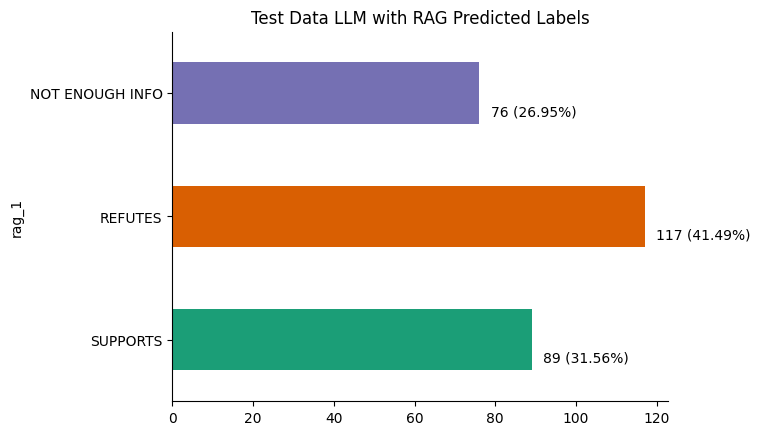

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Group by the 'label' column and count the occurrences
label_counts = fever_test['rag_1'].value_counts()
label_counts = label_counts.reindex(['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']).fillna(0)

# Calculate total number of instances for percentage calculation
total = label_counts.sum()

# Plot the bar plot
ax = label_counts.plot(kind='barh', color=sns.color_palette('Dark2'))

# Remove top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Annotate each bar with the count and the percentage of the total
for i in ax.patches:
    # Calculate percentage
    percentage = f'{(i.get_width() / total):.2%}'
    # Set the annotation text, which includes the count and percentage
    annotation_text = f'{int(i.get_width())} ({percentage})'
    # Place the annotation text on the bar
    ax.text(i.get_width() + total * 0.01, i.get_y() + 0.1, annotation_text, va='center', color='black')

# Set the title
ax.set_title('Test Data LLM with RAG Predicted Labels')

# Show the plot
plt.show()

Visualisation: Confusion Matrix (LLM with RAG Augmentation)

Confusion Matrix (LLM with RAG Augmentation):
[[63  6 19]
 [ 7 71 12]
 [19 40 45]]


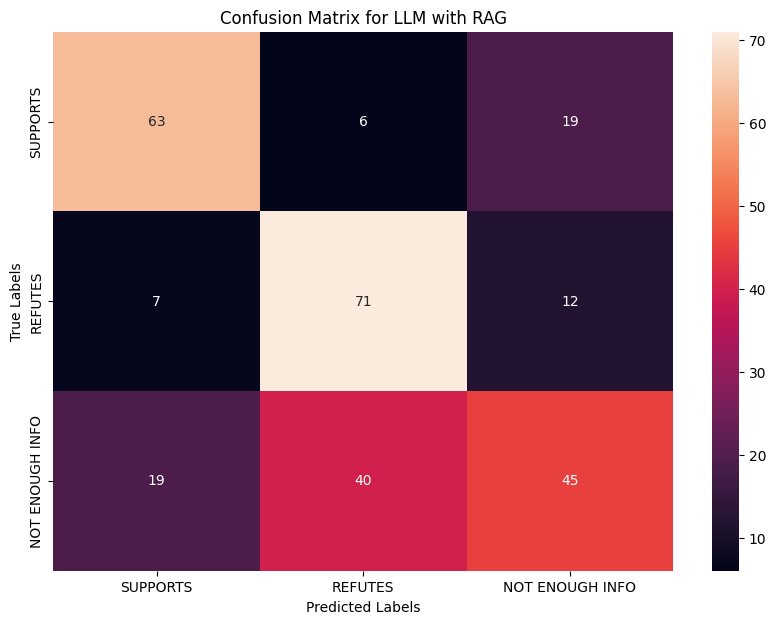

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Extract true labels and predicted labels
true_labels = fever_test['label']
predicted_labels = fever_test['rag_1']

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])

# Print the confusion matrix
print('Confusion Matrix (LLM with RAG Augmentation):')
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
# ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'], yticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'], yticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for LLM with RAG')

# Show the plot
plt.show()

Visualisation: Classification report and plot it as a heatmap (LLM with RAG Augmentation)

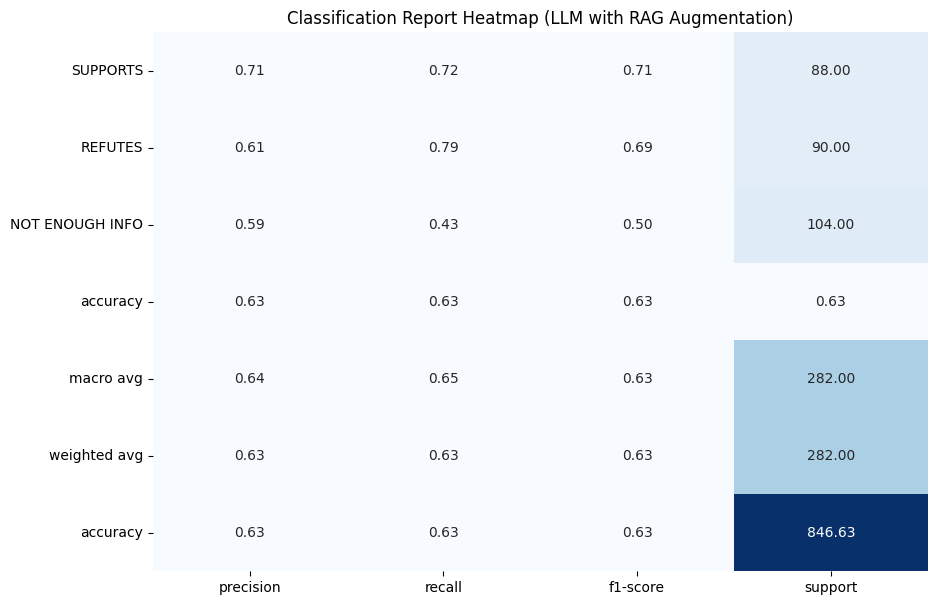

In [ ]:
# Generate classification report with the specified labels
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


true_labels = fever_test['label']
predicted_labels = fever_test['rag_1']
# Generate classification report with the specified labels
report = classification_report(true_labels, predicted_labels,
                               labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'],
                               output_dict=True)

# Calculate the overall accuracy
accuracy_value = accuracy_score(true_labels, predicted_labels)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Verify report_df is a DataFrame before appending
if not isinstance(report_df, pd.DataFrame):
    raise ValueError("report_df is not a pandas DataFrame. Please check your code and data.")

# Create a new row for accuracy and append it
accuracy_row = pd.DataFrame({'precision': [accuracy_value],
                             'recall': [accuracy_value],
                             'f1-score': [accuracy_value],
                             'support': [np.sum(report_df['support'])]},
                             index=['accuracy'])
report_with_accuracy_df = pd.concat([report_df, accuracy_row])

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(report_with_accuracy_df, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.title('Classification Report Heatmap (LLM with RAG Augmentation)')
plt.xlabel('')
plt.ylabel('')
plt.yticks(rotation=0)
plt.show()

In [ ]:
#Plotting performance of LLM alone

fever_test = pd.DataFrame(X_test)
fever_test=fever_test[:500]
fever_test=fever_test.loc[:,['claim', 'label']]
fever_test=fever_test.drop_duplicates()

results = []

for claim in tqdm(fever_test['claim']):
  result = get_completion(prompt_self(claim), model = "claude-3-haiku-20240307", max_tokens=512)
  result = result.strip().replace('.', '')
  results.append(result)

fever_test['LLM'] = results

# Calculate the accuracy of the LLM only method on the dataset
total_rows = len(fever_test)
equal_rows = len(fever_test[fever_test['label'] == fever_test['LLM']])
accuracy = (equal_rows / total_rows) * 100

print("LLM only method")
print('Number of roles with correct predictions: ',equal_rows)
print('Accuracy: ',accuracy)

fever_test

100%|██████████| 282/282 [19:37<00:00,  4.17s/it]

LLM only method
Number of roles with correct predictions:  163
Accuracy:  57.801418439716315


,claim,label,LLM
0,Grease had bad reviews.,NOT ENOUGH INFO,REFUTES
1,Ukrainian Soviet Socialist Republic was a foun...,SUPPORTS,REFUTES
8,2 Hearts is a musical composition by Minogue.,SUPPORTS,REFUTES
12,The New Jersey Turnpike has zero shoulders.,REFUTES,REFUTES
13,Legendary Entertainment is the owner of Wanda ...,NOT ENOUGH INFO,REFUTES
...,...,...,...
495,Georgians arose from the ancient Ethiopian civ...,NOT ENOUGH INFO,REFUTES
496,Alan White was an Ambassador from California t...,NOT ENOUGH INFO,NOT ENOUGH INFO
497,James Brolin has had roles in situational come...,SUPPORTS,SUPPORTS
498,The Vandals were an East Germanic religion.,REFUTES,REFUTES


Visualisation: Distribution of FEVER Test Data (True Labels)

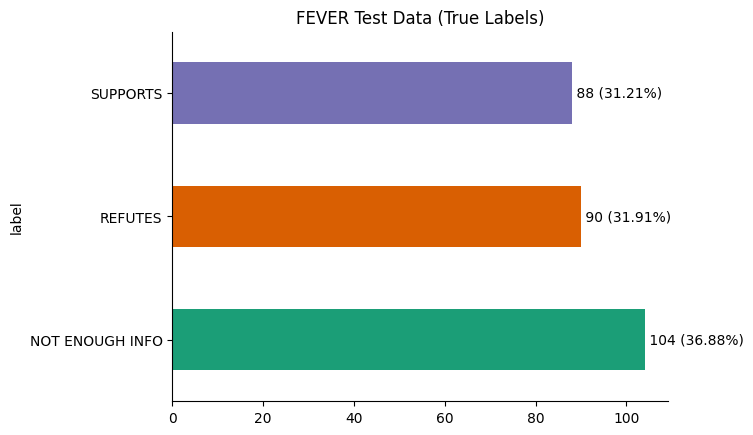

In [ ]:
# Display the distribution of ground truth labels
ax = fever_test.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('FEVER Test Data (True Labels)', loc='center')

# Calculate the total number of instances
total = len(fever_test)

# Annotate the bars
for p in ax.patches:
    width = p.get_width()
    percentage = f'{100 * width/total:.2f}%'
    ax.text(width, p.get_y() + p.get_height()/2, f' {width} ({percentage})', va='center')

plt.savefig('Test data true labels.png')

Visualisation: Distribution of Predicted Labels by LLM only

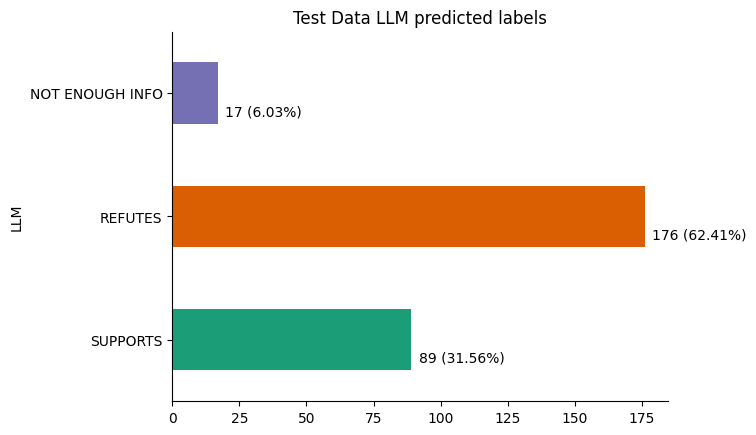

In [ ]:
# Display the distribution of LLM predicted labels
from matplotlib import pyplot as plt
import seaborn as sns

# Group by the 'label' column and count the occurrences
label_counts = fever_test['LLM'].value_counts()
label_counts = label_counts.reindex(['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']).fillna(0)

# Calculate total number of instances for percentage calculation
total = label_counts.sum()

# Plot the bar plot
ax = label_counts.plot(kind='barh', color=sns.color_palette('Dark2'))

# Remove top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Annotate each bar with the count and the percentage of the total
for i in ax.patches:
    # Calculate percentage
    percentage = f'{(i.get_width() / total):.2%}'
    # Set the annotation text, which includes the count and percentage
    annotation_text = f'{int(i.get_width())} ({percentage})'
    # Place the annotation text on the bar
    ax.text(i.get_width() + total * 0.01, i.get_y() + 0.1, annotation_text, va='center', color='black')

# Set the title
ax.set_title('Test Data LLM predicted labels')

# Show the plot
plt.show()

Visualisation: Confusion matrix with LLM only

Confusion Matrix (LLM only):
[[68 19  1]
 [ 3 83  4]
 [18 74 12]]


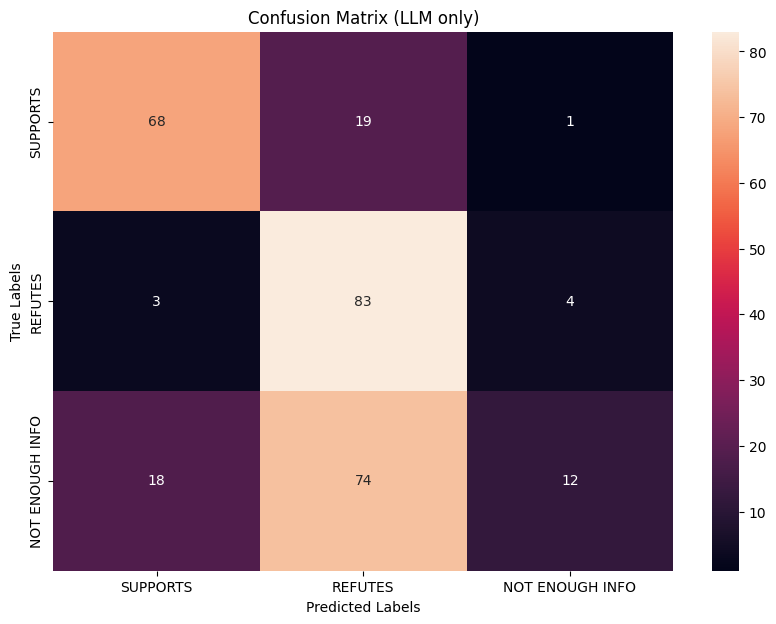

In [ ]:
# Generate classification report with the specified labels
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract true labels and predicted labels
true_labels = fever_test['label']
predicted_labels = fever_test['LLM']

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])

# Print the confusion matrix
print('Confusion Matrix (LLM only):')
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
# ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'], yticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'], yticklabels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'])
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix (LLM only)')

# Show the plot
plt.show()

Visualisation: Classification report and plot it as a heatmap (LLM only)

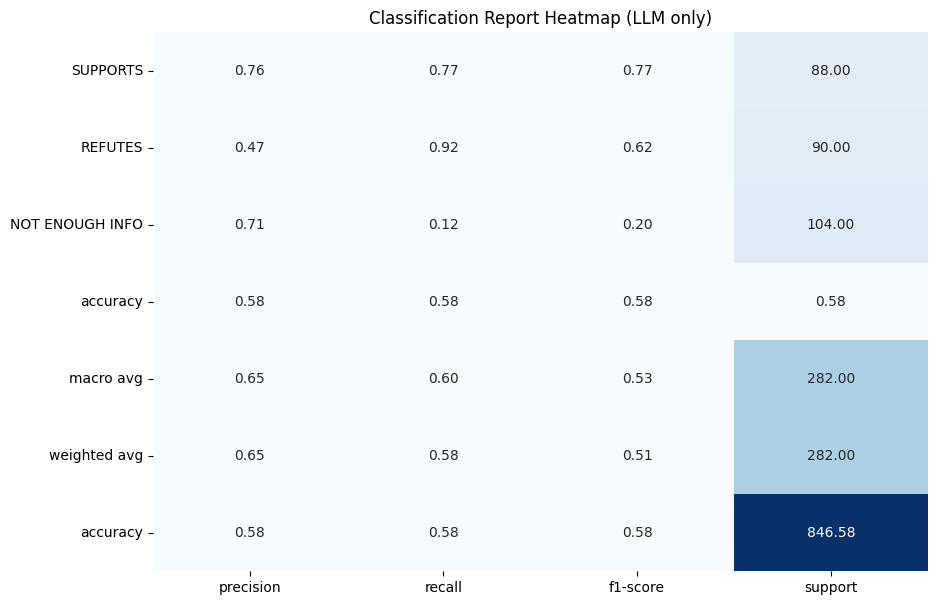

In [ ]:
# Generate classification report with the specified labels
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Extract true labels and predicted labels
true_labels = fever_test['label']
predicted_labels = fever_test['LLM']

# Generate classification report with the specified labels
report = classification_report(true_labels, predicted_labels,
                               labels=['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO'],
                               output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate the overall accuracy
accuracy_value = accuracy_score(true_labels, predicted_labels)

# Verify report_df is a DataFrame before appending
if not isinstance(report_df, pd.DataFrame):
    raise ValueError("report_df is not a pandas DataFrame. Please check your code and data.")

# Create a new row for accuracy and append it
accuracy_row = pd.DataFrame({'precision': [accuracy_value],
                             'recall': [accuracy_value],
                             'f1-score': [accuracy_value],
                             'support': [np.sum(report_df['support'])]},
                             index=['accuracy'])
report_with_accuracy_df = pd.concat([report_df, accuracy_row])

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(report_with_accuracy_df, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.title('Classification Report Heatmap (LLM only)')
plt.xlabel('')
plt.ylabel('')
plt.yticks(rotation=0)
plt.show()